In [1]:
import torch.nn as nn
import torch.nn.init as init

import numpy as np
import pandas as pd

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import yaml
import sys

import os
import time
import cv2

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [2]:
import onnx
from onnx import numpy_helper
import onnxruntime as ort
from onnx_tf.backend import prepare

/home/kyra/anaconda3/envs/animl-gpu/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence

In [4]:
#make sure the animl-py path is included
# sys.path
# sys.path.append("/home/kyra/animl-py/src/") #make sure animl-py is in the path for loading model class

In [5]:
from animl.classifiers import CTLClassifier, EfficientNet

from animl.generator import TrainGenerator
from animl.generator import TFGenerator

In [6]:
from animl import classifiers
from animl import inference

from animl.inference import predict_species
from tqdm import tqdm

import animl.generator as generator

## OnnxGenerator 

In [7]:
class OnnxGenerator(Sequence):
    def __init__(self, x, file_col='file', crop=True, resize=299, buffer=0, batch=32):
        self.x = x
        self.file_col = file_col
        self.crop = crop
        self.resize = int(resize)
        self.buffer = buffer
        self.batch = int(batch)

    def __len__(self):
        return int(np.ceil(len(self.x.index) / float(self.batch)))

    def __getitem__(self, idx):
        imgarray = []
        for i in range(min(len(self.x.index), idx * self.batch),
                       min(len(self.x.index), (idx + 1) * self.batch)):
            try:
                file = self.x[self.file_col].iloc[i]
                img = Image.open(file)
            except OSError:
                continue

            if self.crop:
                width, height = img.size
                bbox1 = self.x['bbox1'].iloc[i]
                bbox2 = self.x['bbox2'].iloc[i]
                bbox3 = self.x['bbox3'].iloc[i]
                bbox4 = self.x['bbox4'].iloc[i]

                left = width * bbox1
                top = height * bbox2
                right = width * (bbox1 + bbox3)
                bottom = height * (bbox2 + bbox4)

                left = max(0, left - self.buffer)
                top = max(0, top - self.buffer)
                right = min(width, right + self.buffer)
                bottom = min(height, bottom + self.buffer)
                img = img.crop((left, top, right, bottom))

            img = img.resize((self.resize, self.resize))
#             img = tf.keras.utils.img_to_array(img)
            imgarray.append(img)       
        
        return np.asarray(imgarray[0])

## Define Variables

In [18]:
PATH = "/mnt/machinelearning/Models/Andes/Experiment2/30.pt"


#load the config
cfg = yaml.safe_load(open("/mnt/machinelearning/Models/Andes/Experiment2/exp2.yaml", 'r'))

image_size= cfg["image_size"]
num_epochs= cfg["num_epochs"]


workers = cfg["num_workers"]


TestFileName = cfg["test_set"]
TrainFileName = cfg["training_set"]

DataFileName = TestFileName
# DataFileName = "/mnt/machinelearning/Training Data - Andes/training_data.csv"

dataset = pd.read_csv(DataFileName)
filecol ='FilePath'

# batch_size = cfg["batch_size"]
batch_size = 1 #some places called batch -> TODO: RENAME THEM!!

In [19]:
detections = pd.read_csv(DataFileName)

# model = modelInstance
classFileName = cfg["class_file"]
classes = pd.read_csv(cfg["class_file"])

### Ensure OnnxGenerator is correctly cropping images

In [20]:
print(batch_size)
print(filecol)
# dataset

1
FilePath


In [21]:
dataset_instance = OnnxGenerator(x=dataset, file_col='FilePath', batch=batch_size)
# dataset_instance = OnnxGenerator(x=dataset.iloc[1:10], file_col='FilePath', batch=batch_size)

In [22]:
dataset_instance.x

,Unnamed: 0,FilePath,species,file,conf,...,taxon,Image,FilePath2,Frame,label
0,0,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.10000,...,Ave,Loc64_20160604_075905.jpg,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird
1,33,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.01750,...,Grallaria squamigera,Loc31A_20160705_062542.jpg,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird
2,553,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas_20...,0.00777,...,Grallaria quitensis,Loc20_20150903_073737.jpg,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird
3,799,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.02240,...,Geotrygon frenata,Loc56A_20160715_084339.jpg,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird
4,3394,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.01760,...,Rodentia,Loc54_20160919_205023.jpg,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal
...,...,...,...,...,...,...,...,...,...,...,...
19720,20193,/mnt/machinelearning/Training Data - Amazon/Cr...,southern naked-tailed armadillo,S:/Camera Base MT/Images/17/SDZG 141_20180906_...,0.98100,...,NaN,NaN,NaN,NaN,southern naked-tailed armadillo
19721,20194,/mnt/machinelearning/Training Data - Amazon/Cr...,southern naked-tailed armadillo,S:/Camera Base MT/Images/17/SDZG 212_20180919_...,0.37600,...,NaN,NaN,NaN,NaN,southern naked-tailed armadillo
19722,20195,/mnt/machinelearning/Training Data - Amazon/Cr...,southern naked-tailed armadillo,S:/Camera Base MT/Images/17/SDZG 210_20181010_...,0.99400,...,NaN,NaN,NaN,NaN,southern naked-tailed armadillo
19723,20196,/mnt/machinelearning/Training Data - Amazon/Cr...,southern naked-tailed armadillo,S:/Camera Base MT/Images/17/SDZG 141_20180906_...,0.95500,...,NaN,NaN,NaN,NaN,southern naked-tailed armadillo


(299, 299, 3)


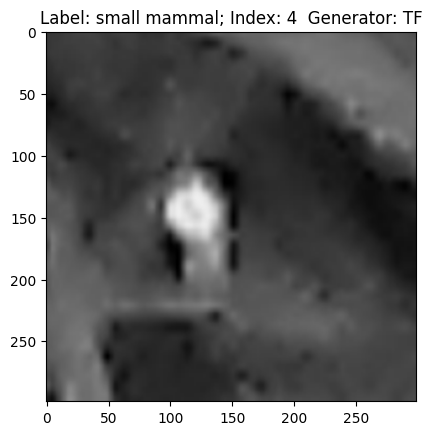

In [28]:
# idx = np.random.randint(0,len(pd.read_csv(DataFileName)))  
# idx = 113703 #48955 #28294

idx = 4
# idx = np.random.randint(0,10) 

label="species"

#set up the figure
fig = plt.figure()

datalabel = dataset[label][idx] #save label of image
plt.title(("Label: " + datalabel + "; Index: " + str(idx)) + "  Generator: TF")

#grab the image
img = dataset_instance.__getitem__(idx)
print(img.shape)

plt.imshow((img))

### Ensure that the image chosen has the right dimensions

In [29]:
tenImg = img

inputImg = np.random.randn(1, 3, 299, 299).astype(np.float32)
tempSwap = np.swapaxes(tenImg, 0, 2)                  # (H,W,3) --> 3, H, W
inputImg[0,:] = np.swapaxes(tempSwap, 1, 2)
inputImg.shape

(1, 3, 299, 299)

## Load the Pytorch Model

In [30]:
print(PATH)
print(classFileName)

/mnt/machinelearning/Models/Andes/Experiment2/30.pt
/mnt/machinelearning/Training Data - Andes/andes_classes.txt


In [31]:
modelTorch, classTorch= classifiers.load_model(PATH, classFileName, device="cpu", architecture="CTL", overwrite=False)

Loading model at /mnt/machinelearning/Models/Andes/Experiment2/30.pt


/home/kyra/anaconda3/envs/animl-gpu/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model in 2.91 seconds


In [58]:
# modelTorch

In [93]:
# classTorch

In [33]:
detectionsOut = predict_species(detections.iloc[1:10].reset_index(drop=True), modelTorch, classTorch, file_col="FilePath")

9it [00:01,  5.28it/s]


In [34]:
detectionsOut

,Unnamed: 0,FilePath,species,file,conf,...,FilePath2,Frame,label,prediction,confidence
0,33,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.01750,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird,bolivian squirrel,0.439268
1,553,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas_20...,0.00777,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird,unknown bird,0.999928
2,799,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,unknown bird,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.02240,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,unknown bird,other opossum,0.792812
3,3394,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.01760,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal,andean fox,0.504417
4,3395,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.00641,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal,ocelot,0.463647
5,3401,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.00941,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal,small mammal,0.807096
6,3519,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.00662,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal,black agouti,0.230499
7,3532,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.03840,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal,unknown bird,0.797293
8,3735,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,small mammal,S:/Camera Trap Datasets/Tabaconas/Tabaconas201...,0.00526,...,/mnt/mathias/Camera Trap Datasets/Tabaconas/Ta...,NaN,small mammal,small mammal,0.469879


In [88]:
output_torch = modelTorch.forward(torch.from_numpy(inputImg))

In [89]:
output_torch.detach().numpy()

array([[     4.9896,      5.2662,     -5.5428,      3.9304,       3.121,      4.5197,     -5.9709,     -5.2311,     -4.1761,     0.21722,      2.9877,      2.0848,     -6.8498,     -8.6492,     -3.6565,       3.802,     -5.1831,     -1.1773,       2.397,     0.80675,      2.5587,      1.1213,      2.6564,
            0.68247,    -0.53702,     -2.4765,     -5.5202,     -5.3647,     -1.5847,     0.23017,      5.1622,     -1.2835,      3.7507,      2.0887,    0.036788,  -0.0064059,   -0.060764,      3.7727,     0.77433,    -0.83925,      1.5352,     -3.2249,        3.87,     0.63036,      5.5559,     0.58942,
            -3.2659,      -3.419,    -0.20797,     0.12761,      5.9111,     -2.7656,    -0.60507]], dtype=float32)

In [90]:
prediction=np.argmax((output_torch.detach().numpy())[0], axis=0)
print(prediction)

50


# load the saved onnx model

In [98]:
#load the saved onnx model
onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

In [99]:
output = prepare(onnx_model).run(inputImg) 
output[0]

2024-01-12 12:20:10.293494: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 12:20:11.629665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8495 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:15:00.0, compute capability: 7.5
2024-01-12 12:20:11.630247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9171 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:21:00.0, compute capability: 7.5
2024-01-12 12:20:21.594025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimizatio

array([[     4.9896,      5.2662,     -5.5427,      3.9304,       3.121,      4.5197,     -5.9709,     -5.2311,     -4.1761,     0.21721,      2.9877,      2.0848,     -6.8498,     -8.6492,     -3.6565,       3.802,     -5.1831,     -1.1773,       2.397,     0.80675,      2.5587,      1.1212,      2.6564,
            0.68247,    -0.53703,     -2.4765,     -5.5202,     -5.3647,     -1.5847,     0.23016,      5.1622,     -1.2835,      3.7507,      2.0887,    0.036785,  -0.0064158,   -0.060767,      3.7727,     0.77432,    -0.83924,      1.5352,     -3.2249,        3.87,     0.63035,      5.5559,     0.58942,
            -3.2659,      -3.419,    -0.20796,     0.12762,      5.9111,     -2.7657,    -0.60505]], dtype=float32)

In [100]:
prediction=int(np.argmax(np.array(output).squeeze(), axis=0))
print(prediction)

50


In [39]:
# detections

In [261]:
# dataset = generator.create_dataloader(detections, batch, workers, filecol)
# with torch.no_grad():
#     for ix, (data, _) in tqdm(enumerate(dataset)):
#         data.to("cpu")
#         output = model(data)

#         pred = classes['species'].values[torch.argmax(output, 1).numpy()[0]]
#         probs = torch.max(torch.nn.functional.softmax(output, dim=1), 1).values.numpy()[0]

#         detections.loc[ix, 'prediction'] = pred
#         detections.loc[ix, 'confidence'] = probs

In [37]:
# dataset = generator.create_dataloader(detections, batch_size=1, workers=1, framework="torch", filecol=filecol)

TypeError: create_dataloader() got an unexpected keyword argument 'filecol'

In [39]:
datasetGen = generator.create_dataloader(detections.iloc[1:10], batch_size=1, workers=1, framework="torch", file_col=filecol)

In [40]:
datasetGen.dataset.x

,Unnamed: 0,FilePath,species,file,max_detection_conf,...,taxon,Image,FilePath2,Frame,label
1,5,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/17/SDZG 174_20180911_...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
2,6,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/19/19_20170828_174105...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
3,7,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/17/WWF 16_20181116_16...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
4,12,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/14/SDZG 132_20140928...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
5,14,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/15/SDZG 214_20150517_...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
6,15,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/13/WWF16_20130828_164...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
7,19,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/13/SDZG34_20130704_16...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
8,23,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/16/R17_REBG76_2016080...,NaN,...,NaN,NaN,NaN,NaN,unknown bird
9,26,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/14/SDZG 203_20140627...,NaN,...,NaN,NaN,NaN,NaN,unknown bird


In [91]:
detectionsOut = predict_species(detections.iloc[1:10].reset_index(drop=True), modelTorch, classes, file_col="FilePath")

9it [00:01,  5.92it/s]


In [78]:
detectionsOut = predict_species(detections.reset_index(), model, classes)

0it [00:00, ?it/s]


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/PIL/Image.py", line 2979, in open
    fp.seek(0)
AttributeError: 'float' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/kyra/animl-py/src/animl/generator.py", line 100, in __getitem__
    img = Image.open(image_name).convert('RGB')
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/PIL/Image.py", line 2981, in open
    fp = io.BytesIO(fp.read())
AttributeError: 'float' object has no attribute 'read'


In [92]:
detectionsOut

,Unnamed: 0,FilePath,species,file,max_detection_conf,...,FilePath2,Frame,label,prediction,confidence
0,5,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/17/SDZG 174_20180911_...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.996722
1,6,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/19/19_20170828_174105...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.896815
2,7,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/17/WWF 16_20181116_16...,NaN,...,NaN,NaN,unknown bird,spix's guan,0.945773
3,12,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/14/SDZG 132_20140928...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.993233
4,14,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/15/SDZG 214_20150517_...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.999887
5,15,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/13/WWF16_20130828_164...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.982536
6,19,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/13/SDZG34_20130704_16...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.908520
7,23,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/16/R17_REBG76_2016080...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.999958
8,26,/mnt/machinelearning/Training Data - Amazon/Cr...,unknown bird,S:/Camera Base MT/Images/14/SDZG 203_20140627...,NaN,...,NaN,NaN,unknown bird,unknown bird,0.997680


In [ ]:
for ix, (data, name) in tqdm(enumerate(datasetGen)):
#     print(type(ix))
    print(ix, name)
#     print(name)


1it [00:00,  7.38it/s]

0 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Apu 3_20171011_160419_Andean bear.jpg',)


4it [00:00,  9.58it/s]

1 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc12A_20160721_181750.jpg',)
2 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/_20211023_032527_Red brocket deer.jpg',)
3 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_3300_20110516_145747_001_Puma.jpg',)
4 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181116_055752_Andean bear.jpg',)
5 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/50_20160918_190324_001_c1.jpg',)


8it [00:00, 11.89it/s]

6 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140912_012919_002.jpg',)
7 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/San Pedro 4_20200623_013150_Margay.jpg',)


10it [00:01, 10.34it/s]

8 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20141220_080735.jpg',)
9 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Apu 1_20160705_220422_Mountain paca.jpg',)


12it [00:01,  6.70it/s]

10 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc53B_20170930_035136.jpg',)
11 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1a_20171002_145600_Andean bear.jpg',)


14it [00:01,  7.03it/s]

12 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20141212_003010.jpg',)
13 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170131_093216_Brown agouti.jpg',)


19it [00:02, 11.97it/s]

14 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Trocha Erickson 1_20200406_220000_Ocelot.jpg',)
15 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20210824_142150_Andean bear.jpg',)
16 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_1700_20110910_131519_Razor-billed Curassow.jpg',)
17 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R38_REBG26_20160911_005625_09110241.JPG',)
18 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 234_20150528_010322_c1.jpg',)


23it [00:02, 12.45it/s]

19 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150122_200730.jpg',)
20 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20180413_174402_001_Andean bear.jpg',)
21 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153151_White-lipped Peccary.jpg',)
22 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean White-Eared Opossum/Vitobamba_5300_20110216_025346_Andean White-Eared Opossum.jpg',)
23 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200831_132909_Andean bear.jpg',)


25it [00:02,  7.71it/s]

24 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160908_025709.jpg',)


29it [00:03,  9.00it/s]

25 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc32_20160716_090908-28752-15.jpg',)
26 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R78_REBG17_20161124_044033_11240298.JPG',)
27 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 5_20181206_100106_Jaguar.jpg',)
28 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  141_20140911_024615_001_c2.jpg',)
29 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Trocha Erickson 1_20190618_215350_Dwarf brocket deer.jpg',)


31it [00:03,  8.20it/s]

30 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN5_20141212_095509.jpg',)
31 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 7_20181111_103155_Razor-billed currassow.jpg',)


33it [00:03,  7.31it/s]

32 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160629_185349.jpg',)


34it [00:04,  5.45it/s]

33 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc46A_20171009_145813.jpg',)
34 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Vitobamba_1300_20110915_125304_Spix's guan.jpg",)


36it [00:04,  6.13it/s]

35 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150202_155738_001.jpg',)
36 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  166_20140806_023323_c4.jpg',)
37 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181205_213134_Tayra.jpg',)


39it [00:04,  6.87it/s]

38 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42B_20160901_180011.jpg',)
39 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc41_20151025_010222-83672-15.jpg',)


43it [00:05,  8.86it/s]

40 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083646_White-lipped peccary.jpg',)
41 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_900_20110919_140549_Puma.jpg',)
42 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 6_20180206_214604_Brown four-eyed opossum.jpg',)
43 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/61_20160920_165507_001.jpg',)
44 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 246_20150520_022850_c2.jpg',)


47it [00:05, 11.62it/s]

45 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  203_20140823_074755.jpg',)
46 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG84_20150210_014619.jpg',)
47 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20200615_114515_Collared peccary.jpg',)


49it [00:05, 12.76it/s]

48 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/48A_20170618_041859.jpg',)
49 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc51B_20171008_050350.jpg',)


51it [00:06,  7.12it/s]

50 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc2_20160707_175600.jpg',)
51 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_163932_White-lipped Peccary.jpg',)
52 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 68_20180830_033408_08300013.JPG',)


56it [00:06,  8.10it/s]

53 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc77B_20160607_180719.jpg',)
54 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 12_20180905_024010_09050314_c2.JPG',)
55 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20191212_110921_Andean bear.jpg',)
56 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20211109_042622_Andean bear.jpg',)
57 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  125_20140724_043521_001_c3.jpg',)


62it [00:07, 11.41it/s]

58 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 1_20170508_165737_Brown agouti.jpg',)
59 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2300_20100505_160739_Brown Agouti.jpg',)
60 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R81_REBG44_20161126_053004_11260261.JPG',)
61 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 1_20181017_210441_Dwarf brocket deer.jpg',)


64it [00:07, 10.86it/s]

62 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 9_20170726_105638_Spix's guan.jpg",)
63 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20170816_133415_South American coati.jpg',)


66it [00:07,  9.97it/s]

64 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20180318_072314_Andean bear.jpg',)
65 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 5_20181013_031627_Molina's hog-nosed skunk.jpg",)
66 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 257_20150526_133731.jpg',)


69it [00:07, 12.41it/s]

67 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/14B_20170823_182433_001.jpg',)
68 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170131_093309_001_Brown agouti.jpg',)


71it [00:08, 10.20it/s]

69 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 2_20200525_075049_Brown agouti.jpg',)
70 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201010_081640_Collared peccary.jpg',)
71 ('/mnt/machinelearning/Training Data - Amazon/Crops/6/AREAS 19_20080903_191100.jpg',)


73it [00:08, 10.28it/s]

72 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc37B_20151002_080236_001.jpg',)


75it [00:08,  7.27it/s]

73 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52A_20160705_214900.jpg',)
74 ('/mnt/machinelearning/Training Data - Andes/Mammals/Cow/Wayqecha 7_20171029_083410_Cow.jpg',)


77it [00:08,  8.32it/s]

75 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20180404_141718_Andean bear.jpg',)
76 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/GrayTinamou/Vitobamba_2100_20110408_143212_Gray tinamou.jpg',)


79it [00:09,  7.53it/s]

77 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 9_20171226_040225_Brazilian tapir.jpg',)
78 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc7B_20160803_200148.jpg',)


80it [00:09,  5.92it/s]

79 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc38B_20171108_071219.jpg',)


81it [00:09,  5.08it/s]

80 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160624_072543.jpg',)


82it [00:10,  4.43it/s]

81 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc1A_20150916_172759.jpg',)
82 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 10_20180205_113631_001_Collared peccary.jpg',)


84it [00:10,  5.14it/s]

83 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN12_20150103_235506.jpg',)
84 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_171620_White-lipped Peccary.jpg',)


87it [00:11,  5.41it/s]

85 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42B_20160614_032742.jpg',)
86 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Apu 9_20200402_104737_Andean guan.jpg',)


89it [00:11,  7.25it/s]

87 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 5_20190526_231529_Ocelot.jpg',)
88 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_170041_001_White-lipped Peccary.jpg',)
89 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 10_20171017_185541_001_Lowland paca.jpg',)


94it [00:11, 12.11it/s]

90 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20180219_074436_Brown agouti.jpg',)
91 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/17_20160928_015145_c11.jpg',)
92 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/40_20161031_175746_c2.jpg',)
93 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  121_20140807_005852.jpg',)


96it [00:11, 12.79it/s]

94 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_2100_20111201_121223_White-lipped Peccary.jpg',)
95 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 60_20181022_165453_10220305_c2.JPG',)


100it [00:11, 11.28it/s]

96 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150130_040327.jpg',)
97 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/50_20160828_133853.jpg',)
98 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191211_101655_Andean guan.jpg',)
99 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 210_20180918_012801_EK001254.JPG',)
100 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20211108_124458_Andean bear.jpg',)


104it [00:12,  7.67it/s]

101 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160713_001433.jpg',)
102 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc15A_20170930_022434.jpg',)
103 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/48A_20170717_015556.jpg',)


107it [00:12,  8.86it/s]

104 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/ZSSD19_20110823_230053_Mountain paca.jpg',)
105 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/84_20160807_042203.jpg',)
106 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20141212_214334.jpg',)


109it [00:13, 10.41it/s]

107 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20190329_161623_Brown agouti.jpg',)
108 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_3400_20111019_174737_Dwarf Brocket Deer.jpg',)
109 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180419_165535_Razor-billed currassow.jpg',)


111it [00:13,  8.15it/s]

110 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160930_055347.jpg',)
111 ('/mnt/machinelearning/Training Data - Andes/Birds/Wood Quail/Rufous-breasted_wood-quail_Odontophorus_speciosus/Paititi  2_20170630_064321_Rufous-breasted wood-quail.jpg',)


116it [00:13, 10.31it/s]

112 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190922_205800_Lowland paca.jpg',)
113 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF1_20140111_112809.jpg',)
114 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 177_20140707_193140_001.jpg',)
115 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160926_205132_Red brocket deer.jpg',)


120it [00:14, 10.79it/s]

116 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200731_110616_Andean bear.jpg',)
117 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20170807_125712_Andean bear.jpg',)
118 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20171111_064228_Andean bear.jpg',)
119 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/17_20160929_001609_c9.jpg',)


124it [00:14, 10.41it/s]

120 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc50_20160709_191905_001.jpg',)
121 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-02_20110630_222904.jpg',)
122 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  5_20170418_084651_001_Highland coati.jpg',)
123 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc93A_20160615_184238-52624-15.jpg',)


126it [00:14,  9.90it/s]

124 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Gray_tinamou_Tinamus_tao/Chontachaca 1_20200117_092747_Gray tinamou.jpg',)
125 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201019_131009_Collared peccary.jpg',)
126 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  163_20140905_084329.jpg',)


128it [00:15, 11.52it/s]

127 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 10_20181205_114656_Andean fox.jpg',)
128 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1_20161103_062537_Collared peccary.jpg',)


132it [00:15,  9.05it/s]

129 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc40_20151011_155630.jpg',)
130 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Lago Camera 1_20180129_191639_Mountain paca.jpg',)
131 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n 8_20200218_100547_Highland coati.jpg',)
132 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Peru Verde 1_20170312_091735_Collared peccary.jpg',)


136it [00:16,  8.04it/s]

133 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc35B_20160709_134907.jpg',)
134 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  89_20140731_014302.jpg',)
135 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  2_20180621_213545_Mouse opossum.jpg',)


141it [00:16, 12.77it/s]

136 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074514_001_Collared peccary.jpg',)
137 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 236_20150527_010224.jpg',)
138 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  101_20140926_005557.jpg',)
139 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 170_20180820_030024_EK000326.JPG',)
140 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_20180923_021721_Brazilian cottontail rabbit.jpg',)
141 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20190630_055644_Andean bear.jpg',)


144it [00:16, 14.10it/s]

142 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 250_20150712_202818_c4.jpg',)
143 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Villa Carmen 1_20161217_075931_002_Tayra.jpg',)


149it [00:16, 15.05it/s]

144 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG155_20150226_092333.jpg',)
145 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Chontachaca 2 camera 1_20210916_051120_Red brocket deer.jpg',)
146 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/24_20161103_191502_c2.jpg',)
147 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R31_REBG80_20170306_021936_03060103_c2.JPG',)
148 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_2600_20091229_045514_Oncilla.jpg',)


152it [00:17, 16.64it/s]

149 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 60_20180902_005923_09020048.JPG',)
150 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R73_REBG82_20161004_072925_10040128.JPG',)
151 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170820_112753_001_Collared peccary.jpg',)
152 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 72_20180811_211445_EK000283_c3.JPG',)


154it [00:17, 16.01it/s]

153 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 10_20181121_202612_Dwarf brocket deer.jpg',)
154 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 10_20190807_231711_Dwarf brocket deer.jpg',)


158it [00:17, 13.22it/s]

155 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20180120_123809_001_Collared peccary.jpg',)
156 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/ZSSD56_20110717_073156_Andean Bear.jpg',)
157 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20211109_041939_Andean bear.jpg',)
158 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083753_White-lipped peccary.jpg',)


162it [00:18,  9.73it/s]

159 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc49_20160807_152212.jpg',)
160 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R17_REBG76_20160826_162216_08260339_c2.JPG',)
161 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Paititi 3_20210725_113446_001_Andean bear.jpg',)


164it [00:18,  7.79it/s]

162 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc64_20160530_231421.jpg',)
163 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 364_20180830_191059_08300346_c1.JPG',)


168it [00:19,  8.59it/s]

164 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc20_20160607_205243.jpg',)
165 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  202_20140814_131238_001.jpg',)
166 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-02_20110630_222905.jpg',)
167 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082459_001_Jaguar.jpg',)
168 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_175259_White-lipped Peccary.jpg',)


170it [00:19,  9.39it/s]

169 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20180305_145844_Brown agouti.jpg',)


172it [00:19,  6.43it/s]

170 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc73A_20160710_141951.jpg',)
171 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 1_20170904_035104_001_Mountain paca.jpg',)


175it [00:20,  6.35it/s]

172 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42B_20160809_165429.jpg',)
173 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_155814_White-lipped Peccary.jpg',)
174 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/HoodedTinamou/Iscaybamba_3200_20111101_132138_Hooded tinamou.jpg',)


177it [00:20,  7.00it/s]

175 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 364_20180723_162311_07230120.JPG',)
176 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG54_20150109_080641.jpg',)


178it [00:20,  7.21it/s]

177 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 1_20161018_131231_Brown agouti.jpg',)
178 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 93_20180805_033223_EK000205.JPG',)
179 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  213_20140728_215901.jpg',)
180 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 154_20180926_130433_EK000807_c2.JPG',)


183it [00:21,  8.29it/s]

181 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40A_20171022_125021.jpg',)
182 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Vitobamba_2500_20110926_210622_Paca.jpg',)
183 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20180121_143134_001_Andean bear.jpg',)


186it [00:21,  8.56it/s]

184 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc72_20160616_101353.jpg',)
185 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181204_024620_Tayra.jpg',)


190it [00:21, 11.51it/s]

186 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 12_20171028_053545_Red brocket deer.jpg',)
187 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/40B_20170630_223110.jpg',)
188 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2100_20110307_175030_Brown Agouti.jpg',)
189 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20171111_064216_Andean bear.jpg',)


196it [00:22, 14.02it/s]

190 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160907_070249.jpg',)
191 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/2_20160708_202138.jpg',)
192 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF7_20130826_062255_c2.jpg',)
193 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R35_REBG36_20161003_000204_10030868.JPG',)
194 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/17_20160929_001541_c1.jpg',)
195 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 40_20180904_100926_09040313.JPG',)


198it [00:22, 14.22it/s]

196 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 2b_20190522_190835_001_Brazilian tapir.jpg',)
197 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/San Pedro  3_20190107_152333_Bolivian squirrel.jpg',)
198 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/13B_20170714_015119_001.jpg',)
199 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/53_20160825_004254_001.jpg',)


203it [00:22, 16.00it/s]

200 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 8_20171122_175440_Brazilian tapir.jpg',)
201 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Trocha Uni_n  2_20170702_164318_Puma.jpg',)
202 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/87_20161018_020354_c2.jpg',)
203 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181107_054915_Andean bear.jpg',)


206it [00:22, 18.96it/s]

204 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 51_20180828_230626_08280017.JPG',)
205 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SZF 006_20131229_211811.jpg',)
206 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc58A_20170930_102101_001.jpg',)


211it [00:23,  9.03it/s]

207 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc92A_20160819_081429.jpg',)
208 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20160912_031042_09120674_c2.JPG',)
209 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20181219_072933_Razor-billed currassow.jpg',)
210 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153735_White-lipped Peccary.jpg',)


213it [00:23,  9.38it/s]

211 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190916_200053_Lowland paca.jpg',)
212 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  3_20180605_212905_001_Mouse opossum.jpg',)


215it [00:24,  8.80it/s]

213 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 06_20200909_233825_Dwarf brocket deer.jpg',)
214 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20201202_050725_Andean fox.jpg',)
215 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/HoodedTinamou/Culebrayoc_5800_20111112_071743_Hooded tinamou.jpg',)
216 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  200_20140805_111336_c2.jpg',)


218it [00:24, 10.75it/s]

217 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/San Pedro  3_20170518_060302_Margay.jpg',)
218 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 8_20180530_074033_Andean guan.jpg',)


220it [00:24,  9.19it/s]

219 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/SNTN8_20140916_210417.jpg',)
220 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/29_20170815_112048_c1.jpg',)
221 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 9_20170923_072708_Spix's guan.jpg",)


224it [00:25,  7.78it/s]

222 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc22_20160705_115320.jpg',)
223 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG218_20150311_071524_001.jpg',)


226it [00:25,  8.74it/s]

224 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Apu 1_20161114_062853_Andean guan.jpg',)
225 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 11_20190115_220024_001_Brazilian tapir.jpg',)


228it [00:25,  7.26it/s]

226 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc39B_20171121_111039.jpg',)
227 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20171111_064142_Andean bear.jpg',)


230it [00:26,  7.13it/s]

228 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc7B_20160826_080813.jpg',)
229 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Anteater/San Pedro  1_20211103_162712_Giant anteater.jpg',)


233it [00:26,  9.61it/s]

230 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170514_163237_001_Puma.jpg',)
231 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2100_20110303_213829_Nine-banded or greater long-nosed armadillo.jpg',)
232 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 7_20190221_153708_Andean guan.jpg',)


235it [00:26,  7.32it/s]

233 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42B_20160908_030455.jpg',)
234 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 2b_20170917_171351_Pale-winged trumpeter.jpg',)
235 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/1_20170807_223912.jpg',)


237it [00:26,  8.23it/s]

236 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190920_200421_Lowland paca.jpg',)
237 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/48A_20170626_070806_001_c2.jpg',)


239it [00:27,  8.41it/s]

238 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150219_115747.jpg',)
239 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20180320_111936_Highland coati.jpg',)


243it [00:27,  9.19it/s]

240 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Chontachaca 3_20200715_171712_South American coati.jpg',)
241 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  135_20140812_084852_c1.jpg',)
242 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1b_20180711_120355_Collared peccary.jpg',)
243 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1_20170312_174108_Pale-winged trumpeter.jpg',)


247it [00:27, 10.17it/s]

244 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG187_20150108_133312.jpg',)
245 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc12A_20171101_065525.jpg',)
246 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF23_20131105_101925.jpg',)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faba6580f70>
Traceback (most recent call last):
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/kyra/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7faba6580f70>
Traceback (most recent call last):
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shut

247 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160614_020730.jpg',)


<function _MultiProcessingDataLoaderIter.__del__ at 0x7faba6580f70>
Traceback (most recent call last):
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/kyra/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/kyra/anaconda3/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
249it [00:28,  6.14it/s]

248 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074155_Collared peccary.jpg',)


250it [00:28,  5.08it/s]

249 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160730_122904.jpg',)
250 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 350_20180620_002932_06200006_c3.JPG',)


253it [00:29,  5.68it/s]

251 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc79B_20161014_015559.jpg',)
252 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG190_20150123_064902.jpg',)
253 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 362_20180715_094513_07150094.JPG',)


257it [00:29,  7.05it/s]

254 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc66_20160727_053532.jpg',)
255 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 3_20170924_193425_Brazilian tapir.jpg',)
256 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_6050_20101102_084437_White-lipped Peccary.jpg',)


258it [00:30,  5.58it/s]

257 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc82A_20160624_185205.jpg',)
258 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_2100_20110509_135327_White-lipped Peccary.jpg',)


262it [00:30,  6.82it/s]

259 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160713_022215.jpg',)
260 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  154_20140915_045551.jpg',)
261 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 7_20181118_110327_Brown agouti.jpg',)


263it [00:31,  5.33it/s]

262 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160726_221937.jpg',)


264it [00:31,  4.73it/s]

263 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc12B_20160615_022938.jpg',)


267it [00:31,  5.69it/s]

264 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc17B_20170909_225528.jpg',)
265 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R35_REBG36_20160912_133330_09120566_c1.JPG',)
266 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20190118_071916_Highland coati.jpg',)


269it [00:32,  6.56it/s]

267 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Peru Verde 1_20160906_200804_002_Lowland paca.jpg',)
268 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 15_20210823_162412_White-tailed deer.jpg',)


273it [00:32, 10.44it/s]

269 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc70_20160727_160827.jpg',)
270 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-14_20110808_124402_c1.jpg',)
271 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 57_20181011_165202_10110626_c1.JPG',)
272 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181207_090621_Tayra.jpg',)


278it [00:32, 14.17it/s]

273 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180325_075501_Jaguar.jpg',)
274 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R51_MB07_20170223_103718_IMG_2471.JPG',)
275 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc86A_20160927_195324-24339-15.jpg',)
276 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/36_20160819_202628.jpg',)
277 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 7_20181104_170054_Pale-winged trumpeter.jpg',)
278 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R16_REBG41_20160906_211244_09060564.JPG',)


281it [00:32, 14.43it/s]

279 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 3_20180405_193638_Lowland paca.jpg',)
280 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 9_20170829_095603_001_Collared peccary.jpg',)


283it [00:33, 10.34it/s]

281 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc10B_20150917_231409.jpg',)
282 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/53_20160831_000007.jpg',)
283 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Tres Cruces 2_20200705_001029_Mouse opossum.jpg',)
284 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R29_REBG45_20160927_162941_09270753_c1.JPG',)


286it [00:34,  3.98it/s]

285 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150217_203625.jpg',)


288it [00:35,  3.69it/s]

286 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Lago Camera 1_20161130_034154_Mountain paca.jpg',)
287 ('/mnt/machinelearning/Training Data - Andes/Mammals/Common Opossum/Villa Carmen 6_20180429_213800_Common opossum.jpg',)


292it [00:36,  5.28it/s]

288 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160914_065441.jpg',)
289 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R68_REBG67_20161221_085010_12210817.JPG',)
290 ('/mnt/machinelearning/Training Data - Andes/Mammals/Human/Vitobamba_900_20101124_163402_Human.jpg',)
291 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Tambo_2200_20091220_104248_White throated quail dove.jpg',)
292 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  50_20140723_190400_c1.jpg',)


296it [00:36,  7.73it/s]

293 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Chontachaca 2_20200428_080300_Razor-billed currassow.jpg',)
294 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Vitobamba_1300_20100517_070405_Collared peccary.jpg',)
295 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 4_20180124_102210_001_Razor-billed currassow.jpg',)


298it [00:36,  9.16it/s]

296 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190917_201447_Lowland paca.jpg',)
297 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 4_20180614_225622_Brazilian tapir.jpg',)
298 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc40A_20160629_070324-79553-15.jpg',)


300it [00:36,  9.55it/s]

299 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20170807_125719_Andean bear.jpg',)
300 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_2900_20100208_010911_Ocelot.jpg',)


302it [00:37,  8.15it/s]

301 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc17A_20171003_202738_001.jpg',)
302 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Paititi  2_20171125_153346_Tayra.jpg',)


306it [00:37,  9.15it/s]

303 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170925_171158_Brown agouti.jpg',)
304 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc31B_20150905_005647.jpg',)
305 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180322_183139_001_Jaguar.jpg',)


308it [00:37, 10.24it/s]

306 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20200928_105147_Collared peccary.jpg',)
307 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 6_20180424_125606_Collared peccary.jpg',)
308 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160609_021507.jpg',)


310it [00:38,  5.49it/s]

309 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160708_150931.jpg',)
310 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_191156_White-lipped Peccary.jpg',)


313it [00:38,  6.21it/s]

311 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc82B_20160630_192501.jpg',)
312 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20191208_110236_Collared peccary.jpg',)
313 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 06_20210806_231644_Mountain paca.jpg',)


318it [00:38, 10.83it/s]

314 ('/mnt/machinelearning/Training Data - Amazon/Crops/4/Areas 49_20070922_1711_c2.jpg',)
315 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153528_White-lipped Peccary.jpg',)
316 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF13_20130828_072430_001_c3.jpg',)
317 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20170925_122635_Jaguar.jpg',)
318 ('/mnt/machinelearning/Training Data - Amazon/Crops/11/CT-COU-1-11_20120717_185308_c1.jpg',)


320it [00:39,  8.12it/s]

319 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160615_014857.jpg',)
320 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 12_20190926_235557_Molina's hog-nosed skunk.jpg",)


324it [00:39,  7.82it/s]

321 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc63B_20170918_231941_001.jpg',)
322 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 9_20170920_064119_Spix's guan.jpg",)
323 ('/mnt/machinelearning/Training Data - Andes/Mammals/Human/Culebrayoc_1200_20100224_095453_Human.jpg',)


326it [00:40,  8.06it/s]

324 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 3_camera 1_20200409_171059_Brown agouti.jpg',)
325 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20110515_061629_Brown Agouti.jpg',)


328it [00:40,  6.56it/s]

326 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160705_124946.jpg',)
327 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_1100_20100506_095451_Brown Agouti.jpg',)
328 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 75_20140919_191811_c1.jpg',)
329 ('/mnt/machinelearning/Training Data - Amazon/Crops/7/E24_20091030_043110.jpg',)
330 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  84_20140810_074314_c1.jpg',)
331 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 256_20150814_045845_c1.jpg',)


333it [00:41,  8.30it/s]

332 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_195943.jpg',)
333 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 1_20170111_040806_Brazilian tapir.jpg',)


335it [00:41,  6.96it/s]

334 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc38B_20160810_111541.jpg',)


338it [00:42,  6.81it/s]

335 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160701_220911.jpg',)
336 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc7A_20170908_202809.jpg',)
337 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180325_104059_Razor-billed currassow.jpg',)
338 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2100_20110218_164744_Brown Agouti.jpg',)


341it [00:42,  8.11it/s]

339 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20190618_153553_Highland coati.jpg',)
340 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 9_20171114_205431_001_Brazilian tapir.jpg',)


344it [00:42,  9.25it/s]

341 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc29A_20170927_220923.jpg',)
342 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Black_tinamou_Tinamus_osgoodi/Peru Verde 3_camera 2_20200911_073139_Black tinamou.jpg',)
343 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Paititi 3_20210713_134808_Brown agouti.jpg',)
344 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/71_20160923_091639.jpg',)


348it [00:43,  9.94it/s]

345 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20141216_020956.jpg',)
346 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_182347_White-lipped Peccary.jpg',)
347 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 3_20170503_181515_001_Dwarf brocket deer.jpg',)


350it [00:43, 11.56it/s]

348 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201005_151026_Collared peccary.jpg',)
349 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/64_20161025_113121.jpg',)
350 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/23_20170714_150109_c2.jpg',)


354it [00:43, 11.28it/s]

351 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG173_20141207_204922.jpg',)
352 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF13_20131126_035401_c1.jpg',)
353 ('/mnt/machinelearning/Training Data - Andes/Mammals/Cow/Wayqecha 7_20170804_185000_Cow.jpg',)
354 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153440_White-lipped Peccary.jpg',)


358it [00:44,  9.08it/s]

355 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc52_20150929_110653.jpg',)
356 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_205759_White-lipped Peccary.jpg',)
357 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Chontachaca 2_20200506_022429_Red brocket deer.jpg',)
358 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 366_20180709_184541_07090061_c8.JPG',)
359 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-28_20110724_025726.jpg',)
360 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R16_REBG41_20170121_061337_01210290.JPG',)


365it [00:44, 11.44it/s]

361 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc56B_20171111_115629.jpg',)
362 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-19_20110822_182425.jpg',)
363 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 56_20181117_021339_11170725.JPG',)
364 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Villa Carmen 7_20190406_202651_Margay.jpg',)


367it [00:44, 10.38it/s]

365 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN13_20150209_000759.jpg',)
366 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074754_Collared peccary.jpg',)
367 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  2_20210721_030723_Mountain paca.jpg',)
368 ('/mnt/machinelearning/Training Data - Amazon/Crops/6/AABP 21_20080824_055100.jpg',)


374it [00:45, 16.11it/s]

369 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/38A_20170713_035017.jpg',)
370 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 7_20190712_053201_Andean fox.jpg',)
371 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  131_20140830_221656.jpg',)
372 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 51_20181004_235024_10040135_c1.JPG',)
373 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguarundi/Villa Carmen 7_20180901_061340_Jagourandi.jpg',)


376it [00:45, 10.62it/s]

374 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20171117_125751.jpg',)
375 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 128_20141003_214235_c4.jpg',)


378it [00:45,  9.08it/s]

376 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160904_092822.jpg',)
377 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 77_20180807_202524_EK000292_c2.JPG',)
378 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG218_20150221_012703.jpg',)


380it [00:46,  7.09it/s]

379 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc46A_20170912_075848.jpg',)


382it [00:46,  5.94it/s]

380 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160906_094634.jpg',)
381 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20150308_064310.jpg',)
382 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG75_20160822_165159_08220278_c3.JPG',)


384it [00:46,  7.33it/s]

383 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 4_20190429_093434_Spix's guan.jpg",)
384 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 4_20180719_021606_Brazilian tapir.jpg',)


388it [00:47,  8.70it/s]

385 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Tres Cruces 1_20180315_025935_Puma.jpg',)
386 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2300_20100312_164932_Brown Agouti.jpg',)
387 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/13B_20170628_042551_001.jpg',)


390it [00:47,  8.55it/s]

388 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Trocha Erickson 3_20181208_175807_Dwarf brocket deer.jpg',)
389 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20210815_070619_001_Andean bear.jpg',)


392it [00:47,  9.93it/s]

390 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20200302_070141_Andean bear.jpg',)
391 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/61_20170720_001231.jpg',)
392 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1a_20171002_145615_001_Andean bear.jpg',)


394it [00:48,  8.34it/s]

393 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc77B_20160822_070926_001.jpg',)
394 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/12_20170719_054004_c1.jpg',)


398it [00:48,  8.09it/s]

395 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc56_20150906_215526.jpg',)
396 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 6_20190701_231158_Mountain paca.jpg',)
397 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc8A_20171118_180445.jpg',)


399it [00:48,  7.99it/s]

398 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 6_20180723_200121_Brown four-eyed opossum.jpg',)


401it [00:49,  6.46it/s]

399 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc58B_20171021_074922.jpg',)
400 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_20181119_225514_Brazilian cottontail rabbit.jpg',)
401 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140716_011122_001_c2.jpg',)


403it [00:49,  5.93it/s]

402 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160809_053420.jpg',)
403 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20160905_002843_09050464_c3.JPG',)
404 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_162917_White-lipped Peccary.jpg',)


408it [00:49,  9.61it/s]

405 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc65_20160812_163305.jpg',)
406 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/HoodedTinamou/Culebrayoc_5400_20111007_135741_Hooded tinamou.jpg',)
407 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R31_REBG80_20161117_002206_11170083_c1.JPG',)
408 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180405_101613_Razor-billed currassow.jpg',)
409 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  89_20140912_060748.jpg',)


411it [00:50, 11.36it/s]

410 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Paititi  1_20210706_131904_Tayra.jpg',)
411 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 2b_20180425_104021_Collared peccary.jpg',)


413it [00:50, 10.85it/s]

412 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n 8_20200218_100640_Highland coati.jpg',)
413 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Hooded_tinamou_Nothocerus_nigrocapillus/San Pedro  2_20170207_083917_Hooded tinamou.jpg',)


416it [00:50,  7.97it/s]

414 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc34_20160630_025253.jpg',)
415 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Mirador 1_20190311_094733_Brown agouti.jpg',)
416 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2500_20110614_160942_Brown Agouti.jpg',)


419it [00:50,  9.75it/s]

417 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-13_20110802_130029_c1.jpg',)
418 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_055630_Tayra.jpg',)
419 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Culebrayoc_600_20111018_121103_Andean Guan.jpg',)


422it [00:51, 11.63it/s]

420 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF1_20130805_141240_001_c2.jpg',)
421 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Vitobamba_1300_20110807_193105_Collared peccary.jpg',)
422 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_2600_20101221_180826_Dwarf Brocket Deer.jpg',)
423 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 66_20140923_043442.jpg',)


428it [00:51, 15.08it/s]

424 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_212451_001_Red brocket deer.jpg',)
425 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Trocha Uni_n  5_20181002_191808_Oncilla.jpg',)
426 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 249_20150802_211303.jpg',)
427 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_2500_20110802_201202_Ocelot.jpg',)


432it [00:52, 10.17it/s]

428 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc39B_20171027_101057.jpg',)
429 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/12074663103_afe27a2da8_z_c3.jpg',)
430 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Paititi  2_20161108_012725_002_Lowland paca.jpg',)
431 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R59_REBG09_20161208_055745_12080938_c1.JPG',)


436it [00:52,  9.51it/s]

432 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc47B_20170917_235832.jpg',)
433 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 117_20180824_093515_EK000239_c1.JPG',)
434 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20180221_092411_Brown agouti.jpg',)
435 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_175254_White-lipped Peccary.jpg',)
436 ('/mnt/machinelearning/Training Data - Amazon/Crops/8/PD-1 Areas 15_20101021_000000_c3.jpg',)


440it [00:52, 11.73it/s]

437 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2300_20100312_164930_Brown Agouti.jpg',)
438 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160809_092719_002_Red brocket deer.jpg',)
439 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R61_REBG92_20170407_150635_04070871_c3.JPG',)
440 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-11_20110702_214323_001_c2.jpg',)


445it [00:53, 16.48it/s]

441 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Black_tinamou_Tinamus_osgoodi/San Pedro  3_20161216_173705_Black tinamou.jpg',)
442 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/59_20160804_143354_c2.jpg',)
443 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/53_20160908_104012_c1.jpg',)
444 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 3_20170714_212512_Brazilian tapir.jpg',)


449it [00:53, 14.62it/s]

445 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170708_143922_White-tailed deer.jpg',)
446 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc16A_20151021_010936-36772-15.jpg',)
447 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 42_20181006_012231_10060196_c2.JPG',)
448 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20200311_144104_Andean fox.jpg',)


451it [00:53, 14.66it/s]

449 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n 8_20200218_100254_Highland coati.jpg',)
450 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R21_REBG74_20170202_161347_02020353_c1.JPG',)


453it [00:53,  8.67it/s]

451 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20171118_031718.jpg',)
452 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Paititi  2_20180208_083342_Tayra.jpg',)
453 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_1700_20101129_035310_Ocelot.jpg',)


457it [00:54,  8.69it/s]

454 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc37A_20150928_224027.jpg',)
455 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1a_20190117_134112_Andean bear.jpg',)
456 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/51_20141127_090250_c3.jpg',)


461it [00:54, 10.29it/s]

457 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20201203_062515_Andean fox.jpg',)
458 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/40_20170702_120633.jpg',)
459 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_19220206_050120_Brazilian cottontail rabbit.jpg',)
460 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF30_20131216_000338_c3.jpg',)


463it [00:54, 11.10it/s]

461 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc31A_20160718_155110-50854-15.jpg',)
462 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 3_19220222_085121_002_Red brocket deer.jpg',)
463 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 10_20180605_034711_001_Red brocket deer.jpg',)


468it [00:55,  9.53it/s]

464 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc40_20151011_155539.jpg',)
465 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/43_20160919_213014.jpg',)
466 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF17_20130831_182336_001_c2.jpg',)
467 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 10_20180422_155050_Razor-billed currassow.jpg',)


470it [00:55, 10.15it/s]

468 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  1_20190101_203405_Mountain paca.jpg',)
469 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160926_214317_001_Red brocket deer.jpg',)


472it [00:56,  6.50it/s]

470 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160705_222029.jpg',)
471 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150128_231826.jpg',)


474it [00:56,  7.44it/s]

472 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20181207_170843_Andean bear.jpg',)
473 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20201201_153908_Andean fox.jpg',)
474 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  2_20200305_021455_Mountain paca.jpg',)


479it [00:56, 10.43it/s]

475 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 128_20141004_215248_c3.jpg',)
476 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20160822_094625_08220290_c2.JPG',)
477 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc46B_20160807_044842-05755-15.jpg',)
478 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 2_20200413_080634_001_Brown agouti.jpg',)
479 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  219_20140704_165557_001.jpg',)


481it [00:57,  9.99it/s]

480 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150113_214344.jpg',)
481 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20191030_030833_Highland coati.jpg',)


486it [00:57, 10.31it/s]

482 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc41_20160929_164414.jpg',)
483 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/46_20160819_032030_c2.jpg',)
484 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 151_20140726_235232_c1.jpg',)
485 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 6_20180910_171416_Brown agouti.jpg',)


490it [00:57, 11.95it/s]

486 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_064450_White-tailed deer.jpg',)
487 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/16A_20170817_084342_c2.jpg',)
488 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 11_20180610_075828_Pale-winged trumpeter.jpg',)
489 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 01_20200802_183916_Dwarf brocket deer.jpg',)
490 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160620_181400.jpg',)


492it [00:58,  6.76it/s]

491 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160610_181257.jpg',)
492 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc85_20160620_092515.jpg',)


495it [00:59,  5.01it/s]

493 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc79A_20160529_155331.jpg',)
494 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20141129_083229.jpg',)


496it [00:59,  4.40it/s]

495 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160919_051533.jpg',)


497it [01:00,  3.87it/s]

496 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc85_20160704_131734.jpg',)
497 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_160835_White-lipped Peccary.jpg',)
498 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  86_20140820_141236_001.jpg',)


501it [01:00,  5.56it/s]

499 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc12B_20160715_022049.jpg',)
500 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20190618_160404_Highland coati.jpg',)


504it [01:00,  7.13it/s]

501 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  2_20180806_233333_001_Mouse opossum.jpg',)
502 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG100_20170411_185527_04110415_c2.JPG',)
503 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG164_20150209_113355.jpg',)
504 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/31B_20170708_000723_001.jpg',)


510it [01:00, 15.35it/s]

505 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  171_20140910_210911.jpg',)
506 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF17_20131229_101143_c1.jpg',)
507 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/19_20160916_115646.jpg',)
508 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/73_20161028_060818_001_c2.jpg',)
509 ('/mnt/machinelearning/Training Data - Amazon/Crops/3/Areas 6_20070513_2243_c1.jpg',)
510 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_3700_20111008_035953_001_Ocelot.jpg',)
511 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_161857_White-lipped Peccary.jpg',)


513it [01:01, 17.84it/s]

512 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R28_REBG28_20170429_104016_04290784_c1.JPG',)
513 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 3_20170913_141227_Andean guan.jpg',)
514 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/17_20160929_001533_c2.jpg',)


520it [01:01, 17.98it/s]

515 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_115308_Andean guan.jpg',)
516 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20181207_170807_Andean bear.jpg',)
517 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG75_20161001_205557_10010484_c2.JPG',)
518 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20170106_041929_01060155_c2.JPG',)
519 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_083048_Jaguar.jpg',)


523it [01:01, 11.66it/s]

520 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc57B_20171127_085155.jpg',)
521 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_2100_20110403_215246_Puma.jpg',)
522 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 238_20180903_032406_EK000782.JPG',)
523 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 139_20180809_210033_EK000275.JPG',)
524 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/24_20170628_222907_c1.jpg',)


530it [01:02, 17.36it/s]

525 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_200154_White-lipped Peccary.jpg',)
526 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 262_20150519_121917_c2.jpg',)
527 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/57A_20170823_063811.jpg',)
528 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG75_20161221_093933_12210137.JPG',)
529 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/ZSSD60_20110624_042920_Oncilla.jpg',)
530 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_193750_White-lipped Peccary.jpg',)


533it [01:02, 16.37it/s]

531 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_2100_20111019_112051_White-lipped Peccary.jpg',)
532 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_003712_Tayra.jpg',)
533 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_170043_White-lipped Peccary.jpg',)
534 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 134_20180815_232743_EK000557.JPG',)
535 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF1_20131127_073909_c1.jpg',)


537it [01:02, 17.44it/s]

536 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/HoodedTinamou/ZSSD56_20110915_125541_Hooded tinamou.jpg',)
537 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_063156_001_White-tailed deer.jpg',)
538 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/70_20160829_222549_c2.jpg',)


540it [01:03, 13.33it/s]

539 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150211_002549.jpg',)
540 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc70_20160610_154704.jpg',)


542it [01:03,  9.41it/s]

541 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20171016_094445.jpg',)
542 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  230_20140726_183856_001_c2.jpg',)
543 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 364_20180624_145255_06240006.JPG',)


547it [01:04,  9.68it/s]

544 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc58A_20150930_063544.jpg',)
545 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-02_20110630_222902_001_c2.jpg',)
546 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc4_20160628_215203.jpg',)


549it [01:04,  9.59it/s]

547 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 2b_20190408_125652_Collared peccary.jpg',)
548 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Brown_tinamou_Crypturellus_obsoletus/Paititi  1_20161012_150612_Brown tinamou.jpg',)


551it [01:04, 10.44it/s]

549 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 3_20161116_122546_Andean guan.jpg',)
550 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1550_20100816_110327_White-lipped Peccary.jpg',)
551 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc69A_20160530_214612.jpg',)


553it [01:04, 10.09it/s]

552 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20191124_100454_Highland coati.jpg',)
553 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 8_20180512_052802_Molina's hog-nosed skunk.jpg",)


556it [01:05,  7.69it/s]

554 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58A_20160811_075344.jpg',)
555 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 5_20171213_223810_Jaguar.jpg',)
556 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc91A_20160618_130726-96457-15.jpg',)


561it [01:05,  9.28it/s]

557 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc90A_20160613_115726.jpg',)
558 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 153_20150626_063637_c1.jpg',)
559 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/19_20160830_073718.jpg',)
560 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170116_104933_Brown agouti.jpg',)
561 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Apu 8_20181018_181832_Dwarf brocket deer.jpg',)


563it [01:07,  2.71it/s]

562 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/23_20170715_020458_c1.jpg',)


564it [01:08,  2.81it/s]

563 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 8_20171008_182041_001_Brazilian tapir.jpg',)
564 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_2100_20101006_020404_Brown four-eyed opossum.jpg',)


566it [01:08,  3.14it/s]

565 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 6_20180128_194231_Ocelot.jpg',)
566 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Trocha Uni_n  1_20190116_185139_Dwarf brocket deer.jpg',)


569it [01:09,  3.93it/s]

567 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083801_White-lipped peccary.jpg',)
568 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082859_Jaguar.jpg',)
569 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140704_231318_001.jpg',)


573it [01:09,  6.16it/s]

570 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6B_20171104_232801.jpg',)
571 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 12_20171021_195206_Red brocket deer.jpg',)
572 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20200626_102259_Collared peccary.jpg',)


574it [01:09,  6.28it/s]

573 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 10_20190625_194339_Dwarf brocket deer.jpg',)


576it [01:10,  5.42it/s]

574 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc31A_20150917_065045.jpg',)
575 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20141126_111638.jpg',)


577it [01:10,  5.69it/s]

576 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Apu 9_20200402_112157_Andean guan.jpg',)
577 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  65_20140711_180011.jpg',)


580it [01:10,  5.61it/s]

578 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160713_194259.jpg',)
579 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Paititi  2_20171125_153458_Tayra.jpg',)


584it [01:10,  9.73it/s]

580 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 3_camera 2_20200409_171332_Brown agouti.jpg',)
581 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/55_20161114_111740.jpg',)
582 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  199_20140913_201711_c2.jpg',)
583 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 12_20180711_162427_001_Pale-winged trumpeter.jpg',)
584 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Tambo_2400_20091126_054146_White throated quail dove.jpg',)


586it [01:11,  7.07it/s]

585 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160716_140311.jpg',)


587it [01:11,  5.22it/s]

586 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc55B_20171008_074951.jpg',)


588it [01:12,  4.71it/s]

587 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc87_20160919_081109.jpg',)


590it [01:12,  5.07it/s]

588 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc56A_20160622_215649.jpg',)
589 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/HoodedTinamou/ZSSD56_20110912_055252_Hooded tinamou.jpg',)
590 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/156324_c1.jpg',)


593it [01:12,  7.62it/s]

591 ('/mnt/machinelearning/Training Data - Amazon/Crops/4/AABP 20_20070926_1617_c5.jpg',)
592 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Vitobamba_300_20100123_092502_Jaguar.jpg',)


594it [01:12,  7.75it/s]

593 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 9_20171226_040116_Brazilian tapir.jpg',)
594 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074926_Collared peccary.jpg',)


598it [01:13,  9.62it/s]

595 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc33A_20171011_072008.jpg',)
596 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180405_101243_Razor-billed currassow.jpg',)
597 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/53_20160830_210259_001.jpg',)


600it [01:13,  7.42it/s]

598 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160726_063534.jpg',)
599 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20161020_093630_10200374_c1.JPG',)
600 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 20 _20180712_063759_EK000063_c1.JPG',)
601 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 193_20140915_111447.jpg',)
602 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/62_20161101_012248_c1.jpg',)
603 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/24_20161109_210038_c2.jpg',)


607it [01:13, 12.92it/s]

604 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20180121_143127_001_Andean bear.jpg',)
605 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_120341_Andean guan.jpg',)
606 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20130830_072227.jpg',)
607 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1a_20190117_134014_Andean bear.jpg',)


611it [01:14, 13.54it/s]

608 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 11_20180305_235912_Brazilian tapir.jpg',)
609 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 7_20170825_091016_Andean fox.jpg',)
610 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R35_REBG36_20170404_062642_04040258_c2.JPG',)
611 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_190719_Red brocket deer.jpg',)


613it [01:14,  9.06it/s]

612 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc50_20160731_072828.jpg',)


615it [01:15,  6.91it/s]

613 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc88B_20160629_021916.jpg',)
614 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170427_073805_Andean bear.jpg',)
615 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 356_20180706_004805_07060064.JPG',)
616 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 90_20140910_025349_001_c1.jpg',)


618it [01:15,  9.44it/s]

617 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 3_camera 2_20200524_160342_Brown agouti.jpg',)
618 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc31A_20150904_070029.jpg',)


622it [01:16,  6.87it/s]

619 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc52_20151030_083920.jpg',)
620 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 2_20161030_075536_002_Collared peccary.jpg',)
621 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170608_001933_001_Puma.jpg',)
622 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R43_MB02_20170120_093254_IMG_0833_c2.JPG',)


626it [01:16,  8.29it/s]

623 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc29_20150921_174101.jpg',)
624 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Vitobamba_500_20110607_065559_White throated quail dove.jpg',)
625 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc41_20151008_025404-20321-15.jpg',)
626 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF2_20130727_221410_c1.jpg',)


630it [01:16, 10.42it/s]

627 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_3300_20111010_100754_Brown Agouti.jpg',)
628 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_115539_Andean guan.jpg',)
629 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  181_20140711_012154.jpg',)


632it [01:17,  9.28it/s]

630 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 7_20180406_151821_Pale-winged trumpeter.jpg',)
631 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 1_20181017_210417_Dwarf brocket deer.jpg',)


634it [01:17, 10.76it/s]

632 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 6_20180214_112629_Ocelot.jpg',)
633 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R29_REBG45_20160809_190306_08090276.JPG',)
634 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 6_20181231_000404_Lowland paca.jpg',)


639it [01:17, 12.57it/s]

635 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Erickson 3_20180519_195340_Mountain paca.jpg',)
636 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_3700_20101111_215439_Puma.jpg',)
637 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R55_REBG90_20170405_042447_04050825_c4.JPG',)
638 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160926_014136_001_Red brocket deer.jpg',)


641it [01:17, 10.90it/s]

639 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 10_20190209_091410_Puma.jpg',)
640 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_094925_Jaguar.jpg',)
641 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_155815_White-lipped Peccary.jpg',)
642 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  207_20140926_093541.jpg',)


647it [01:18, 11.57it/s]

643 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160705_221529.jpg',)
644 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Peru Verde 2_20170804_234613_Puma.jpg',)
645 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/15_20161116_015624_c2.jpg',)
646 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20131228_222503_c2.jpg',)
647 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 9_20170829_095538_001_Collared peccary.jpg',)


649it [01:18,  8.64it/s]

648 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc73B_20160907_080926.jpg',)
649 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 13_20190418_232220_001_Red brocket deer.jpg',)
650 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 128_20140914_155346_c2.jpg',)


652it [01:19,  7.73it/s]

651 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc58B_20170919_090639.jpg',)
652 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1550_20100804_121010_White-lipped Peccary.jpg',)
653 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/19_20160914_161943_c1.jpg',)


658it [01:19,  9.13it/s]

654 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc49_20160802_215737.jpg',)
655 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Vitobamba_100_20101029_135935_Tayra.jpg',)
656 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R76_REBG88_20161029_181142_10290188.JPG',)
657 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Chontachaca 3_20210918_095539_Spix's guan.jpg",)
658 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF13_20141215_231643_001.jpg',)


661it [01:20,  6.35it/s]

659 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40A_20171006_103807.jpg',)
660 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150304_215339.jpg',)
661 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/66_20160820_125848.jpg',)


663it [01:20,  7.73it/s]

662 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Tres Cruces 2_20200403_102553_001_Andean guan.jpg',)
663 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  230_20140908_072239_001.jpg',)


666it [01:21,  6.95it/s]

664 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc89_20160531_190715.jpg',)
665 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190920_203346_Lowland paca.jpg',)
666 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF23_20130805_000527.jpg',)


670it [01:21,  8.72it/s]

667 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Paititi  1_20200526_212604_Lowland paca.jpg',)
668 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_1300_20110104_083629_Razor-billed Curassow.jpg',)
669 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1_20161103_062458_Collared peccary.jpg',)


674it [01:22,  8.72it/s]

670 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160623_191037.jpg',)
671 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 214_20141015_040028.jpg',)
672 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Chontachaca 2_20200416_165538_Razor-billed currassow.jpg',)
673 ('/mnt/machinelearning/Training Data - Amazon/Species/Grison/ANI062-00315.jpg',)
674 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20180320_112001_001_Highland coati.jpg',)


676it [01:22,  6.39it/s]

675 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc66_20160928_093126.jpg',)


679it [01:22,  7.12it/s]

676 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/SNTN6_20141114_051623.jpg',)
677 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180419_171340_001_Razor-billed currassow.jpg',)
678 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Wayqecha 3_20170612_070703_Tayra.jpg',)
679 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/71_20170823_010303_c5.jpg',)


682it [01:23,  6.66it/s]

680 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc15B_20160702_195648.jpg',)
681 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 1_20210713_145644_Andean fox.jpg',)


684it [01:23,  8.24it/s]

682 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082318_Jaguar.jpg',)
683 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2500_20110529_030319_Nine-banded or greater long-nosed armadillo.jpg',)


687it [01:24,  7.66it/s]

684 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_200300.jpg',)
685 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_163421_White-lipped Peccary.jpg',)
686 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc10B_20171023_132017.jpg',)
687 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Lago Camera 1_20180328_072112_Andean bear.jpg',)


691it [01:24, 10.90it/s]

688 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Villa Carmen 1_20170328_003314_Long-nosed armadillo sp.jpg',)
689 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/20_20170702_103027_c2.jpg',)
690 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 2b_20170825_060354_Razor-billed currassow.jpg',)
691 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R43_REBG10_20161103_141412_11030406_c2.JPG',)


693it [01:24, 11.85it/s]

692 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 11_20190503_084854_Spix's guan.jpg",)
693 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG164_20150301_174230.jpg',)


698it [01:25, 10.91it/s]

694 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160731_185402.jpg',)
695 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Vitobamba_1300_20100121_174415_Tayra.jpg',)
696 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 82_20180828_161237_EK000539.JPG',)
697 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R20_REBG73_20170222_052027_02220340_c1.JPG',)
698 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20161011_054328_10110453_c2.JPG',)
699 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R55_REBG90_20170104_150146_01040074_c2.JPG',)
700 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/2_20160817_214437_c3.jpg',)
701 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 347_20180914_182015_01050426_c2.JPG',)
702 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/48_20160824_235448_c1.jpg',)


704it [01:25, 11.39it/s]

703 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151104_155840.jpg',)
704 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160703_220016.jpg',)


709it [01:26,  9.04it/s]

705 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160629_233626.jpg',)
706 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 139_20180820_233819_EK000350_c1.JPG',)
707 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/61_20161001_180736.jpg',)
708 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20150115_005558.jpg',)


713it [01:26, 10.31it/s]

709 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG27_20150208_174356.jpg',)
710 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/47_20160912_075731_c2.jpg',)
711 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20170807_125706_Andean bear.jpg',)
712 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 162_20140714_150038_c1.jpg',)
713 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 01_20190914_023931_001_Molina's hog-nosed skunk.jpg",)


715it [01:27,  7.48it/s]

714 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc42_20151006_222315.jpg',)


717it [01:27,  6.39it/s]

715 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc47B_20170926_122548.jpg',)
716 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 10_20190827_235551_Puma.jpg',)
717 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF1_20130831_003845.jpg',)


720it [01:28,  6.29it/s]

718 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc85_20160824_075910.jpg',)
719 ('/mnt/machinelearning/Training Data - Andes/Mammals/Cow/Wayqecha 7_20171201_022258_Cow.jpg',)


724it [01:28,  8.94it/s]

720 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 7_20171209_134756_Spix's guan.jpg",)
721 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Vitobamba_2100_20101219_041153_Paca.jpg',)
722 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/48_20170814_205515_c2.jpg',)
723 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170902_073126_Collared peccary.jpg',)
724 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160920_192901.jpg',)


726it [01:29,  5.40it/s]

725 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160608_194428.jpg',)


728it [01:29,  5.47it/s]

726 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc76B_20160714_025100.jpg',)
727 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_bajo_1550_20100809_094123_Razor-billed Curassow.jpg',)


729it [01:29,  5.19it/s]

728 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc35B_20160814_182802.jpg',)


730it [01:30,  3.98it/s]

729 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160702_012057.jpg',)
730 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc31A_20150926_232308-65661-15.jpg',)
731 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20091127_061152_Brown Agouti.jpg',)


733it [01:30,  5.70it/s]

732 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20141204_142613.jpg',)


734it [01:30,  4.98it/s]

733 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46B_20160816_051253.jpg',)
734 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 154_20180807_122603_EK000338_c2.JPG',)
735 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/1_20160725_054250_c2.jpg',)


739it [01:31,  7.33it/s]

736 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc81A_20160928_081906.jpg',)
737 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20190506_061507_Collared peccary.jpg',)
738 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 12_20180205_171322_Spix's guan.jpg",)
739 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Vitobamba_3700_20101224_122204_Andean Bear.jpg',)


743it [01:31,  7.34it/s]

740 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc75B_20160729_153250.jpg',)
741 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/19_20170719_065012_c3.jpg',)
742 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20211030_101343_Andean bear.jpg',)
743 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_063112_001_Jaguar.jpg',)


745it [01:32,  7.16it/s]

744 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20141204_142546.jpg',)
745 ('/mnt/machinelearning/Training Data - Amazon/Crops/2/Areas 27_20060823_0418_c3.jpg',)


749it [01:32,  7.74it/s]

746 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc41_20160829_205112.jpg',)
747 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/69_20160905_110718.jpg',)
748 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180414_064031_Razor-billed currassow.jpg',)
749 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  232_20140724_110817_c2.jpg',)


752it [01:32,  9.69it/s]

750 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-15_20110704_185954_c3.jpg',)
751 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 6_20180905_160718_Dwarf brocket deer.jpg',)
752 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 60_20181022_230325_10220307_c2.JPG',)
753 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/8A_20170624_045301.jpg',)
754 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2100_20110303_062435_Brown Agouti.jpg',)


756it [01:33,  8.97it/s]

755 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160613_135434.jpg',)
756 ('/mnt/machinelearning/Training Data - Andes/Mammals/Pacarana/Villa Carmen 11_20180515_030031_001_Pacarana.jpg',)


758it [01:33,  8.93it/s]

757 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc31B_20170922_013011.jpg',)
758 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  4_20191215_231616_Mountain paca.jpg',)


760it [01:33,  9.03it/s]

759 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 7_20190331_215212_Molina's hog-nosed skunk.jpg",)
760 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_2100_20100507_131226_Razor-billed Curassow.jpg',)


762it [01:34,  8.91it/s]

761 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20150227_052903.jpg',)


765it [01:34,  7.80it/s]

762 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc93A_20160615_183838.jpg',)
763 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_161341_White-lipped Peccary.jpg',)
764 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Villa Carmen 11_20171110_181752_Puma.jpg',)
765 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc70_20160617_221131.jpg',)


769it [01:35,  7.13it/s]

766 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc77B_20160824_010938.jpg',)
767 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2100_20111123_060426_Brown Agouti.jpg',)
768 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc43_20160716_150904.jpg',)


770it [01:35,  6.22it/s]

769 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Chontachaca 3_20200602_160909_South American coati.jpg',)
770 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/65_20161005_205538.jpg',)


774it [01:36,  6.40it/s]

771 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160917_111128.jpg',)
772 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 4_20190129_011103_Brazilian tapir.jpg',)
773 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Villa Carmen 7_20190702_212029_Margay.jpg',)


776it [01:36,  7.69it/s]

774 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R73_REBG82_20161030_134444_10300471_c1.JPG',)
775 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Chontachaca 2_20200924_011909_Red brocket deer.jpg',)
776 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20180111_070534_Brown agouti.jpg',)


781it [01:36, 11.50it/s]

777 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R59_REBG09_20161122_005535_11220671_c1.JPG',)
778 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180408_070522_002_Razor-billed currassow.jpg',)
779 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF22_20131106_064751_c3.jpg',)
780 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20171026_142755_Andean bear.jpg',)
781 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 12_20181219_101422_Pale-winged trumpeter.jpg',)


785it [01:37,  9.68it/s]

782 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160716_053614.jpg',)
783 ('/mnt/machinelearning/Training Data - Amazon/Crops/4/Areas 35_20070911_1133_c3.jpg',)
784 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Paititi  1_20191224_113100_Puma.jpg',)


787it [01:37,  9.28it/s]

785 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 13_20190418_232216_Red brocket deer.jpg',)
786 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_121150_001_Andean guan.jpg',)
787 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170427_073940_Andean bear.jpg',)


789it [01:37,  7.18it/s]

788 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160703_195124.jpg',)


792it [01:38,  7.52it/s]

789 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc55_20150907_134950.jpg',)
790 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R58_MB10_20170324_070426_IMG_2151_c1.JPG',)
791 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 7_20180914_142346_Brown agouti.jpg',)


794it [01:38,  7.09it/s]

792 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 1_20160728_230832_Dwarf brocket deer.jpg',)
793 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200309_135521_Andean bear.jpg',)


797it [01:38,  8.44it/s]

794 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 5_20181108_161445_Brown agouti.jpg',)
795 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/4_20160811_064939.jpg',)
796 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20150322_042830_001.jpg',)
797 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/33_20161007_212740_c2.jpg',)


799it [01:39,  6.39it/s]

798 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20170923_013733.jpg',)


800it [01:40,  3.23it/s]

799 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2900_20100204_180737_Brown Agouti.jpg',)
800 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-21_20110725_030023_001.jpg',)


802it [01:40,  4.26it/s]

801 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/73_20161028_060817_c1.jpg',)


807it [01:40,  7.27it/s]

802 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160713_002509.jpg',)
803 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 4_20180716_194824_Brazilian tapir.jpg',)
804 ('/mnt/machinelearning/Training Data - Amazon/Crops/7/E24_20091227_135416.jpg',)
805 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/66_20161128_232446.jpg',)
806 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SZF 073_20131208_213417_c1.jpg',)


811it [01:41,  8.39it/s]

807 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3B_20160808_072546.jpg',)
808 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R59_REBG09_20161029_002331_10290337_c3.JPG',)
809 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG75_20161007_111952_10070510_c1.JPG',)
810 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150316_095146.jpg',)


813it [01:41,  6.70it/s]

811 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc42A_20170923_083533.jpg',)
812 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Anteater/Vitobamba_3300_20100104_161341_Giant anteater.jpg',)
813 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R44_REBG59_20161027_130213_10270345_c3.JPG',)


815it [01:41,  7.19it/s]

814 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20141220_151046.jpg',)


817it [01:42,  6.28it/s]

815 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc42B_20170924_194127.jpg',)
816 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Villa Carmen 2b_20190429_190613_001_Puma.jpg',)


822it [01:42, 11.89it/s]

817 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 4_20181111_094243_001_Brown agouti.jpg',)
818 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R61_MB39_20161228_035300_12280029_c3.JPG',)
819 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-21_20110727_041257.jpg',)
820 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Tambo_2800_20091229_101619_Andean Bear.jpg',)
821 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1550_20100818_164401_White-lipped Peccary.jpg',)


824it [01:42, 11.74it/s]

822 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Paititi  2_20171125_153501_Tayra.jpg',)
823 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20210908_172058_Andean bear.jpg',)


826it [01:43,  9.53it/s]

824 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN13_20150209_000757.jpg',)
825 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Villa Carmen 11_20180525_180722_001_Puma.jpg',)


828it [01:43, 10.52it/s]

826 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Paititi  1_20210703_230734_Margay.jpg',)
827 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SZF 006_20131205_004218.jpg',)


830it [01:43, 10.40it/s]

828 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc33A_20171011_071946.jpg',)
829 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 175_20180919_162224_EK000429.JPG',)
830 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc51A_20151103_152325.jpg',)


836it [01:43, 12.81it/s]

831 ('/mnt/machinelearning/Training Data - Andes/Mammals/Cow/Wayqecha 5_20180217_121309_Cow.jpg',)
832 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/59_20160805_174300_c7.jpg',)
833 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/64_20160910_114652.jpg',)
834 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 93_20180801_221525_EK000169.JPG',)
835 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Paititi 3_20210722_080000_001_Andean bear.jpg',)
836 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc77B_20160622_053809.jpg',)


838it [01:44,  7.21it/s]

837 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160623_002314.jpg',)
838 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180531_075458_001_Razor-billed currassow.jpg',)


840it [01:44,  7.74it/s]

839 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20200411_112046_Andean guan.jpg',)
840 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20171210_074338_Andean bear.jpg',)
841 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 174_20180924_130344_EK000674_c2.JPG',)


845it [01:45,  9.73it/s]

842 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_062505_White-tailed deer.jpg',)
843 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 351_20180818_130018_08180304_c3.JPG',)
844 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Paititi  2_20161108_012728_Lowland paca.jpg',)
845 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/1_20160708_235509.jpg',)
846 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R38_REBG26_20160821_204040_08210181.JPG',)


850it [01:45, 10.58it/s]

847 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Chontachaca 3_20200409_081632_South American coati.jpg',)
848 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180408_064222_Razor-billed currassow.jpg',)
849 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_171104_White-lipped Peccary.jpg',)
850 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/71_20160907_170810_c3.jpg',)


853it [01:45, 13.49it/s]

851 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20180216_085034_Brown agouti.jpg',)
852 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140706_235457.jpg',)
853 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/_20160809_153232-30520-15.jpg',)


855it [01:45, 12.70it/s]

854 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  1_20210913_191226_Mountain paca.jpg',)


859it [01:46,  9.92it/s]

855 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc18B_20171018_080953.jpg',)
856 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_1400_20091219_110112_Brown Agouti.jpg',)
857 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R40_REBG99_20170110_134417_01100027.JPG',)
858 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_2600_20101221_180821_Dwarf Brocket Deer.jpg',)


861it [01:46, 11.26it/s]

859 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/6_20170722_014625_c1.jpg',)
860 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 7_20181118_121142_Andean guan.jpg',)
861 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R37_REBG02_20170329_081217_03290332_c2.JPG',)


863it [01:46,  8.76it/s]

862 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58A_20160921_091312.jpg',)
863 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20171231_092843_Andean bear.jpg',)


865it [01:47,  8.45it/s]

864 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20150110_231326.jpg',)
865 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG100_20170318_183527_03180111.JPG',)
866 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 7_20181018_074410_Andean guan.jpg',)


868it [01:47,  8.60it/s]

867 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3B_20160918_130851.jpg',)


871it [01:47,  8.21it/s]

868 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160908_231847.jpg',)
869 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 44_20180906_014400_09060272.JPG',)
870 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20200626_102531_001_Collared peccary.jpg',)
871 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc47B_20160806_062820-86839-15.jpg',)
872 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/17_20160922_063531.jpg',)


875it [01:48,  8.04it/s]

873 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160708_231148.jpg',)
874 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Lago Camera 1_20161125_015456_Mountain paca.jpg',)


876it [01:48,  8.32it/s]

875 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 1_20191027_173303_Brown agouti.jpg',)
876 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF24_20131102_174213.jpg',)
877 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 89_20150523_105835_c2.jpg',)


881it [01:49,  9.12it/s]

878 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc37A_20160702_131832.jpg',)
879 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_5800_20110414_221239_Dwarf Brocket Deer.jpg',)
880 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 1_20191117_062048_Brown agouti.jpg',)


884it [01:49,  8.96it/s]

881 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170730_210402_Puma.jpg',)
882 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 2_20180724_174558_Dwarf brocket deer.jpg',)
883 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 2_20170224_203338_Ocelot.jpg',)


886it [01:49, 10.28it/s]

884 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc56_20151024_074406-89961-15.jpg',)
885 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 9_20171012_084226_001_Collared peccary.jpg',)
886 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/maxresdefault-1_c2.jpg',)
887 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Chontachaca 3_20210729_141629_001_Spix's guan.jpg",)


889it [01:49, 11.09it/s]

888 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG212_20141212_141901.jpg',)
889 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Anteater/Villa Carmen 11_20180421_171959_001_Giant anteater.jpg',)


893it [01:50, 10.84it/s]

890 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 240_20150603_124432_001.jpg',)
891 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Armadillo/Villa Carmen 6_20181009_221044_Giant armadillo.jpg',)
892 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180227_145750_Razor-billed currassow.jpg',)
893 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  230_20140709_130533.jpg',)


896it [01:50, 12.16it/s]

894 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/57_20170806_170001.jpg',)
895 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150219_030349.jpg',)
896 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Mirador 1_20170317_114200_001_Bolivian squirrel.jpg',)


901it [01:50, 11.28it/s]

897 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160721_145145.jpg',)
898 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_1300_20111108_080316_Puma.jpg',)
899 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 24_20180922_022002_09220310_c2.JPG',)
900 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Culebrayoc_200_20110529_195546_Mouse opossum.jpg',)


903it [01:51, 10.03it/s]

901 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1_20160925_120402_Pale-winged trumpeter.jpg',)
902 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Peru Verde 2_20200515_033342_001_Margay.jpg',)


905it [01:51, 11.42it/s]

903 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20200928_105226_Collared peccary.jpg',)
904 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  122_20140724_183547_001_c2.jpg',)
905 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc10A_20150915_235718-56115-15.jpg',)


911it [01:51, 12.42it/s]

906 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20170923_174837.jpg',)
907 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG14_20130818_204045.jpg',)
908 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-28_20110727_013823_c4.jpg',)
909 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  229_20140629_020622.jpg',)
910 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Vitobamba_3300_20111012_153048_001_Tayra.jpg',)
911 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/San Pedro  1_20170223_035004_Mouse opossum.jpg',)


915it [01:52, 11.44it/s]

912 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Chontachaca 3_20210923_191028_Margay.jpg',)
913 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181026_121233_Andean bear.jpg',)
914 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF2_20141203_175633.jpg',)


917it [01:52,  7.46it/s]

915 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc43_20150915_132750.jpg',)
916 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201005_144620_Collared peccary.jpg',)


920it [01:52,  9.07it/s]

917 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20161005_044503_001_Red brocket deer.jpg',)
918 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 361_20180802_155428_08020234.JPG',)
919 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9A_20171030_081321.jpg',)


922it [01:53,  9.91it/s]

920 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG141_20141214_125615_001.jpg',)
921 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF22_20131123_160634_c3.jpg',)
922 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 1b_20171023_171420_Razor-billed currassow.jpg',)


926it [01:53,  9.33it/s]

923 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58A_20160811_163134.jpg',)
924 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20190812_082029_Andean bear.jpg',)
925 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20191212_110522_Andean bear.jpg',)
926 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R19_REBG38_20160803_224400_08030141_c2.JPG',)
927 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 72_20180819_102058_EK000345_c2.JPG',)


930it [01:53, 13.18it/s]

928 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/81_20161026_003717_c2.jpg',)
929 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Trocha Uni_n  4_20191214_051845_Oncilla.jpg',)
930 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/3_20170905_152445.jpg',)


934it [01:54, 11.18it/s]

931 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160906_220115.jpg',)
932 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Peru Verde 1_20160831_215108_Lowland paca.jpg',)
933 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF12_20130704_053029_c1.jpg',)


936it [01:54, 11.60it/s]

934 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 7_20190612_064029_Andean fox.jpg',)
935 ('/mnt/machinelearning/Training Data - Andes/Mammals/Pacarana/Culebrayoc_600_20110521_225008_001_Pacarana.jpg',)
936 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 7_20190215_234738_Dwarf brocket deer.jpg',)


938it [01:54,  7.90it/s]

937 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160617_112107.jpg',)
938 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 2_20200216_054342_Brown agouti.jpg',)


940it [01:55,  6.24it/s]

939 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc15B_20160806_222849.jpg',)
940 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082808_Jaguar.jpg',)


943it [01:55,  7.07it/s]

941 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Paititi  1_20170319_214527_Margay.jpg',)
942 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20170407_090426_Highland coati.jpg',)


946it [01:55,  9.31it/s]

943 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20171005_093448_002_Collared peccary.jpg',)
944 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083740_White-lipped peccary.jpg',)
945 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 168_20140810_113126_c3.jpg',)
946 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/69_20160822_134906_001_c2.jpg',)


949it [01:56, 10.85it/s]

947 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_1300_20111010_131305_White-lipped Peccary.jpg',)
948 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180101_074353_Jaguar.jpg',)


951it [01:56, 10.30it/s]

949 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200309_135446_Andean bear.jpg',)
950 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20131102_072749.jpg',)


953it [01:56,  7.48it/s]

951 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc31A_20151024_111848.jpg',)
952 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20161230_141606_Brown agouti.jpg',)
953 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 6_20180630_101849_Pale-winged trumpeter.jpg',)


957it [01:57,  9.38it/s]

954 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Culebrayoc_1000_20110428_052018_001_Margay.jpg',)
955 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 130_20180713_184252_EK000121.JPG',)
956 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_180825_White-lipped Peccary.jpg',)
957 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/800px-Speothos_venaticus_-_03_c3.jpg',)


962it [01:57,  9.43it/s]

958 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160816_201335.jpg',)
959 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF22_20131028_133221_c6.jpg',)
960 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/64_20160910_114651.jpg',)
961 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Trocha Erickson 1_20191217_120450_Andean guan.jpg',)


964it [01:57, 10.31it/s]

962 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20171026_142744_Andean bear.jpg',)
963 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_1700_20101125_174403_Brown Agouti.jpg',)


967it [01:58,  7.69it/s]

964 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20171026_185517.jpg',)
965 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20191215_105300_Andean bear.jpg',)
966 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/WWF22_20140919_035604.jpg',)


970it [01:58, 10.35it/s]

967 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-03_20110802_235230_001.jpg',)
968 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 3_20161016_183448_Dwarf brocket deer.jpg',)
969 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Vitobamba_1500_20100326_131324_Jaguar.jpg',)
970 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2300_20100528_132110_Brown Agouti.jpg',)
971 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/63_20160918_193856_c1.jpg',)


975it [01:58, 13.41it/s]

972 ('/mnt/machinelearning/Training Data - Amazon/Species/Grison/Galictis+cuja+-_c2.jpg',)
973 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180601_101643_Jaguar.jpg',)
974 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/40B_20170715_024656.jpg',)


977it [01:58, 14.70it/s]

975 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_203525_White-lipped Peccary.jpg',)
976 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/36_20160829_185639_c1.jpg',)
977 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20211019_110005_Andean guan.jpg',)


981it [01:59, 13.83it/s]

978 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 2_20170721_023255_001_Mountain paca.jpg',)
979 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 4_20180127_155550_Razor-billed currassow.jpg',)
980 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/40_20170709_201534_c2.jpg',)


983it [01:59, 11.60it/s]

981 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc2B_20171022_123301_001.jpg',)
982 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083820_001_White-lipped peccary.jpg',)


985it [01:59,  9.48it/s]

983 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20211108_052351_001_Andean bear.jpg',)
984 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Great_tinamou_Tinamus_major/Villa Carmen 1b_20180613_155344_Great tinamou.jpg',)
985 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20191123_132032_Andean guan.jpg',)
986 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-10_20110713_065622_c1.jpg',)


990it [01:59, 13.94it/s]

987 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 77_20181019_193653_EK000646.JPG',)
988 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_400_20091231_204321_Oncilla.jpg',)
989 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180601_101639_Jaguar.jpg',)
990 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/2_20160715_121241_c4.jpg',)


995it [02:00, 15.73it/s]

991 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 5_20181007_205732_Molina's hog-nosed skunk.jpg",)
992 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 128_20140712_234104.jpg',)
993 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/maxresdefault-3_c10.jpg',)
994 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Chontachaca 2 camera 1_20210717_035219_Long-nosed armadillo sp.jpg',)
995 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF15_20131202_054013_c1.jpg',)


998it [02:00, 16.08it/s]

996 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Culebrayoc_3800_20101019_153856_Andean Guan.jpg',)
997 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1b_20180925_173745_Pale-winged trumpeter.jpg',)


1000it [02:00, 15.49it/s]

998 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Wayqecha 3_20170612_070658_Tayra.jpg',)
999 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R66_REBG97_20161026_215641_10260401_c3.JPG',)
1000 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_2500_20100507_153134_Razor-billed Curassow.jpg',)


1002it [02:00, 10.08it/s]

1001 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc90A_20160711_074719.jpg',)
1002 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Paititi 3_20200405_094748_Brown agouti.jpg',)


1004it [02:01,  9.71it/s]

1003 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20191212_110516_Andean bear.jpg',)
1004 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20200403_093631_Andean guan.jpg',)


1006it [02:01,  6.83it/s]

1005 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40A_20171109_165650.jpg',)
1006 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083704_White-lipped peccary.jpg',)


1008it [02:02,  6.44it/s]

1007 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160805_063943.jpg',)


1010it [02:02,  5.92it/s]

1008 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20170927_085014.jpg',)
1009 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_073815_Collared peccary.jpg',)
1010 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF9_20140112_233502_001_c3.jpg',)
1011 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R21_REBG74_20170210_131646_02100406_c2.JPG',)
1012 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  132_20140822_193523_c3.jpg',)


1014it [02:02,  9.06it/s]

1013 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190820_143359_South American coati.jpg',)
1014 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  179_20141013_043320_c2.jpg',)


1016it [02:02,  8.79it/s]

1015 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc72_20160812_134827.jpg',)
1016 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 77_20180831_122737_EK000416.JPG',)
1017 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  175_20140917_080901_001_c3.jpg',)


1022it [02:03, 11.43it/s]

1018 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  1a_20190930_043319_Lowland paca.jpg',)
1019 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/66_20161121_141126_001_c1.jpg',)
1020 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_1900_20100110_084141_Brown Agouti.jpg',)
1021 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 1_20161221_232456_Molina's hog-nosed skunk.jpg",)


1024it [02:03,  9.79it/s]

1022 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 8_20171126_224723_Molina's hog-nosed skunk.jpg",)
1023 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 3_camera 1_20170729_153919_001_Brown agouti.jpg',)


1026it [02:03, 10.84it/s]

1024 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1550_20100803_033147_White-lipped Peccary.jpg',)
1025 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153019_White-lipped Peccary.jpg',)
1026 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/35A_20170714_062650.jpg',)
1027 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/1A_20170703_011329.jpg',)


1029it [02:03, 13.01it/s]

1028 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 2b_20170716_065301_Razor-billed currassow.jpg',)
1029 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R26_REBG95_20160901_202628_09010226_c2.JPG',)
1030 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/k22-1151-bush-dog.jpg',)


1032it [02:04,  9.27it/s]

1031 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40A_20171123_061226.jpg',)
1032 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/17_20160929_001601_c8.jpg',)


1034it [02:04,  9.22it/s]

1033 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  2_20190918_124211_Brown agouti.jpg',)
1034 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/14B_20170817_020735.jpg',)


1036it [02:04,  9.24it/s]

1035 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/WWF12_20141015_163841_001.jpg',)
1036 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Trocha Uni_n  3_20201031_131826_Tayra.jpg',)


1038it [02:05,  7.01it/s]

1037 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160702_221035.jpg',)
1038 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20180110_082211_Collared peccary.jpg',)


1040it [02:05,  7.54it/s]

1039 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20170816_094721_001_South American coati.jpg',)


1044it [02:06,  8.21it/s]

1040 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc56B_20171103_134952.jpg',)
1041 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/579ab06c2655aa28b1a5709ff795f803_c2.jpg',)
1042 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 214_20150517_095032_001_c2.jpg',)
1043 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Tres Cruces 2_20181002_133608_Andean bear.jpg',)


1046it [02:06,  6.69it/s]

1044 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20170927_073800.jpg',)
1045 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160930_121823_Red brocket deer.jpg',)
1046 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Tambo_2200_20091216_070445_White throated quail dove.jpg',)


1050it [02:07,  7.01it/s]

1047 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42B_20160623_194123.jpg',)
1048 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Tres Cruces 2_20200605_222514_Dwarf brocket deer.jpg',)
1049 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170607_060816_Puma.jpg',)


1051it [02:07,  6.57it/s]

1050 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20210830_152040_Andean bear.jpg',)


1052it [02:07,  5.73it/s]

1051 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc81A_20160729_084625.jpg',)


1054it [02:08,  5.29it/s]

1052 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160611_010058.jpg',)
1053 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc7B_20160822_144605.jpg',)


1056it [02:08,  6.46it/s]

1054 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 243_20180912_010338_EK000299.JPG',)
1055 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_060647_White-tailed deer.jpg',)
1056 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20180320_111156_Highland coati.jpg',)


1060it [02:08,  7.81it/s]

1057 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc37A_20160719_082904.jpg',)
1058 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  141_20140805_205853_c1.jpg',)
1059 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_500_20111025_171014_Brown Agouti.jpg',)
1060 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/64_20160803_143417_001.jpg',)
1061 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  178_20140817_014226.jpg',)


1063it [02:08, 10.31it/s]

1062 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG123_20150314_164240_001.jpg',)
1063 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Anteater/Vitobamba_2500_20111126_120021_Giant anteater.jpg',)


1067it [02:09,  8.94it/s]

1064 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160911_033915.jpg',)
1065 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20190320_105826_Highland coati.jpg',)
1066 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20201011_084811_Collared peccary.jpg',)


1069it [02:09,  9.23it/s]

1067 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1_20161103_063012_Collared peccary.jpg',)
1068 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170125_130640_001_Brown agouti.jpg',)


1071it [02:09,  8.89it/s]

1069 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 9_20190220_153659_Collared peccary.jpg',)
1070 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Chontachaca 2_20200430_052901_Red brocket deer.jpg',)
1071 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20201015_102037_Highland coati.jpg',)


1075it [02:10,  9.17it/s]

1072 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc26_20160623_075000.jpg',)
1073 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 1_20160930_022612_Lowland paca.jpg',)
1074 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  179_20140906_022647_001_c1.jpg',)
1075 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153751_White-lipped Peccary.jpg',)


1079it [02:10, 12.16it/s]

1076 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_1400_20110612_153507_Brown Agouti.jpg',)
1077 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/36_20160824_122916.jpg',)
1078 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc72_20160625_160602.jpg',)


1081it [02:11,  5.50it/s]

1079 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-06_20110630_132621_c2.jpg',)
1080 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_20181003_045929_Brazilian cottontail rabbit.jpg',)


1083it [02:11,  4.94it/s]

1081 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Trocha Erickson 1_20191217_120401_Andean guan.jpg',)
1082 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  76_20141015_023600_c1.jpg',)


1085it [02:12,  4.77it/s]

1083 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc42_20151116_095627.jpg',)
1084 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170604_072053_Brown agouti.jpg',)
1085 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_2100_20100507_132936_Razor-billed Curassow.jpg',)


1089it [02:12,  7.49it/s]

1086 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 6_20190712_012454_Mountain paca.jpg',)
1087 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/63_20170718_060002.jpg',)
1088 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180419_171333_Razor-billed currassow.jpg',)
1089 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 10_20181008_201523_10080444.JPG',)
1090 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/50A_20170702_042039.jpg',)


1092it [02:12, 10.06it/s]

1091 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  2_20190920_125835_Brown agouti.jpg',)
1092 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_4900_20101109_181036_White-lipped Peccary.jpg',)


1096it [02:13, 11.28it/s]

1093 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20170810_174238_Andean bear.jpg',)
1094 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20200928_105108_Collared peccary.jpg',)
1095 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 212_20180719_230503_EK000153_c2.JPG',)
1096 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20170117_084142_Highland coati.jpg',)


1101it [02:13, 13.23it/s]

1097 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20170810_174322_Andean bear.jpg',)
1098 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 212_20180909_141604_EK000767_c1.JPG',)
1099 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/51_20140731_161511_001.jpg',)
1100 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG228_20141211_071810.jpg',)


1103it [02:13, 11.52it/s]

1101 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Trocha Uni_n  2_20161107_092154_Tayra.jpg',)
1102 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190916_195213_Lowland paca.jpg',)
1103 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180127_153036_Razor-billed currassow.jpg',)


1108it [02:14, 10.75it/s]

1104 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc58B_20170920_170934.jpg',)
1105 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Culebrayoc_1400_20110928_015551_001_Margay.jpg',)
1106 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF7_20130901_004256_c1.jpg',)
1107 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160926_214422_Red brocket deer.jpg',)


1112it [02:14, 12.53it/s]

1108 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150220_030921.jpg',)
1109 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  91_20140920_013912.jpg',)
1110 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguarundi/Chontachaca 1_20200622_095131_Jagourandi.jpg',)
1111 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/65_20161018_015621_c3.jpg',)


1116it [02:14, 14.94it/s]

1112 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 7_20181111_103138_Razor-billed currassow.jpg',)
1113 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R21_REBG74_20170202_161544_02020366_c2.JPG',)
1114 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_6050_20110401_012018_Brown four-eyed opossum.jpg',)
1115 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2500_20110221_224838_Nine-banded or greater long-nosed armadillo.jpg',)
1116 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  121_20140713_230329_001.jpg',)
1117 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_100_20110609_040453_Brown four-eyed opossum.jpg',)


1121it [02:15, 15.07it/s]

1118 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 13_20210813_113718_Andean guan.jpg',)
1119 ('/mnt/machinelearning/Training Data - Amazon/Crops/7/E9_20091117_071654.jpg',)
1120 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Apu 4_20160801_163336_Highland coati.jpg',)


1123it [02:15, 13.72it/s]

1121 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_105053_Tayra.jpg',)
1122 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Union 7_20200213_105636_Highland coati.jpg',)
1123 ('/mnt/machinelearning/Training Data - Amazon/Crops/12/CT-COU-2-14_20120729_002020.jpg',)


1125it [02:15, 13.46it/s]

1124 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 5_20180214_112551_Jaguar.jpg',)
1125 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20190718_155203_Highland coati.jpg',)


1129it [02:15, 11.79it/s]

1126 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN8_20150107_171519.jpg',)
1127 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Chontachaca 1_20191202_125235_Spix's guan.jpg",)
1128 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20191222_055729_Andean guan.jpg',)
1129 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20131102_062310_001.jpg',)


1131it [02:15, 12.36it/s]

1130 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Brown_tinamou_Crypturellus_obsoletus/Wayqecha 10_20190505_161010_Brown tinamou.jpg',)


1133it [02:16,  8.77it/s]

1131 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160617_191019.jpg',)
1132 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 350_20180719_002004_07190181_c2.JPG',)
1133 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1950_20100810_122933_White-lipped Peccary.jpg',)


1135it [02:16,  6.95it/s]

1134 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc56A_20171111_071258.jpg',)
1135 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R08_REBG29_20161226_152546_12260107_c1.JPG',)
1136 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 175_20180907_063438_EK000346_c2.JPG',)


1141it [02:17,  8.97it/s]

1137 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc3A_20150831_205104.jpg',)
1138 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20201202_123350_001_Andean fox.jpg',)
1139 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 27_20180714_160429_EK000095.JPG',)
1140 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Paititi  1_20210726_063632_Bolivian squirrel.jpg',)


1143it [02:17,  8.09it/s]

1141 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  5_20170808_091218_Highland coati.jpg',)
1142 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  2_20211023_200040_Mountain paca.jpg',)
1143 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 154_20180822_131839_EK000554.JPG',)


1148it [02:18, 11.20it/s]

1144 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_064421_White-tailed deer.jpg',)
1145 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 177_20140830_135212_c1.jpg',)
1146 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2100_20110218_164750_Brown Agouti.jpg',)
1147 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  2_20190312_230845_Mountain paca.jpg',)


1150it [02:18, 10.45it/s]

1148 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_090822_Jaguar.jpg',)
1149 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170820_112729_002_Collared peccary.jpg',)
1150 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R67_REBG37_20161209_172808_12090035_c2.JPG',)
1151 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-19_20110822_182428.jpg',)


1153it [02:18, 12.71it/s]

1152 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20171106_101628_Collared peccary.jpg',)
1153 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9B_20170922_091824.jpg',)


1158it [02:18, 13.84it/s]

1154 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Trocha Erickson 1_20191217_120301_Andean guan.jpg',)
1155 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 7_20180831_134421_Razor-billed currassow.jpg',)
1156 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R43_MB02_20170115_100658_IMG_0193_c2.JPG',)
1157 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 130_20180813_221937_EK000334.JPG',)


1160it [02:19, 10.70it/s]

1158 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201019_131003_Collared peccary.jpg',)
1159 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_130503_Tayra.jpg',)


1164it [02:19, 12.50it/s]

1160 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_100_20100109_230635_Brown four-eyed opossum.jpg',)
1161 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  43_20140810_174126_001.jpg',)
1162 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/62_20161006_182014_c1.jpg',)
1163 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG218_20150220_223134.jpg',)


1166it [02:19, 11.65it/s]

1164 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20150124_182625.jpg',)
1165 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R26_REBG95_20170218_034433_02180800_c2.JPG',)
1166 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180425_103850_Razor-billed currassow.jpg',)


1168it [02:20,  7.88it/s]

1167 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160808_155330.jpg',)
1168 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2500_20110112_040842_Nine-banded or greater long-nosed armadillo.jpg',)
1169 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 9_20180925_111016_EK000348.JPG',)
1170 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R59_REBG09_20170226_080914_02260224.JPG',)


1174it [02:20,  8.73it/s]

1171 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc36B_20171123_170828.jpg',)
1172 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Apu 1_20161114_062837_Andean guan.jpg',)
1173 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20180110_082159_001_Collared peccary.jpg',)
1174 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R73_REBG82_20161215_135235_12150854_c1.JPG',)


1178it [02:20,  9.95it/s]

1175 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 7_20190103_233215_Molina's hog-nosed skunk.jpg",)
1176 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Peru Verde 1_20180826_193042_Lowland paca.jpg',)
1177 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_3000_20100105_020156_Oncilla.jpg',)


1180it [02:21,  7.73it/s]

1178 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc93A_20160615_184414.jpg',)
1179 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 90_20180811_102152_EK000314.JPG',)


1184it [02:21,  9.47it/s]

1180 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6B_20170929_025822.jpg',)
1181 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R06_REBG50_20160807_011352_08070155_c2.JPG',)
1182 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/51_20140718_163050_001.jpg',)
1183 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  1_20210712_224644_Mountain paca.jpg',)


1188it [02:22, 11.77it/s]

1184 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20210821_060631_Andean bear.jpg',)
1185 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 358_20180805_000632_08050352_c2.JPG',)
1186 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2500_20110507_184817_Nine-banded or greater long-nosed armadillo.jpg',)
1187 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20191225_170126_Highland coati.jpg',)


1190it [02:22, 11.15it/s]

1188 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20170117_084153_001_Highland coati.jpg',)
1189 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_185630_White-lipped Peccary.jpg',)
1190 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 1b_20181112_071040_Lowland paca.jpg',)


1192it [02:22, 11.31it/s]

1191 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181107_054324_Andean bear.jpg',)
1192 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160728_212430.jpg',)


1195it [02:23,  5.94it/s]

1193 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc53B_20171002_151649.jpg',)
1194 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc21A_20160709_184746.jpg',)


1197it [02:23,  7.70it/s]

1195 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc58A_20171026_103418-72032-15.jpg',)
1196 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20160903_153053_09030394.JPG',)
1197 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF9_20131004_152320_c2.jpg',)


1199it [02:23,  6.79it/s]

1198 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_212436.jpg',)


1200it [02:23,  6.23it/s]

1199 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Chontachaca 3_20200527_170940_Brown agouti.jpg',)


1202it [02:24,  5.04it/s]

1200 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc37B_20170920_061137.jpg',)
1201 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150122_200708.jpg',)


1206it [02:25,  6.80it/s]

1202 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc49_20160812_095252.jpg',)
1203 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 366_20180805_165006_08050093.JPG',)
1204 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 216_20180928_193007_EK000468.JPG',)
1205 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 4_20190410_182207_Red brocket deer.jpg',)
1206 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/40B_20170820_183223.jpg',)


1208it [02:25,  8.56it/s]

1207 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 2_20170720_211949_Mountain paca.jpg',)
1208 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF17_20131208_165739.jpg',)
1209 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 250_20150602_185436_001_c1.jpg',)


1213it [02:25, 11.54it/s]

1210 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/_20150219_030349.jpg',)
1211 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 1_20160910_011358_001_Lowland paca.jpg',)
1212 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_135555_White-lipped Peccary.jpg',)
1213 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 193_20140928_085206.jpg',)
1214 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Culebrayoc_2600_20111022_081215_001_Oncilla.jpg',)


1218it [02:25, 12.58it/s]

1215 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF13_20141209_143429_001.jpg',)
1216 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 14_20210820_033013_Dwarf brocket deer.jpg',)
1217 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 357_20180823_003051_08230126.JPG',)
1218 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Wayqecha 8_20180108_143451_001_Andean bear.jpg',)


1222it [02:26, 13.41it/s]

1219 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc42A_20160906_220246-96451-15.jpg',)
1220 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  2_20191212_213229_Mouse opossum.jpg',)
1221 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082345_001_Jaguar.jpg',)
1222 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_1700_20101129_035308_Ocelot.jpg',)


1227it [02:26, 14.00it/s]

1223 ('/mnt/machinelearning/Training Data - Andes/Mammals/Pacarana/San Pedro  3_20170918_205723_Pacarana.jpg',)
1224 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_5800_20110414_221238_Dwarf Brocket Deer.jpg',)
1225 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/57_20160901_082224.jpg',)
1226 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Hooded_tinamou_Nothocerus_nigrocapillus/Trocha Union 10_20210712_083653_Hooded tinamou.jpg',)


1229it [02:27,  8.75it/s]

1227 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160811_170442.jpg',)
1228 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20141220_081227.jpg',)


1231it [02:27,  8.32it/s]

1229 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG218_20150209_203444.jpg',)
1230 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 2_20161214_200233_Ocelot.jpg',)
1231 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20210910_140803_Andean guan.jpg',)


1235it [02:27,  7.61it/s]

1232 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc20_20150903_073737.jpg',)
1233 ('/mnt/machinelearning/Training Data - Andes/Mammals/Common Opossum/Villa Carmen 11_20180814_035511_Common opossum.jpg',)
1234 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20201019_085808_Andean bear.jpg',)
1235 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20180404_141639_Andean bear.jpg',)


1238it [02:28,  6.96it/s]

1236 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc45_20160831_072251.jpg',)
1237 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170125_130727_Brown agouti.jpg',)
1238 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  221_20140811_234346.jpg',)


1240it [02:28,  8.00it/s]

1239 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191130_122331_Andean guan.jpg',)


1241it [02:28,  6.24it/s]

1240 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc2_20151019_065309.jpg',)


1242it [02:29,  4.88it/s]

1241 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160623_161205.jpg',)
1242 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Paititi 3_20200225_225830_Puma.jpg',)


1247it [02:29,  7.80it/s]

1243 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20211026_091828_001_Andean bear.jpg',)
1244 ('/mnt/machinelearning/Training Data - Amazon/Crops/8/PD-2 D-Areas 11_20100725_173544.jpg',)
1245 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  73_20140827_041853_c1.jpg',)
1246 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_200147_White-lipped Peccary.jpg',)
1247 ('/mnt/machinelearning/Training Data - Andes/Mammals/Cow/Wayqecha 8_20180217_075820_Cow.jpg',)


1251it [02:30,  7.86it/s]

1248 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc37B_20160629_214207.jpg',)
1249 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 06_20200421_043300_Mountain paca.jpg',)
1250 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-23_20110805_081052.jpg',)


1255it [02:30,  9.94it/s]

1251 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20161005_043926_Red brocket deer.jpg',)
1252 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/41_20160731_204336_c1.jpg',)
1253 ('/mnt/machinelearning/Training Data - Amazon/Crops/7/E1_20091110_235013.jpg',)
1254 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 6_20180715_022607_Brown four-eyed opossum.jpg',)


1257it [02:30, 10.34it/s]

1255 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20171124_113634_Highland coati.jpg',)
1256 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20200418_072534_Highland coati.jpg',)
1257 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 82_20180825_102611_EK000510.JPG',)
1258 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/80_20160828_002909_001_c2.jpg',)
1259 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 158_20140818_185528.jpg',)


1263it [02:31, 12.56it/s]

1260 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG50_20150209_033709.jpg',)
1261 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 16_20210925_124227_White-tailed deer.jpg',)
1262 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 8_20171008_182130_Brazilian tapir.jpg',)
1263 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 365_20180725_192048_07250248_c4.JPG',)
1264 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc41_20151016_120808-73215-15.jpg',)


1268it [02:31, 11.72it/s]

1265 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/WWF20_20140922_040532.jpg',)
1266 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/42_20160813_084405_c2.jpg',)
1267 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN1_20150118_015340.jpg',)


1270it [02:32,  7.91it/s]

1268 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160731_061006.jpg',)
1269 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Brown_tinamou_Crypturellus_obsoletus/Trocha Uni_n  5_20201129_132000_Brown tinamou.jpg',)


1272it [02:32,  8.81it/s]

1270 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Trocha Erickson 1_20191213_005240_Oncilla.jpg',)
1271 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 06_20210808_235634_Mountain paca.jpg',)
1272 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 160_20150903_023910_001.jpg',)


1277it [02:32, 12.27it/s]

1273 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6B_20171009_202823.jpg',)
1274 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 351_20180702_185455_07020056_c7.JPG',)
1275 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R27_REBG14_20160815_083221_08150711_c2.JPG',)
1276 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/27_20161102_210441_c2.jpg',)
1277 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/85_20160817_124621.jpg',)
1278 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Culebrayoc_200_20091220_053554_White throated quail dove.jpg',)


1282it [02:33,  9.87it/s]

1279 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20161002_010333.jpg',)
1280 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_2100_20111019_112109_White-lipped Peccary.jpg',)
1281 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20170407_090248_Highland coati.jpg',)
1282 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181101_174242_001_Andean bear.jpg',)


1284it [02:33,  6.95it/s]

1283 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20170909_113343.jpg',)
1284 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/36_20160807_231141_c1.jpg',)
1285 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Apu 1_20200609_145203_Andean bear.jpg',)


1289it [02:34,  7.83it/s]

1286 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160711_002602.jpg',)
1287 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc52B_20160703_210702-44217-15.jpg',)
1288 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 5_20170730_070425_Puma.jpg',)


1291it [02:34,  7.70it/s]

1289 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170215_122648_Brown agouti.jpg',)
1290 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Wayqecha 06_20200111_125354_3 White-throated quail-dove.jpg',)


1292it [02:34,  6.52it/s]

1291 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc53A_20170930_040854.jpg',)


1294it [02:35,  5.50it/s]

1292 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc56A_20160711_024933_001.jpg',)
1293 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc15A_20160726_215716.jpg',)
1294 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  160_20140808_205942_001.jpg',)


1297it [02:35,  6.57it/s]

1295 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Tres Cruces 2_20200320_125144_001_Andean guan.jpg',)
1296 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc31B_20170922_013047_001.jpg',)


1299it [02:35,  8.75it/s]

1297 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_20180923_021737_Brazilian cottontail rabbit.jpg',)
1298 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R55_REBG90_20170208_173011_02080602_c2.JPG',)
1299 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R17_REBG76_20161104_010520_11040040.JPG',)
1300 ('/mnt/machinelearning/Training Data - Andes/Mammals/Pacarana/Vitobamba_0_20100609_223806_Pacarana.jpg',)


1302it [02:36, 11.23it/s]

1301 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180419_084559_001_Razor-billed currassow.jpg',)
1302 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc54_20150909_114704.jpg',)


1304it [02:36,  5.78it/s]

1303 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc55A_20171003_174123.jpg',)
1304 ('/mnt/machinelearning/Training Data - Andes/Mammals/Human/Culebrayoc_200_20101212_051534_001_Human.jpg',)


1308it [02:37,  6.88it/s]

1305 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc37B_20160716_164855.jpg',)
1306 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083819_001_White-lipped peccary.jpg',)
1307 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Vitobamba_1300_20110129_155238_Collared peccary.jpg',)
1308 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_2300_20100529_084738_Razor-billed Curassow.jpg',)


1310it [02:37,  7.24it/s]

1309 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG218_20150311_194005_001.jpg',)


1311it [02:37,  6.28it/s]

1310 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc73B_20160621_202937.jpg',)
1311 ('/mnt/machinelearning/Training Data - Amazon/Crops/7/E9_20100101_190724_c4.jpg',)
1312 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF24_20131212_224113_001_c2.jpg',)


1314it [02:38,  8.10it/s]

1313 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN7_20150222_071437.jpg',)
1314 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2300_20100531_091754_Brown Agouti.jpg',)
1315 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG23_20130910_210308_001_c1.jpg',)


1320it [02:38, 11.64it/s]

1316 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 2_20160926_214217_Red brocket deer.jpg',)
1317 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20190923_115927_Andean bear.jpg',)
1318 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R61_REBG92_20170117_151856_01170369_c1.JPG',)
1319 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  3_20191123_004535_Mountain paca.jpg',)
1320 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R10_REBG49_20170121_222910_01210005.JPG',)


1322it [02:38,  9.27it/s]

1321 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc1B_20150916_172657.jpg',)
1322 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 214_20140815_074645_001.jpg',)
1323 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 7_20170804_084540_Spix's guan.jpg",)


1325it [02:38, 10.64it/s]

1324 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/San Pedro  1a_20190209_192405_Puma.jpg',)
1325 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 14_20210802_180855_Molina's hog-nosed skunk.jpg",)


1327it [02:39, 10.25it/s]

1326 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20191003_161703_Andean bear.jpg',)
1327 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153809_White-lipped Peccary.jpg',)


1329it [02:39,  9.72it/s]

1328 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2500_20110426_075448_Brown Agouti.jpg',)
1329 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG208_20150213_162403.jpg',)


1332it [02:39,  9.46it/s]

1330 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_500_20110919_141834_Puma.jpg',)
1331 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 12_20180222_100828_Brown agouti.jpg',)


1336it [02:40, 11.16it/s]

1332 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 12_20180219_121220_Brown agouti.jpg',)
1333 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-25_20110627_084056.jpg',)
1334 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R51_REBG79_20170203_080917_02030103_c3.JPG',)
1335 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG68_20150101_105410_001.jpg',)


1338it [02:40, 12.72it/s]

1336 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_191200_White-lipped Peccary.jpg',)
1337 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 10_20181111_160452_Pale-winged trumpeter.jpg',)
1338 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 6_20190708_021006_Mountain paca.jpg',)


1340it [02:40, 12.54it/s]

1339 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc47A_20160802_062822-61668-15.jpg',)
1340 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc33A_20171011_072026.jpg',)


1344it [02:40, 12.37it/s]

1341 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 2_20200216_054404_001_Brown agouti.jpg',)
1342 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/19_20161116_065640.jpg',)
1343 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 3_20171013_021424_001_Brazilian tapir.jpg',)
1344 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc91A_20160624_194124-35728-15.jpg',)


1348it [02:41, 12.79it/s]

1345 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Union 7_20200317_004006_Mountain paca.jpg',)
1346 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_193231_White-lipped Peccary.jpg',)
1347 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20181111_102338_Collared peccary.jpg',)
1348 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20200507_135058_Andean guan.jpg',)


1350it [02:41, 10.08it/s]

1349 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF13_20150117_004241.jpg',)
1350 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc51A_20151016_040511.jpg',)


1352it [02:41,  9.59it/s]

1351 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 6_20180910_171107_Brown agouti.jpg',)
1352 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 7_20181022_185115_EK000481.JPG',)


1354it [02:41,  7.55it/s]

1353 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc86A_20160822_223504.jpg',)
1354 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-29_20110806_013942_001.jpg',)


1358it [02:42,  8.33it/s]

1355 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc3B_20151016_045355.jpg',)
1356 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20161224_214325_12240052.JPG',)
1357 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/SNTN14_20140906_075053.jpg',)


1359it [02:43,  4.76it/s]

1358 ('/mnt/machinelearning/Training Data - Amazon/Crops/4/AABP 37_20071001_2110.jpg',)
1359 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20190718_151840_Highland coati.jpg',)


1362it [02:43,  5.50it/s]

1360 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/36_20160729_164652_c6.jpg',)
1361 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/WWF2_20141030_195520.jpg',)


1363it [02:43,  5.76it/s]

1362 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc38A_20160613_220736-18078-15.jpg',)
1363 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Culebrayoc_5800_20101210_005705_Mountain paca.jpg',)


1365it [02:43,  6.32it/s]

1364 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20211116_083011_Andean bear.jpg',)
1365 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Vitobamba_2100_20111128_064454_Jaguar.jpg',)
1366 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 370_20181001_194423_10010458.JPG',)


1369it [02:44,  7.76it/s]

1367 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF13_20141125_211810.jpg',)
1368 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_091449_Jaguar.jpg',)


1371it [02:44,  6.63it/s]

1369 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160708_151205.jpg',)
1370 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20171005_093518_Collared peccary.jpg',)
1371 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 64_20181026_233605_EK000655_c2.JPG',)


1373it [02:44,  8.35it/s]

1372 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Trocha Uni_n  1_20181227_054636_3 White-throated quail-dove.jpg',)
1373 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  203_20140819_162327_001_c2.jpg',)


1375it [02:45,  6.33it/s]

1374 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160710_234906.jpg',)


1376it [02:45,  4.78it/s]

1375 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160615_105733.jpg',)


1378it [02:46,  4.75it/s]

1376 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc75B_20160712_111325.jpg',)
1377 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082915_Jaguar.jpg',)


1379it [02:46,  4.99it/s]

1378 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20141130_142000.jpg',)
1379 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/38_20170814_005450_c3.jpg',)


1382it [02:46,  5.63it/s]

1380 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160725_004303.jpg',)
1381 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190909_132422_South American coati.jpg',)
1382 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG38_20130821_093031_001_c2.jpg',)
1383 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R15_REBG87_20170118_172725_01180239_c1.JPG',)


1386it [02:47,  9.09it/s]

1384 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 161_20140908_045609.jpg',)
1385 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG187_20150319_061732.jpg',)
1386 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Villa Carmen 7_20170815_111142_001_Bolivian squirrel.jpg',)


1389it [02:47,  7.60it/s]

1387 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc57_20160617_171851.jpg',)
1388 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Lago Camera 1_20161126_023137_Mountain paca.jpg',)
1389 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_193235_001_White-lipped Peccary.jpg',)


1392it [02:47,  7.87it/s]

1390 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc6_20151017_223305.jpg',)
1391 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Wayqecha 2_20180928_021418_Oncilla.jpg',)


1396it [02:48,  9.85it/s]

1392 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc64_20160723_103207_001.jpg',)
1393 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 214_20150624_013854.jpg',)
1394 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_163428_White-lipped Peccary.jpg',)
1395 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-03_20110727_192043_c1.jpg',)


1398it [02:48,  9.58it/s]

1396 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20210822_130012_Andean bear.jpg',)
1397 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Peru Verde 2_20170804_234545_001_Puma.jpg',)


1402it [02:49,  9.34it/s]

1398 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc42B_20171001_032419.jpg',)
1399 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 223_20141003_204546.jpg',)
1400 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Villa Carmen 2_20170203_222745_001_Puma.jpg',)
1401 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 216_20180903_131049_EK000327.JPG',)
1402 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20161217_014646_Red brocket deer.jpg',)


1407it [02:49,  9.80it/s]

1403 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160614_180150.jpg',)
1404 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_192720_White-lipped Peccary.jpg',)
1405 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 174_20180911_222454_EK000554.JPG',)
1406 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc7A_20151102_162908-02768-15.jpg',)


1411it [02:49, 11.55it/s]

1407 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_064645_001_White-tailed deer.jpg',)
1408 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1550_20100816_170758_White-lipped Peccary.jpg',)
1409 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean White-Eared Opossum/Wayqecha 06_20200301_233400_White-eared Andean opossum.jpg',)
1410 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 26_20181027_164948_EK000861.JPG',)
1411 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 2_20160822_134313_Collared peccary.jpg',)


1413it [02:50,  8.01it/s]

1412 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160613_085829.jpg',)
1413 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Peru Verde 1_20180713_182252_Lowland paca.jpg',)


1415it [02:50,  6.45it/s]

1414 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc40_20151011_155648.jpg',)


1418it [02:51,  6.99it/s]

1415 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160705_001518.jpg',)
1416 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc31B_20160620_164838-24964-15.jpg',)
1417 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 1b_20180714_211228_Lowland paca.jpg',)


1420it [02:51,  8.42it/s]

1418 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Vitobamba_500_20110904_100957_Collared peccary.jpg',)
1419 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Vitobamba_1300_20110107_004221_Paca.jpg',)
1420 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 166_20150526_193216.jpg',)
1421 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20211006_135022_Andean bear.jpg',)


1423it [02:51, 10.73it/s]

1422 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181026_121200_Andean bear.jpg',)


1425it [02:51,  8.00it/s]

1423 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc27A_20150910_160653.jpg',)
1424 ('/mnt/machinelearning/Training Data - Andes/Mammals/Common Opossum/Vitobamba_2300_20100326_181130_Common opossum.jpg',)
1425 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20200925_221456_Andean fox.jpg',)
1426 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20130817_074742.jpg',)
1427 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  207_20140912_014203_001.jpg',)


1429it [02:52,  8.48it/s]

1428 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160720_224546.jpg',)
1429 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN13_20150209_000757.jpg',)


1432it [02:52,  6.78it/s]

1430 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc41_20151031_121942.jpg',)
1431 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Apu 2_20181126_064951_Highland coati.jpg',)


1435it [02:53,  8.45it/s]

1432 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20190718_155055_Highland coati.jpg',)
1433 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/1_20161009_052734.jpg',)
1434 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Tres Cruces 3_20170917_223144_Mountain paca.jpg',)


1440it [02:53, 11.98it/s]

1435 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc53A_20160917_064707_001.jpg',)
1436 ('/mnt/machinelearning/Training Data - Amazon/Species/Grison/tumblr_pehl9bDP0g1uvq9elo1_500.jpg',)
1437 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 147_20150516_044345_001.jpg',)
1438 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R49_REBG39_20170217_161515_02170993_c5.JPG',)
1439 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170215_122639_001_Brown agouti.jpg',)
1440 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R51_REBG79_20170203_080956_02030104_c5.JPG',)
1441 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/51_20141127_090251_001_c3.jpg',)


1443it [02:53, 11.47it/s]

1442 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc10B_20150918_055102.jpg',)
1443 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/66_20161121_141125_c2.jpg',)
1444 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF23_20130716_073440_c3.jpg',)
1445 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 15_20180905_130240_09050571.JPG',)
1446 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 47_20181002_183225_10020528_c3.JPG',)


1448it [02:54, 14.49it/s]

1447 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170125_130624_Brown agouti.jpg',)


1450it [02:54, 10.52it/s]

1448 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20171123_125233.jpg',)
1449 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  187_20140926_180413_c3.jpg',)


1452it [02:54,  8.47it/s]

1450 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc82B_20160630_015207.jpg',)
1451 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_212527_Red brocket deer.jpg',)
1452 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Peru Verde 1_20160831_215105_Lowland paca.jpg',)


1457it [02:55, 10.85it/s]

1453 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Peru Verde 3_camera 1_20170804_233130_Puma.jpg',)
1454 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 6_20180424_125555_Collared peccary.jpg',)
1455 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 30_20181005_084222_10050069.JPG',)
1456 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 216_20150706_082943_c2.jpg',)


1459it [02:55,  8.53it/s]

1457 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc76B_20160603_185634.jpg',)
1458 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/40_20161031_175732.jpg',)
1459 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_170043_White-lipped Peccary.jpg',)


1461it [02:55,  7.23it/s]

1460 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc75A_20161003_223353.jpg',)


1463it [02:56,  6.44it/s]

1461 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc52B_20170919_173204.jpg',)
1462 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Trocha Erickson 1_20201010_182128_001_Red brocket deer.jpg',)


1465it [02:56,  7.53it/s]

1463 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 3_camera 1_20170729_153919_001_Brown agouti.jpg',)
1464 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/San Pedro  1a_20181212_192357_Puma.jpg',)
1465 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/3_20160916_003217_c1.jpg',)


1468it [02:56,  7.80it/s]

1466 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc17_20150911_211947.jpg',)
1467 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 5_20181013_031626_Molina's hog-nosed skunk.jpg",)
1468 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 244_20150901_181620_001.jpg',)
1469 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 220_20180807_105505_EK000230.JPG',)


1472it [02:57,  7.89it/s]

1470 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160821_121937.jpg',)
1471 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1b_20180711_144733_Pale-winged trumpeter.jpg',)


1475it [02:57,  7.75it/s]

1472 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160917_143233.jpg',)
1473 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170723_141634_001_Collared peccary.jpg',)
1474 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R44_REBG59_20161113_162052_11130524.JPG',)
1475 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_4100_20101109_182416_White-lipped Peccary.jpg',)


1477it [02:58,  8.80it/s]

1476 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguarundi/Wayqecha 5_20171201_053731_Jagourandi.jpg',)
1477 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG173_20150118_074945_001.jpg',)


1482it [02:58,  8.94it/s]

1478 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc82A_20160613_122750.jpg',)
1479 ('/mnt/machinelearning/Training Data - Amazon/Crops/7/E1_20100105_002332_c12.jpg',)
1480 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 214_20141014_111646.jpg',)
1481 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/San Pedro  1_20200826_210050_Mouse opossum.jpg',)
1482 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20111110_055543_Brown Agouti.jpg',)


1484it [02:59,  7.24it/s]

1483 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160701_164137.jpg',)


1486it [02:59,  6.06it/s]

1484 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc88B_20160828_190046.jpg',)
1485 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 5_20190603_145007_Andean guan.jpg',)
1486 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_190739_Red brocket deer.jpg',)


1490it [02:59,  8.35it/s]

1487 ('/mnt/machinelearning/Training Data - Andes/Mammals/Human/Culebrayoc_1400_20110425_125108_Human.jpg',)
1488 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/47_20161023_011431_c1.jpg',)
1489 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083731_White-lipped peccary.jpg',)


1494it [03:00, 10.30it/s]

1490 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Apu 1_20161104_211153_Mountain paca.jpg',)
1491 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 253_20150521_122430_001.jpg',)
1492 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 1_20160905_223204_Lowland paca.jpg',)
1493 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/19_20160902_062109_001.jpg',)


1496it [03:00,  9.83it/s]

1494 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 01_20200825_220506_Dwarf brocket deer.jpg',)
1495 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Culebrayoc_3400_20111101_221910_Oncilla.jpg',)
1496 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-14_20110808_124413_c3.jpg',)


1500it [03:00, 12.92it/s]

1497 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc12B_20170911_220514.jpg',)
1498 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  165_20140721_043113_c1.jpg',)
1499 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201019_154951_Collared peccary.jpg',)
1500 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160621_050715.jpg',)


1504it [03:01,  8.58it/s]

1501 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_195942.jpg',)
1502 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20210818_164243_Andean bear.jpg',)
1503 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 350_20180729_203251_07290237.JPG',)


1508it [03:01,  9.93it/s]

1504 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Villa Carmen 7_20180725_040119_001_Margay.jpg',)
1505 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 7_20181118_110313_Brown agouti.jpg',)
1506 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20191110_083706_Andean bear.jpg',)
1507 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Vitobamba_2500_20110105_070258_Spix's guan.jpg",)


1510it [03:01, 11.13it/s]

1508 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Peru Verde 1_20160919_200231_001_Margay.jpg',)
1509 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_124241_Andean guan.jpg',)


1512it [03:02,  7.87it/s]

1510 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46B_20160816_051250.jpg',)
1511 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Paititi  1_20160926_015654_001_Lowland paca.jpg',)
1512 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2500_20110720_014200_Nine-banded or greater long-nosed armadillo.jpg',)


1516it [03:02, 10.99it/s]

1513 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Vitobamba_2500_20101108_031600_Nine-banded or greater long-nosed armadillo.jpg',)
1514 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/30_20170804_034023.jpg',)
1515 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101102_025615_White-lipped Peccary.jpg',)


1518it [03:02, 10.99it/s]

1516 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Trocha Union 7_20200807_203259_Tayra.jpg',)
1517 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082951_Jaguar.jpg',)


1520it [03:03,  7.96it/s]

1518 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc54_20160818_110712.jpg',)
1519 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG34_20130817_230029_001_c1.jpg',)
1520 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 5_20181108_161441_Brown agouti.jpg',)


1524it [03:03,  7.65it/s]

1521 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc46B_20170927_100028.jpg',)
1522 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R29_REBG45_20160809_190342_08090280.JPG',)
1523 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201005_144635_Collared peccary.jpg',)


1525it [03:03,  6.12it/s]

1524 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20171112_231148.jpg',)
1525 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 13_20181023_120344_10230458.JPG',)
1526 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_2600_20091211_035202_001_Oncilla.jpg',)


1528it [03:04,  8.18it/s]

1527 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN7_20150221_013215.jpg',)
1528 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Tres Cruces 1_20170602_221252_001_Mountain paca.jpg',)


1530it [03:04,  6.59it/s]

1529 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc37A_20160920_120232.jpg',)


1532it [03:05,  5.83it/s]

1530 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc56_20151009_122304_001.jpg',)
1531 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190823_162746_South American coati.jpg',)
1532 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20200928_065857_Collared peccary.jpg',)


1535it [03:05,  7.81it/s]

1533 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Uni_n  3_20190124_102523_Andean bear.jpg',)
1534 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170210_152052_Brown agouti.jpg',)


1537it [03:05,  7.36it/s]

1535 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Wayqecha 06_20200530_053444_Oncilla.jpg',)
1536 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc48_20151030_205201.jpg',)
1537 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201005_144620_Collared peccary.jpg',)
1538 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG23_20130910_211606_001_c3.jpg',)


1543it [03:06,  9.64it/s]

1539 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc47B_20161006_185054.jpg',)
1540 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 57_20181121_015839_11210334_c2.JPG',)
1541 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 65_20180910_082031_09100309.JPG',)
1542 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1b_20180127_130509_Collared peccary.jpg',)
1543 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/54_20170711_222739.jpg',)


1547it [03:06, 11.69it/s]

1544 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170503_081228_001_Andean bear.jpg',)
1545 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R15_REBG87_20170121_051345_01210293.JPG',)
1546 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20211128_043048_Andean bear.jpg',)
1547 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R44_REBG59_20161027_130332_10270399_c4.JPG',)


1549it [03:06, 11.75it/s]

1548 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/San Pedro  1_20170222_231747_Mouse opossum.jpg',)
1549 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 8_20181221_172317_Razor-billed currassow.jpg',)
1550 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-16_20110623_195417.jpg',)


1552it [03:07,  8.70it/s]

1551 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc11_20160806_085306.jpg',)
1552 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 166_20150716_063000_001.jpg',)
1553 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20161002_180831_Red brocket deer.jpg',)


1555it [03:07, 10.09it/s]

1554 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_055642_Tayra.jpg',)
1555 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc55_20160921_060632.jpg',)


1559it [03:08,  7.80it/s]

1556 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160622_152121.jpg',)
1557 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Trocha Erickson 1_20191213_005104_Oncilla.jpg',)
1558 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  99_20140808_192338.jpg',)
1559 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R32_REBG71_20170107_160032_01070017_c6.JPG',)


1561it [03:08,  8.95it/s]

1560 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 4_20181216_140901_001_Collared peccary.jpg',)


1563it [03:08,  7.40it/s]

1561 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc42A_20170921_112920.jpg',)
1562 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_100_20101103_183109_Brown four-eyed opossum.jpg',)
1563 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/WWF13_20141127_021024-14403-15.jpg',)


1567it [03:08,  9.67it/s]

1564 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 2_20200518_142453_Brown agouti.jpg',)
1565 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9B_20170922_091831.jpg',)
1566 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  201_20140810_040256_c4.jpg',)
1567 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20210815_062648_Andean bear.jpg',)


1569it [03:09,  6.61it/s]

1568 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc51B_20171129_044142.jpg',)


1570it [03:09,  5.53it/s]

1569 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc57_20160923_024030.jpg',)


1574it [03:10,  7.36it/s]

1570 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc81A_20160723_231425.jpg',)
1571 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_1400_20101124_091027_001_Brown Agouti.jpg',)
1572 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Vitobamba_2100_20100116_195406_Paca.jpg',)
1573 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R28_REBG28_20170413_130231_04130608.JPG',)
1574 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 10_20181111_160453_Pale-winged trumpeter.jpg',)


1577it [03:10,  6.47it/s]

1575 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42B_20160809_165207.jpg',)
1576 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 9_20170829_095604_Collared peccary.jpg',)
1577 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20160822_094609_08220281.JPG',)
1578 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R42_REBG63_20161121_202637_11210663_c1.JPG',)


1582it [03:11,  7.56it/s]

1579 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc82A_20160825_201648.jpg',)
1580 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_212514_001_Red brocket deer.jpg',)
1581 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Trocha Uni_n  1_20210827_120631_Tayra.jpg',)


1584it [03:11,  8.37it/s]

1582 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20180829_170154_Andean bear.jpg',)
1583 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20170626_151642_001_South American coati.jpg',)
1584 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/36A_20170807_022704_c2.jpg',)


1586it [03:11,  7.64it/s]

1585 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_195029.jpg',)


1587it [03:12,  5.80it/s]

1586 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160726_064605.jpg',)


1590it [03:12,  6.73it/s]

1587 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc10B_20150918_061403.jpg',)
1588 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R18_REBG91_20161022_054501_10220004.JPG',)
1589 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 8_20180402_124202_Razor-billed currassow.jpg',)


1594it [03:12,  9.60it/s]

1590 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20190110_114544_Andean bear.jpg',)
1591 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_181846_White-lipped Peccary.jpg',)
1592 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/40B_20170704_232017.jpg',)
1593 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20161127_155150_Brown agouti.jpg',)


1596it [03:13,  7.47it/s]

1594 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc50_20160803_023226.jpg',)
1595 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 10_20181106_055346_Spix's guan.jpg",)
1596 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/60A_20170717_221122.jpg',)


1600it [03:13,  9.67it/s]

1597 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190905_073601_South American coati.jpg',)
1598 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20150207_042650_001.jpg',)
1599 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc42B_20160623_194242-70898-15.jpg',)
1600 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc56A_20170929_090220.jpg',)


1602it [03:15,  2.83it/s]

1601 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 8_20180530_074008_Andean guan.jpg',)


1603it [03:15,  3.04it/s]

1602 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 128_20140720_021601_001.jpg',)


1605it [03:16,  3.65it/s]

1603 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF21_20141130_184152.jpg',)
1604 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc29A_20171023_063428_001.jpg',)
1605 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  27_20140721_012953.jpg',)


1607it [03:16,  5.26it/s]

1606 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180302_173412_Razor-billed currassow.jpg',)
1607 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Erickson 2 camera 1_20180313_011801_Mountain paca.jpg',)
1608 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 250_20150905_234519.jpg',)


1610it [03:16,  7.35it/s]

1609 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc31B_20170923_210047.jpg',)
1610 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 2_20160926_014038_Red brocket deer.jpg',)
1611 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 365_20180723_232734_07230203_c5.JPG',)


1615it [03:16,  8.97it/s]

1612 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Erickson 3_20180412_235503_Mountain paca.jpg',)
1613 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/CRES 1_20091027_150721_White-lipped Peccary.jpg',)
1614 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Peru Verde 2_20190815_121039_Andean bear.jpg',)
1615 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-18_20110703_150620_c3.jpg',)


1617it [03:17, 10.23it/s]

1616 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_120122_Andean guan.jpg',)
1617 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Gray_tinamou_Tinamus_tao/Chontachaca 3_20201008_160808_Gray tinamou.jpg',)


1622it [03:17, 12.52it/s]

1618 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180615_070114_001_Razor-billed currassow.jpg',)
1619 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 12_20190824_212533_Andean fox.jpg',)
1620 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R59_REBG09_20170226_122739_02260344_c1.JPG',)
1621 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 258_20180813_211431_EK000198.JPG',)
1622 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/90_20161024_185731.jpg',)


1626it [03:17, 10.10it/s]

1623 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc67B_20160912_081232.jpg',)
1624 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20190828_110035_001_Andean bear.jpg',)
1625 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 26_20180916_053823_EK000452.JPG',)


1628it [03:18,  8.17it/s]

1626 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc79B_20160924_220846.jpg',)
1627 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1a_20170217_140859_001_Andean bear.jpg',)


1630it [03:18,  7.19it/s]

1628 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20161014_075611.jpg',)
1629 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 10_20200210_081200_Andean guan.jpg',)
1630 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguarundi/Vitobamba_2500_20101109_070227_Jaguarundi.jpg',)


1634it [03:18,  8.84it/s]

1631 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Wayqecha 2_20181116_191345_Oncilla.jpg',)
1632 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 12_20190525_181643_Red brocket deer.jpg',)
1633 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Erickson 3_20180519_195415_001_Mountain paca.jpg',)
1634 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140911_230443_001_c4.jpg',)


1636it [03:19,  7.48it/s]

1635 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160726_220907.jpg',)


1638it [03:19,  6.80it/s]

1636 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc1B_20150916_174128.jpg',)
1637 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Tres Cruces 2_20170919_215828_Dwarf brocket deer.jpg',)


1641it [03:20,  7.41it/s]

1638 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc32_20151022_223644.jpg',)
1639 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_2300_20091227_041924_Brown four-eyed opossum.jpg',)
1640 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF7_20131127_021221_c2.jpg',)
1641 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 8_20180910_130031_001_Pale-winged trumpeter.jpg',)


1644it [03:20,  6.66it/s]

1642 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc57_20160616_163117.jpg',)
1643 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191130_122313_Andean guan.jpg',)
1644 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  3_20190211_002811_Mouse opossum.jpg',)


1648it [03:20,  9.89it/s]

1645 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 9_20170910_102254_Spix's guan.jpg",)
1646 ('/mnt/machinelearning/Training Data - Andes/Birds/Dove/Gray-fronted_dove_Leptotila_rufaxilla/Villa Carmen 4_20190402_150217_Gray-fronted dove.jpg',)
1647 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 42_20140721_110019.jpg',)


1650it [03:21,  9.45it/s]

1648 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 4_20180513_205648_Lowland paca.jpg',)
1649 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 3_20180109_171501_Brown agouti.jpg',)
1650 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 3_20171007_222228_Red brocket deer.jpg',)


1653it [03:21, 11.25it/s]

1651 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/REP_SDZG 50_20180731_235501_EK000135_c1.JPG',)
1652 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 5_20181013_025027_Molina's hog-nosed skunk.jpg",)


1655it [03:21,  6.93it/s]

1653 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc77B_20160729_204543.jpg',)
1654 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN5_20150108_024202.jpg',)


1657it [03:22,  6.97it/s]

1655 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20141211_103211.jpg',)
1656 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20170820_082710_South American coati.jpg',)
1657 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc31A_20150926_232534-78904-15.jpg',)


1661it [03:22,  9.35it/s]

1658 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 11_20180712_064514_Pale-winged trumpeter.jpg',)
1659 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_073946_001_Collared peccary.jpg',)
1660 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 7_20180716_213940_Brown four-eyed opossum.jpg',)


1663it [03:22, 10.93it/s]

1661 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Culebrayoc_3800_20101024_012035_001_Mouse opossum.jpg',)
1662 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 1b_20181201_225344_Ocelot.jpg',)
1663 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9B_20170921_101229.jpg',)


1668it [03:23, 10.35it/s]

1664 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc3B_20151029_171956.jpg',)
1665 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/21_20160808_122257_c4.jpg',)
1666 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  134_20140801_012348_c2.jpg',)
1667 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc70_20160605_165631.jpg',)


1670it [03:23,  7.58it/s]

1668 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160707_065844.jpg',)
1669 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Wayqecha 3_20181219_094917_Andean bear.jpg',)
1670 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  1_20181103_202316_Mountain paca.jpg',)


1672it [03:23,  8.52it/s]

1671 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Peru Verde 1_20170312_091744_Collared peccary.jpg',)
1672 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181204_100934_Tayra.jpg',)


1674it [03:24,  7.71it/s]

1673 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160724_193607_001.jpg',)
1674 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Apu 9_20200408_093221_Puma.jpg',)


1677it [03:24,  6.20it/s]

1675 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc56B_20160629_134806.jpg',)
1676 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20150123_122726.jpg',)


1681it [03:25,  9.41it/s]

1677 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Villa Carmen 7_20170805_000220_Margay.jpg',)
1678 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R18_REBG91_20160831_070905_08310189_c2.JPG',)
1679 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  131_20140725_223601_c2.jpg',)
1680 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 11_20190523_063323_Collared peccary.jpg',)
1681 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-03_20110727_192046_c2.jpg',)


1684it [03:25,  7.47it/s]

1682 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc50B_20170917_095958.jpg',)
1683 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc58A_20151018_103322.jpg',)


1685it [03:25,  6.70it/s]

1684 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN10_20150110_205702.jpg',)


1688it [03:26,  7.91it/s]

1685 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc3B_20151002_190306.jpg',)
1686 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R70_REBG21_20161006_152333_10060227_c2.JPG',)
1687 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/ZSSD56_20110830_083537_Andean Bear.jpg',)


1691it [03:26,  7.58it/s]

1688 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46B_20160703_234156.jpg',)
1689 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 6_20180424_125639_Collared peccary.jpg',)
1690 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/2_20170718_001625.jpg',)


1693it [03:26,  8.12it/s]

1691 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 11_20190405_181308_Red brocket deer.jpg',)
1692 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9A_20170904_022619.jpg',)
1693 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG75_20170104_095335_01040234_c2.JPG',)


1696it [03:26, 11.50it/s]

1694 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20190320_104801_Highland coati.jpg',)
1695 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  221_20140816_003229_001.jpg',)


1698it [03:27,  7.74it/s]

1696 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160601_084857.jpg',)
1697 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180419_165531_Razor-billed currassow.jpg',)
1698 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-11_20110709_093903_c2.jpg',)
1699 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R07_REBG01_20170112_024145_01120236.JPG',)


1704it [03:27, 13.00it/s]

1700 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Trocha Uni_n  2_20200731_194357_Ocelot.jpg',)
1701 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 102_20140828_103950_c1.jpg',)
1702 ('/mnt/machinelearning/Training Data - Amazon/Crops/3/Areas 50_20060505_2307_c2.jpg',)
1703 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Brown_tinamou_Crypturellus_obsoletus/Wayqecha 01_20200920_120413_Brown tinamou.jpg',)
1704 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SZF 006_20131221_204853.jpg',)


1708it [03:27, 13.31it/s]

1705 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/San Pedro  1_20200927_142350_3 White-throated quail-dove.jpg',)
1706 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 11_20190523_173139_Razor-billed currassow.jpg',)
1707 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc39_20160612_093659.jpg',)


1710it [03:28, 12.97it/s]

1708 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_135554_White-lipped Peccary.jpg',)
1709 ('/mnt/machinelearning/Training Data - Andes/Mammals/Cow/Wayqecha 8_20180217_075707_Cow.jpg',)


1712it [03:28,  9.87it/s]

1710 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc9_20151017_062135.jpg',)
1711 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  116_20141013_003854_c3.jpg',)
1712 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 2_20161009_172723_Spix's guan.jpg",)


1714it [03:28,  8.68it/s]

1713 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG54_20150212_143201_001.jpg',)
1714 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20170807_125421_Andean bear.jpg',)


1716it [03:28,  8.87it/s]

1715 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN5_20150108_024139.jpg',)
1716 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/53_20160819_041601.jpg',)
1717 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180423_155751_Razor-billed currassow.jpg',)


1721it [03:29, 10.45it/s]

1718 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  5_20170925_142757_Highland coati.jpg',)
1719 ('/mnt/machinelearning/Training Data - Amazon/Crops/11/CT-COU-1-04_20120721_074322.jpg',)
1720 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20191208_110239_Collared peccary.jpg',)
1721 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_2600_20110104_180604_Dwarf Brocket Deer.jpg',)


1723it [03:29, 12.01it/s]

1722 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc52_20151101_191648-28686-15.jpg',)
1723 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20200318_090354_Andean guan.jpg',)


1725it [03:29,  9.06it/s]

1724 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF16_20150102_174313.jpg',)


1727it [03:30,  7.33it/s]

1725 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160930_073125.jpg',)
1726 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 1b_20180818_170437_001_Brown agouti.jpg',)


1730it [03:30,  7.74it/s]

1727 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc47A_20160626_194928.jpg',)
1728 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/52_20161007_144707_001.jpg',)
1729 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 3_camera 2_20190115_093514_Brown agouti.jpg',)


1732it [03:30,  7.86it/s]

1730 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc31B_20171005_182028.jpg',)
1731 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20180826_073645_Andean bear.jpg',)


1737it [03:31,  8.87it/s]

1732 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc33B_20171011_071718.jpg',)
1733 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/36_20170805_034533.jpg',)
1734 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170720_164424_Andean bear.jpg',)
1735 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF1_20130813_114344.jpg',)
1736 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181208_052210_001_Tayra.jpg',)


1739it [03:31,  9.20it/s]

1737 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074543_001_Collared peccary.jpg',)
1738 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Trocha Erickson 1_20200129_082626_Andean guan.jpg',)
1739 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 03_20191127_171015_Puma.jpg',)


1744it [03:32, 11.85it/s]

1740 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 6_20181108_161541_Brown agouti.jpg',)
1741 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  194_20140708_220010.jpg',)
1742 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 223_20140813_004038.jpg',)
1743 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN2_20150227_005033.jpg',)
1744 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-18_20110731_091304_c2.jpg',)
1745 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-05_20110627_175140_c1.jpg',)
1746 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R07_REBG01_20160814_001951_08140260.JPG',)
1747 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R58_MB10_20170324_064919_IMG_2022_c8.JPG',)


1751it [03:32, 11.60it/s]

1748 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc47A_20160723_152442.jpg',)
1749 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/1A_20170708_085217_c2.jpg',)
1750 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Villa Carmen 6_20180414_020056_Puma.jpg',)
1751 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc72_20160616_101321.jpg',)


1755it [03:33,  9.13it/s]

1752 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc32_20151005_064259.jpg',)
1753 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_1700_20110819_032017_Puma.jpg',)
1754 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074200_Collared peccary.jpg',)


1757it [03:33,  6.93it/s]

1755 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc41_20160922_180901.jpg',)
1756 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191130_122351_Andean guan.jpg',)


1761it [03:33, 10.08it/s]

1757 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/ZSSD01_20091112_114637_White-lipped Peccary.jpg',)
1758 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R56_MB28_20170112_081304_01120856_c2.JPG',)
1759 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  233_20140818_015806_001_c1.jpg',)
1760 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG40_20130812_112922_c1.jpg',)


1765it [03:34, 12.43it/s]

1761 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Vitobamba_1300_20100719_150137_Collared peccary.jpg',)
1762 ('/mnt/machinelearning/Training Data - Andes/Mammals/Common Opossum/Villa Carmen 9_20190122_022903_Common opossum.jpg',)
1763 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc40A_20160706_144222-03369-15.jpg',)
1764 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Vitobamba_500_20101107_063210_Jaguar.jpg',)


1767it [03:34, 10.83it/s]

1765 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201010_081629_Collared peccary.jpg',)
1766 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 4_20181121_031716_001_Brown four-eyed opossum.jpg',)
1767 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_1600_20091216_192326_Oncilla.jpg',)


1769it [03:34, 10.16it/s]

1768 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN13_20150121_172116.jpg',)
1769 ('/mnt/machinelearning/Training Data - Andes/Birds/Wood Quail/Rufous-breasted_wood-quail_Odontophorus_speciosus/Peru Verde 3_camera 1_20171123_070712_001_Rufous-breasted wood-quail.jpg',)


1771it [03:34, 10.02it/s]

1770 ('/mnt/machinelearning/Training Data - Andes/Mammals/Long-Nosed Armadillo/Villa Carmen 1_20170405_024351_Long-nosed armadillo sp.jpg',)
1771 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20170923_174901.jpg',)


1773it [03:35,  5.87it/s]

1772 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc39A_20151003_050434.jpg',)
1773 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/28_20170725_103054_c1.jpg',)


1775it [03:35,  5.81it/s]

1774 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc42_20150918_091445.jpg',)
1775 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF23_20131201_230635_c2.jpg',)


1777it [03:36,  6.39it/s]

1776 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20201006_100730_001_Andean bear.jpg',)


1780it [03:36,  6.66it/s]

1777 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160623_161251.jpg',)
1778 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-05_20110627_175139_c1.jpg',)
1779 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc12A_20171026_180039.jpg',)
1780 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181026_150535_Andean bear.jpg',)


1783it [03:36,  9.22it/s]

1781 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 7_20190318_193922_Andean fox.jpg',)
1782 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 212_20180926_131940_EK000872_c2.JPG',)
1783 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n 8_20200218_095457_Highland coati.jpg',)


1788it [03:37,  9.40it/s]

1784 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc47A_20160802_074649.jpg',)
1785 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 65_20181117_063800_11170663.JPG',)
1786 ('/mnt/machinelearning/Training Data - Amazon/Crops/4/AABP 30_20071026_1650.jpg',)
1787 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  2_20180803_192553_001_Mountain paca.jpg',)
1788 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160726_181845.jpg',)


1790it [03:38,  6.18it/s]

1789 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160720_201105.jpg',)


1791it [03:38,  5.19it/s]

1790 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160723_061025.jpg',)
1791 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140907_025541_c2.jpg',)


1793it [03:38,  6.10it/s]

1792 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Armadillo/Villa Carmen 6_20180103_023727_Giant armadillo.jpg',)


1796it [03:38,  6.97it/s]

1793 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160830_055636.jpg',)
1794 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc58A_20160630_192406-66772-15.jpg',)
1795 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  156_20141009_182148_001_c3.jpg',)
1796 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20091117_060209_001_Brown Agouti.jpg',)
1797 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  88_20140809_075548_c1.jpg',)


1801it [03:39, 11.41it/s]

1798 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Tres Cruces 2_20200408_125951_Andean guan.jpg',)
1799 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  2_20180717_014149_Mouse opossum.jpg',)
1800 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/18A_20170804_031703_c1.jpg',)
1801 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 102_20140928_234051_c4.jpg',)


1803it [03:39, 11.95it/s]

1802 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20180320_111936_Highland coati.jpg',)
1803 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/65_20161011_025316_c2.jpg',)
1804 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/81_20160822_143209_001_c4.jpg',)


1809it [03:39, 15.35it/s]

1805 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG197_20141228_023105.jpg',)
1806 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  73_20140714_123817_c1.jpg',)
1807 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20181204_104407_Collared peccary.jpg',)
1808 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 209_20150619_004139.jpg',)
1809 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_155300_White-lipped Peccary.jpg',)


1811it [03:39, 14.44it/s]

1810 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191130_122312_Andean guan.jpg',)
1811 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1_20160821_091136_Pale-winged trumpeter.jpg',)


1815it [03:40, 13.03it/s]

1812 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_211442_Red brocket deer.jpg',)
1813 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2900_20111114_171106_Brown Agouti.jpg',)
1814 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Wayqecha 12_20190812_193115_Molina's hog-nosed skunk.jpg",)


1817it [03:40, 12.92it/s]

1815 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_063917_White-tailed deer.jpg',)
1816 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF5_20140102_081335_001_c2.jpg',)
1817 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 6_20180404_165638_Ocelot.jpg',)


1821it [03:40,  9.31it/s]

1818 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160923_091443.jpg',)
1819 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 2_20200411_161344_South American coati.jpg',)
1820 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  73_20141017_025833_c2.jpg',)


1823it [03:41,  8.50it/s]

1821 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc47B_20160713_024851.jpg',)
1822 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/81_20161012_105402_c1.jpg',)


1825it [03:41,  7.45it/s]

1823 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc84A_20160921_161248.jpg',)
1824 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 216_20180829_132858_EK000306.JPG',)


1827it [03:42,  6.29it/s]

1825 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160719_054225.jpg',)
1826 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  3_20190601_230448_Mountain paca.jpg',)


1829it [03:42,  7.12it/s]

1827 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc58A_20151006_174901.jpg',)
1828 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 11b_20190617_091706_White-tailed deer.jpg',)


1832it [03:42,  9.53it/s]

1829 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170609_180528_Puma.jpg',)
1830 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  126_20140904_231541.jpg',)
1831 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 3_20170715_051725_Brazilian tapir.jpg',)
1832 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170608_002045_Puma.jpg',)
1833 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/90_20161005_022021_c3.jpg',)


1837it [03:42, 13.03it/s]

1834 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9A_20171118_152616.jpg',)
1835 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 6_20180210_014510_001_Brown four-eyed opossum.jpg',)
1836 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 167_20180912_184033_EK002047_c3.JPG',)


1839it [03:43,  8.99it/s]

1837 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc46A_20160815_044234.jpg',)
1838 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/71_20160817_125457_001_c3.jpg',)
1839 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  3_20181013_013815_Mouse opossum.jpg',)


1842it [03:43,  7.04it/s]

1840 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc93A_20160615_184038.jpg',)
1841 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20190506_061548_Collared peccary.jpg',)


1844it [03:43,  8.57it/s]

1842 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20191225_165916_Highland coati.jpg',)
1843 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/65_20161012_225226.jpg',)
1844 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 06_20200516_234654_Mountain paca.jpg',)


1846it [03:44,  9.34it/s]

1845 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_212321_Red brocket deer.jpg',)


1848it [03:44,  6.78it/s]

1846 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc3A_20171201_092229.jpg',)
1847 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc74_20160714_081313_001.jpg',)
1848 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_500_20110814_201014_Ocelot.jpg',)


1851it [03:45,  6.45it/s]

1849 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20161011_054540.jpg',)
1850 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_082540_Jaguar.jpg',)


1853it [03:45,  5.27it/s]

1851 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc42_20151107_065521.jpg',)
1852 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean White-Eared Opossum/Trocha Uni_n  3_20180709_200605_White-eared Andean opossum.jpg',)


1855it [03:45,  6.18it/s]

1853 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG84_20150309_104043.jpg',)
1854 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Peru Verde 3_camera 1_20180126_145941_Highland coati.jpg',)


1858it [03:46,  8.96it/s]

1855 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Paititi  1_20210825_233621_Oncilla.jpg',)
1856 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20161002_180430_001_Red brocket deer.jpg',)
1857 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170603_015610_Puma.jpg',)


1860it [03:46,  8.21it/s]

1858 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1_20201019_085721_Andean bear.jpg',)
1859 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Mirador 2_20170203_102329_Brown agouti.jpg',)
1860 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  175_20140917_084552.jpg',)
1861 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/31B_20170712_093849_c1.jpg',)


1863it [03:47,  5.31it/s]

1862 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 181_20130101_070318_c6.jpg',)


1865it [03:47,  4.78it/s]

1863 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc42_20151105_162609.jpg',)
1864 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 3_20180807_235630_Brazilian tapir.jpg',)
1865 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/FULLSIZE-bush_dog_i2.jpg',)


1868it [03:48,  6.77it/s]

1866 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 7_20171213_063907_Collared peccary.jpg',)
1867 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc65_20160909_074639.jpg',)
1868 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/36B_20170703_060635_c1.jpg',)


1870it [03:48,  8.79it/s]

1869 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 2_20161207_234705_001_Lowland paca.jpg',)
1870 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_2100_20110509_135322_White-lipped Peccary.jpg',)


1874it [03:48, 10.06it/s]

1871 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG187_20141227_175135.jpg',)
1872 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 371_20180805_194621_08050133.JPG',)
1873 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180325_075249_Jaguar.jpg',)
1874 ('/mnt/machinelearning/Training Data - Amazon/Species/Bush Dog/bush-dogs-dyg4hc_c3.jpg',)


1876it [03:48, 11.87it/s]

1875 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_4900_20101109_181041_White-lipped Peccary.jpg',)


1878it [03:48,  8.51it/s]

1876 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc56A_20171111_110843.jpg',)
1877 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/87_20160830_215942.jpg',)


1880it [03:49,  7.33it/s]

1878 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc51A_20171018_062112.jpg',)
1879 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Hooded_tinamou_Nothocerus_nigrocapillus/Trocha Uni_n  2_20180522_070854_002_Hooded tinamou.jpg',)


1881it [03:49,  7.28it/s]

1880 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG64_20150101_064251.jpg',)
1881 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170427_073941_Andean bear.jpg',)


1885it [03:50,  7.33it/s]

1882 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160819_190012.jpg',)
1883 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/42A_20170706_182940.jpg',)
1884 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191211_101638_Andean guan.jpg',)


1887it [03:50,  6.56it/s]

1885 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160828_032146.jpg',)
1886 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Culebrayoc_1600_20100108_203342_001_Margay.jpg',)
1887 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Armadillo/Vitobamba_1700_20101219_025247_Giant Armadillo.jpg',)


1889it [03:50,  8.20it/s]

1888 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_154757_001_White-lipped Peccary.jpg',)


1891it [03:50,  7.22it/s]

1889 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160904_084223.jpg',)
1890 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/65_20160808_132747_001.jpg',)


1893it [03:51,  6.44it/s]

1891 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20171111_125451.jpg',)
1892 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Peru Verde 1_20180130_002515_Margay.jpg',)
1893 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/2_20160715_121351_c7.jpg',)
1894 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  44_20141003_001020_c1.jpg',)


1896it [03:51,  6.94it/s]

1895 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc49_20160814_042738.jpg',)
1896 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Peru Verde 3_camera 1_20180223_110439_001_Bolivian squirrel.jpg',)


1898it [03:52,  5.72it/s]

1897 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc38_20150927_105713.jpg',)


1899it [03:52,  5.13it/s]

1898 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc9A_20160804_084923.jpg',)
1899 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 2b_20180630_142750_Brown agouti.jpg',)


1901it [03:52,  5.97it/s]

1900 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190823_170100_South American coati.jpg',)


1904it [03:53,  5.86it/s]

1901 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc55B_20171130_165546.jpg',)
1902 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 1_20161204_004150_001_Mountain paca.jpg',)
1903 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Chontachaca 2_20200416_165744_Razor-billed currassow.jpg',)


1906it [03:53,  7.29it/s]

1904 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 34_20180911_205935_EK000388.JPG',)
1905 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Wayqecha 6_20190721_053106_Oncilla.jpg',)
1906 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/84_20160905_184250_001_c2.jpg',)


1909it [03:53,  6.74it/s]

1907 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160907_080131.jpg',)
1908 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG194_20150110_230718.jpg',)


1912it [03:54,  8.29it/s]

1909 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20191124_100439_Highland coati.jpg',)
1910 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_0_20100102_211524_001_Oncilla.jpg',)
1911 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Paititi  1_20210808_163204_Bolivian squirrel.jpg',)
1912 ('/mnt/machinelearning/Training Data - Amazon/Crops/4/AABP 9_20070913_0258_c2.jpg',)


1915it [03:54,  7.04it/s]

1913 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc36B_20171008_160057.jpg',)
1914 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_212139_Red brocket deer.jpg',)


1917it [03:54,  7.92it/s]

1915 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG230_20150215_031305_001.jpg',)
1916 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1_20170213_055736_Pale-winged trumpeter.jpg',)


1918it [03:55,  5.53it/s]

1917 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc50_20151022_174141.jpg',)


1920it [03:55,  5.81it/s]

1918 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc32_20150909_174733.jpg',)
1919 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  2_20191214_202939_Mountain paca.jpg',)


1923it [03:56,  6.20it/s]

1920 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160609_021039.jpg',)
1921 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 170_20180805_023931_EK000170.JPG',)
1922 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Apu 3_20170419_095937_Highland coati.jpg',)


1926it [03:56,  7.93it/s]

1923 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc3A_20151103_091208-93097-15.jpg',)
1924 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF21_20140104_010107_001.jpg',)
1925 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG230_20150205_200459.jpg',)


1929it [03:56, 10.15it/s]

1926 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20191130_122510_Andean guan.jpg',)
1927 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 20_20181117_040233_11170753.JPG',)
1928 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 7_20190103_091556_Razor-billed currassow.jpg',)
1929 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguarundi/Vitobamba_2500_20101109_070229_Jaguarundi.jpg',)
1930 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R39_REBG75_20160909_082750_09090372.JPG',)


1932it [03:56, 12.15it/s]

1931 ("/mnt/machinelearning/Training Data - Andes/Mammals/Molinas Hog-Nosed Skunk/Villa Carmen 5_20180824_020908_Molina's hog-nosed skunk.jpg",)
1932 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 7_20190103_091542_Razor-billed currassow.jpg',)


1934it [03:57,  7.82it/s]

1933 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc21_20170929_150448.jpg',)
1934 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/66_20161004_075624_c1.jpg',)
1935 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 351_20180907_093610_09070465_c1.JPG',)


1937it [03:57,  9.19it/s]

1936 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG164_20150116_064543.jpg',)
1937 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN9_20150117_025543.jpg',)


1943it [03:57, 12.21it/s]

1938 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF24_20131204_140817.jpg',)
1939 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R17_REBG76_20160808_162712_08080192_c2.JPG',)
1940 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20131108_011042.jpg',)
1941 ('/mnt/machinelearning/Training Data - Amazon/Crops/8/PB-3 E 1_20100611_185257.jpg',)
1942 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20171125_075247_Andean bear.jpg',)


1945it [03:58, 12.93it/s]

1943 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  62_20140923_142509_001.jpg',)
1944 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20190111_161255_Puma.jpg',)
1945 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/12B_20170701_222631_c1.jpg',)


1949it [03:58, 13.03it/s]

1946 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 07_20191119_150843_Andean guan.jpg',)
1947 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 11_20180628_105808_001_Pale-winged trumpeter.jpg',)
1948 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 1b_20180803_103602_Brown agouti.jpg',)


1951it [03:58, 13.20it/s]

1949 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 249_20150601_062236_c2.jpg',)
1950 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 9_20181207_171352_Pale-winged trumpeter.jpg',)


1953it [03:58,  8.92it/s]

1951 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160808_235801.jpg',)
1952 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 12_20170903_074958_001_Collared peccary.jpg',)
1953 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140907_025454.jpg',)
1954 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 147_20150529_175426_c2.jpg',)


1956it [03:59,  9.32it/s]

1955 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160806_062622.jpg',)
1956 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_1400_20100224_093520_Brown Agouti.jpg',)
1957 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2300_20100404_151107_Brown Agouti.jpg',)


1959it [03:59, 10.62it/s]

1958 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_212451_Red brocket deer.jpg',)
1959 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc43_20160805_115245.jpg',)


1961it [03:59,  8.80it/s]

1960 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc82B_20160606_184433.jpg',)


1963it [04:00,  7.20it/s]

1961 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc42B_20171003_200600_001.jpg',)
1962 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  5_20190925_084029_Highland coati.jpg',)


1965it [04:00,  7.36it/s]

1963 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc51A_20150928_062217.jpg',)
1964 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 11b_20190710_081528_White-tailed deer.jpg',)


1968it [04:00,  7.58it/s]

1965 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc41_20160722_030205.jpg',)
1966 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 151_20140802_065625.jpg',)
1967 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 12_20180222_101019_Brown agouti.jpg',)
1968 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SZF 058_20131125_040328_c2.jpg',)


1973it [04:01, 11.17it/s]

1969 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190830_140221_South American coati.jpg',)
1970 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  121_20140807_001243_c1.jpg',)
1971 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/9B_20170802_170359.jpg',)
1972 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc58A_20151006_174852.jpg',)


1977it [04:01,  9.91it/s]

1973 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc93A_20160904_010725.jpg',)
1974 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R28_REBG28_20170413_144013_04130675_c2.JPG',)
1975 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  132_20140829_225946_c2.jpg',)
1976 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Apu 1_20171228_094130_001_Andean bear.jpg',)


1979it [04:01,  8.55it/s]

1977 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG164_20150322_220315_001.jpg',)
1978 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc69A_20160530_214633.jpg',)
1979 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R35_REBG36_20170308_171149_03080383.JPG',)


1981it [04:02,  9.77it/s]

1980 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Villa Carmen 4_20180513_205656_001_Lowland paca.jpg',)
1981 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1b_20180711_120238_Collared peccary.jpg',)


1984it [04:02,  7.28it/s]

1982 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20171013_063950.jpg',)
1983 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN13_20150112_162620.jpg',)


1985it [04:02,  7.09it/s]

1984 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6B_20171016_015936.jpg',)


1988it [04:03,  6.50it/s]

1985 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160729_184614.jpg',)
1986 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  2_20180717_014150_Mouse opossum.jpg',)
1987 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  3_20161124_023329_Mouse opossum.jpg',)


1989it [04:03,  6.32it/s]

1988 ('/mnt/machinelearning/Training Data - Andes/Birds/Antpitta/Undulated_antpitta_Grallaria_squamigera/Trocha Uni_n  3_20190708_081132_Undulated antpitta.jpg',)


1990it [04:04,  4.48it/s]

1989 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc58B_20171107_003000.jpg',)
1990 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20131228_204910.jpg',)


1993it [04:04,  5.38it/s]

1991 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc76B_20160621_215007.jpg',)
1992 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_223557_Tayra.jpg',)
1993 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20130819_063915_001.jpg',)


1995it [04:04,  5.84it/s]

1994 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc62A_20250827_194556.jpg',)


1996it [04:05,  4.73it/s]

1995 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160606_120228.jpg',)


1998it [04:05,  5.13it/s]

1996 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc31A_20150926_232205.jpg',)
1997 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 4_20171221_235356_Brown four-eyed opossum.jpg',)
1998 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20180815_061352_Andean bear.jpg',)


2003it [04:05,  9.75it/s]

1999 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 361_20180829_162034_08290506_c1.JPG',)
2000 ('/mnt/machinelearning/Training Data - Amazon/Crops/10/CT-COU-2-20_20110627_185644_c5.jpg',)
2001 ('/mnt/machinelearning/Training Data - Andes/Birds/Thrush/Culebrayoc_2600_20111026_170300_Unidentified thrush Turdus sp.jpg',)
2002 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201005_151021_Collared peccary.jpg',)
2003 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-13_20110802_130110_c2.jpg',)


2007it [04:05, 15.31it/s]

2004 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 240_20150724_144443.jpg',)
2005 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R17_REBG76_20160924_144030_09240390.JPG',)
2006 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/23_20170819_023821.jpg',)
2007 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/14_20160913_170211.jpg',)


2010it [04:06, 10.14it/s]

2008 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc22_20160617_063018_001.jpg',)
2009 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20190307_164318_Brown agouti.jpg',)


2012it [04:06, 10.04it/s]

2010 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_2300_20100529_084742_Razor-billed Curassow.jpg',)
2011 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 1b_20180711_144734_001_Pale-winged trumpeter.jpg',)


2014it [04:06,  9.01it/s]

2012 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/San Pedro 4_20200619_013348_Margay.jpg',)
2013 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20200921_103210_Collared peccary.jpg',)
2014 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Culebrayoc_3400_20110906_224402_Dwarf Brocket Deer.jpg',)


2016it [04:07,  9.33it/s]

2015 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  2_20161223_091329_Brown agouti.jpg',)
2016 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  5_20170429_111732_Highland coati.jpg',)


2018it [04:07,  9.39it/s]

2017 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Villa Carmen 9_20170810_083814_White-lipped peccary.jpg',)


2022it [04:07,  8.45it/s]

2018 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc77B_20160530_190803.jpg',)
2019 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  2_20190912_174925_Brown agouti.jpg',)
2020 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF1_20131207_215004_001_c2.jpg',)
2021 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc74_20160807_024001_001.jpg',)


2024it [04:07,  9.63it/s]

2022 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 3_20170715_051729_Brazilian tapir.jpg',)
2023 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 2b_20190514_042504_Brazilian tapir.jpg',)
2024 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 2_20170312_174235_Pale-winged trumpeter.jpg',)


2026it [04:08,  7.71it/s]

2025 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160701_001150.jpg',)
2026 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc7B_20171025_045804.jpg',)


2029it [04:08,  7.67it/s]

2027 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Peru Verde 1_20170312_091724_Collared peccary.jpg',)
2028 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/WWF1_20140917_205431.jpg',)


2030it [04:08,  7.80it/s]

2029 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc4_20160821_041501.jpg',)
2030 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  156_20140820_012445_c2.jpg',)
2031 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20110419_073433_Brown Agouti.jpg',)


2035it [04:09,  8.60it/s]

2032 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20170923_174558.jpg',)
2033 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  4_20191204_233957_Mountain paca.jpg',)
2034 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/Peru Verde 1_20170316_193301_Lowland paca.jpg',)


2037it [04:09, 10.06it/s]

2035 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_182353_001_White-lipped Peccary.jpg',)
2036 ('/mnt/machinelearning/Training Data - Andes/Mammals/Human/Culebrayoc_1000_20101018_121533_Human.jpg',)
2037 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160926_014051_Red brocket deer.jpg',)


2041it [04:10,  8.25it/s]

2038 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160708_041531.jpg',)
2039 ('/mnt/machinelearning/Training Data - Amazon/Crops/11/CT-COU-1-13_20120627_052120_c1.jpg',)
2040 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20171213_224454_Jaguar.jpg',)


2044it [04:10, 10.17it/s]

2041 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 166_20150605_002612_c2.jpg',)
2042 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_500_20110425_153027_White-lipped Peccary.jpg',)
2043 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 3_20161108_232631_Mountain paca.jpg',)
2044 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc50_20160925_172634-07677-15.jpg',)


2046it [04:10,  8.02it/s]

2045 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31B_20160825_190606.jpg',)
2046 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Mirador 2_20181224_072127_Bolivian squirrel.jpg',)


2049it [04:11,  6.66it/s]

2047 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc54_20151001_142637.jpg',)
2048 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc7A_20171125_054129.jpg',)
2049 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170611_103944_Andean bear.jpg',)


2053it [04:11,  9.48it/s]

2050 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF9_20130716_190014.jpg',)
2051 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20210905_071541_Collared peccary.jpg',)
2052 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF24_20130629_065409_c2.jpg',)
2053 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20170404_171911_04040576_c2.JPG',)


2058it [04:12, 11.19it/s]

2054 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160705_222156.jpg',)
2055 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 207_20181101_165211_EK000700_c2.JPG',)
2056 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF17_20140109_101729_c3.jpg',)
2057 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20200925_221454_Andean fox.jpg',)


2062it [04:12, 13.11it/s]

2058 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Brown_tinamou_Crypturellus_obsoletus/Wayqecha 10_20181128_164010_Brown tinamou.jpg',)
2059 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  137_20140819_015502_c1.jpg',)
2060 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20200114_124406_Andean guan.jpg',)
2061 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2500_20110321_082328_Brown Agouti.jpg',)


2064it [04:12, 10.59it/s]

2062 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG156_20150305_212608.jpg',)
2063 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 7_20190324_081246_White-tailed deer.jpg',)
2064 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Paititi  1_20211001_100638_Brown agouti.jpg',)


2067it [04:13,  7.31it/s]

2065 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc37A_20160702_131831_001.jpg',)
2066 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc9B_20170921_101227.jpg',)
2067 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 177_20181004_201834_EK001150_c3.JPG',)


2070it [04:13,  9.32it/s]

2068 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  2_20200418_072107_Highland coati.jpg',)
2069 ('/mnt/machinelearning/Training Data - Andes/Birds/Quail-Dove/White-Throated Quail-Dove/Culebrayoc_200_20091201_051812_001_White throated quail dove.jpg',)


2074it [04:13, 10.23it/s]

2070 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG156_20150218_000112.jpg',)
2071 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 1b_20181201_225335_Ocelot.jpg',)
2072 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Vitobamba_2100_20110103_123250_Razor-billed Curassow.jpg',)
2073 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Paititi  1_20170131_155744_Brown agouti.jpg',)


2077it [04:14,  7.53it/s]

2074 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc17B_20170912_225457.jpg',)
2075 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_2100_20101027_184259_Brown four-eyed opossum.jpg',)
2076 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20190921_202253_Lowland paca.jpg',)


2079it [04:14,  8.20it/s]

2077 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/64_20161101_113010_c2.jpg',)
2078 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181206_055622_Tayra.jpg',)


2081it [04:14,  8.69it/s]

2079 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 1_20161103_062623_Collared peccary.jpg',)
2080 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bush Dog/Chontachaca 1_20210727_100105_Bush dog.jpg',)


2082it [04:15,  6.60it/s]

2081 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc83_20160910_073036.jpg',)


2085it [04:15,  6.88it/s]

2082 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc40B_20170928_101634.jpg',)
2083 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc49_20150924_144912-44338-15.jpg',)
2084 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 1_20191229_124304_Collared peccary.jpg',)


2086it [04:15,  7.18it/s]

2085 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Villa Carmen 12_20170806_012831_Margay.jpg',)
2086 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R59_REBG09_20170130_095636_01300423_c2.JPG',)
2087 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  150_20140712_224158.jpg',)


2092it [04:16, 11.98it/s]

2088 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc67A_20160527_023328.jpg',)
2089 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Tambo_400_20091123_232104_Mountain paca.jpg',)
2090 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 211_20181027_145152_EK001100_c1.JPG',)
2091 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc12A_20171121_184528.jpg',)
2092 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/82_20160825_093317.jpg',)
2093 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/43_20161002_221955_c3.jpg',)


2095it [04:16,  9.92it/s]

2094 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc42B_20171101_082645.jpg',)


2097it [04:16,  8.40it/s]

2095 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160610_045812.jpg',)
2096 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 59_20181010_135348_10100442_c1.JPG',)
2097 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN2_20150122_200739.jpg',)


2099it [04:16,  8.92it/s]

2098 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/63_20161015_100817_c2.jpg',)
2099 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/San Pedro  1_20200530_005824_Brown four-eyed opossum.jpg',)


2103it [04:17,  8.95it/s]

2100 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF14_20150214_220409.jpg',)
2101 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Chontachaca 3_20210918_095709_Spix's guan.jpg",)
2102 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG84_20150306_000005_001.jpg',)


2105it [04:17,  9.92it/s]

2103 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Peru Verde 3_camera 1_20170819_095337_Bolivian squirrel.jpg',)
2104 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20161025_080934_10250094.JPG',)


2107it [04:17,  9.28it/s]

2105 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2 camera 1_20210925_082331_Collared peccary.jpg',)
2106 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_20180926_233847_Brazilian cottontail rabbit.jpg',)
2107 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF13_20130708_072129_c1.jpg',)


2109it [04:18,  7.77it/s]

2108 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc41B_20171027_035507.jpg',)


2111it [04:19,  4.77it/s]

2109 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc64_20160604_142259_001.jpg',)
2110 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_bajo_1950_20100807_160159_White-lipped Peccary.jpg',)


2112it [04:19,  5.24it/s]

2111 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc70_20160527_120827.jpg',)
2112 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 9_20170903_080630_Spix's guan.jpg",)


2116it [04:19,  7.64it/s]

2113 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN5_20141210_185245.jpg',)
2114 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Villa Carmen 11_20190514_082617_Collared peccary.jpg',)
2115 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20201203_013249_Andean fox.jpg',)
2116 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181205_213144_Tayra.jpg',)


2119it [04:20,  6.58it/s]

2117 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160609_082624.jpg',)
2118 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG173_20150206_115338.jpg',)
2119 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/41_20160928_003525_c3.jpg',)
2120 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 168_20140826_181208_001.jpg',)


2122it [04:20, 10.07it/s]

2121 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/70_20160902_231540_c3.jpg',)


2126it [04:20, 10.00it/s]

2122 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc2_20160604_052520.jpg',)
2123 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 32_20181113_121708_11130649.JPG',)
2124 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R18_REBG91_20170311_180945_03110194.JPG',)
2125 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Trocha Erickson 1_20170731_064037_001_White-tailed deer.jpg',)


2128it [04:20,  9.14it/s]

2126 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc16A_20160614_093224.jpg',)
2127 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_162910_White-lipped Peccary.jpg',)
2128 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 239_20150607_115054_c1.jpg',)


2130it [04:21,  7.26it/s]

2129 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc37B_20171013_114716.jpg',)


2131it [04:21,  6.19it/s]

2130 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc93A_20160615_184734.jpg',)
2131 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R56_REBG43_20170215_005339_02150851_c1.JPG',)
2132 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 19_20180903_153541_09030381_c1.JPG',)


2134it [04:21,  6.70it/s]

2133 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160924_054453.jpg',)


2138it [04:22,  7.66it/s]

2134 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160909_101608.jpg',)
2135 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 169_20181001_222155_EK000357.JPG',)
2136 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 15_20210823_162310_001_White-tailed deer.jpg',)
2137 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Apu 8_20201203_013953_Andean fox.jpg',)


2140it [04:22,  7.54it/s]

2138 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bush Dog/San Pedro  1a_20170730_061018_001_Bush dog.jpg',)
2139 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG212_20150317_162339.jpg',)
2140 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/28_20161003_131456_c5.jpg',)


2142it [04:22,  9.62it/s]

2141 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_19220217_201436_Brazilian cottontail rabbit.jpg',)


2144it [04:23,  7.82it/s]

2142 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc2B_20170909_072530.jpg',)
2143 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160926_014054_001_Red brocket deer.jpg',)
2144 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Trocha Uni_n  2_20191215_014413_Mouse opossum.jpg',)


2149it [04:23,  9.24it/s]

2145 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160727_193733.jpg',)
2146 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 12_20190824_203458_Andean fox.jpg',)
2147 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R52_REBG61_20161030_001633_10300468.JPG',)
2148 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20110309_172110_Brown Agouti.jpg',)


2151it [04:23, 10.15it/s]

2149 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180426_102002_Razor-billed currassow.jpg',)
2150 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Trocha Erickson 2 camera 1_20180322_144441_Andean guan.jpg',)


2153it [04:24,  9.36it/s]

2151 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Tailed Deer/Wayqecha 15_20210823_162256_001_White-tailed deer.jpg',)
2152 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/San Pedro  1_20170223_003710_Mouse opossum.jpg',)
2153 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Culebrayoc_1800_20100123_183940_001_Oncilla.jpg',)


2157it [04:24,  8.49it/s]

2154 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc10B_20150831_012706.jpg',)
2155 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Paititi  1_20171109_133129_Andean bear.jpg',)
2156 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 01_20200825_215324_Dwarf brocket deer.jpg',)


2159it [04:24,  8.75it/s]

2157 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc9B_20160811_120210.jpg',)
2158 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  154_20140911_004607_c2.jpg',)


2160it [04:25,  7.63it/s]

2159 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/SNTN7_20141017_234318.jpg',)


2164it [04:25,  8.56it/s]

2160 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160703_164111.jpg',)
2161 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF24_20130828_074622_001_c2.jpg',)
2162 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 69_20181008_030317_10080131_c3.JPG',)
2163 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_205801_White-lipped Peccary.jpg',)


2166it [04:25,  9.98it/s]

2164 ('/mnt/machinelearning/Training Data - Andes/Mammals/Forest Rabbit/Villa Carmen 3_19220220_183712_001_Brazilian cottontail rabbit.jpg',)
2165 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/89_20161025_132924_001_c1.jpg',)
2166 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/47_20161023_011430_c5.jpg',)


2168it [04:26,  8.12it/s]

2167 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc73A_20160622_014654.jpg',)
2168 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Uni_n  1_20161031_223834_001_Mountain paca.jpg',)


2171it [04:26,  7.41it/s]

2169 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 4_20210821_063425_Andean bear.jpg',)
2170 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/SNTN10_20140918_132338.jpg',)
2171 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/40_20160801_093608.jpg',)
2172 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/80_20161124_194040.jpg',)
2173 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/42_20160815_121839.jpg',)


2176it [04:27,  8.26it/s]

2174 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc64_20160611_015516_001.jpg',)
2175 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc67A_20160719_105609_001.jpg',)


2179it [04:27,  9.27it/s]

2176 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG84_20150228_173413.jpg',)
2177 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  186_20141002_041938_c9.jpg',)
2178 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Vitobamba_1300_20101213_050829_Andean Guan.jpg',)


2184it [04:27, 11.76it/s]

2179 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160913_181913.jpg',)
2180 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/1_20170826_204306_c1.jpg',)
2181 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R17_REBG76_20161106_232937_11060068.JPG',)
2182 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 362_20180816_095241_08160230.JPG',)
2183 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 258_20150619_165214.jpg',)
2184 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-19_20110822_182437.jpg',)
2185 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20170303_072528_03030737_c1.JPG',)


2187it [04:27, 13.63it/s]

2186 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_091442_Jaguar.jpg',)
2187 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_2900_20101129_022604_001_Ocelot.jpg',)


2192it [04:28, 11.49it/s]

2188 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc31A_20150926_232140.jpg',)
2189 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF17_20140103_170027.jpg',)
2190 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Vitobamba_1700_20111015_102904_Ocelot.jpg',)
2191 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 11_20170911_073613_Razor-billed currassow.jpg',)


2196it [04:28, 12.38it/s]

2192 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG173_20150210_163354.jpg',)
2193 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_1300_20100520_164039_Brown Agouti.jpg',)
2194 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170120_100354_Brown agouti.jpg',)
2195 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/25B_20170823_033841.jpg',)
2196 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Apu 9_20181204_124154_Tayra.jpg',)


2198it [04:29,  7.96it/s]

2197 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc46A_20171116_130819.jpg',)
2198 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF14_20150105_185904.jpg',)


2202it [04:30,  7.01it/s]

2199 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc43B_20171124_185621.jpg',)
2200 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  203_20140809_173455_c4.jpg',)
2201 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Villa Carmen 1b_20180527_222120_Mouse opossum.jpg',)


2206it [04:30,  8.98it/s]

2202 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 8_20171008_182105_Brazilian tapir.jpg',)
2203 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 43_20180930_120656_09300791_c1.JPG',)
2204 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 15_20210804_201437_001_Dwarf brocket deer.jpg',)
2205 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 1b_20171224_163610_Brown agouti.jpg',)


2211it [04:30, 12.67it/s]

2206 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 8_20181219_104827_Razor-billed currassow.jpg',)
2207 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/24_20160922_150123_001_c2.jpg',)
2208 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 2_20170212_175327_Pale-winged trumpeter.jpg',)
2209 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/53_20160911_190109_001.jpg',)
2210 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200118_170418_Andean bear.jpg',)
2211 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  184_20140922_143812_c1.jpg',)


2213it [04:30, 12.67it/s]

2212 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170523_131326_Brown agouti.jpg',)
2213 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc55_20160817_115341.jpg',)


2217it [04:31,  8.07it/s]

2214 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_195049.jpg',)
2215 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG34_20130907_044826_c2.jpg',)
2216 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 3_20180126_031749_Red brocket deer.jpg',)
2217 ('/mnt/machinelearning/Training Data - Amazon/Crops/8/PE-4 E 15_20100830_083357.jpg',)


2220it [04:31,  9.62it/s]

2218 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/41B_20170814_023632.jpg',)
2219 ('/mnt/machinelearning/Training Data - Andes/Mammals/Collared Peccary/Chontachaca 2_20201011_085637_Collared peccary.jpg',)


2222it [04:31,  9.78it/s]

2220 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF14_20150122_211511.jpg',)
2221 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-19_20110805_111321.jpg',)


2224it [04:32,  7.88it/s]

2222 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc81A_20160913_194411.jpg',)
2223 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180406_094523_001_Razor-billed currassow.jpg',)
2224 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 368_20180801_074834_08010468.JPG',)


2229it [04:32,  9.44it/s]

2225 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc15B_20160702_195356.jpg',)
2226 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R56_MB28_20170112_081304_01120856_c1.JPG',)
2227 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/10A_20170824_101301_001_c1.jpg',)
2228 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170215_122609_001_Brown agouti.jpg',)
2229 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc1B_20160825_173303.jpg',)


2233it [04:33,  7.94it/s]

2230 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3A_20160807_000428.jpg',)
2231 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/58B_20170715_230504.jpg',)
2232 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Peru Verde 1_20180905_161726_Brown agouti.jpg',)
2233 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R36_REBG13_20160904_135331_09040418_c5.JPG',)


2238it [04:33, 10.68it/s]

2234 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Lago Camera 2_20200327_065705_Andean bear.jpg',)
2235 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170818_104625_Brown agouti.jpg',)
2236 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 27_20180805_084246_EK000175.JPG',)
2237 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Trocha Uni_n  3_20171214_111828_Tayra.jpg',)
2238 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  87_20140816_192839_001_c2.jpg',)
2239 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 253_20150720_171226_c3.jpg',)
2240 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R28_REBG28_20161003_073551_10030463_c3.JPG',)


2244it [04:34, 12.62it/s]

2241 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_094225_Jaguar.jpg',)
2242 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R53_REBG53_20160927_090512_09270091.JPG',)
2243 ('/mnt/machinelearning/Training Data - Andes/Mammals/Tayra/Villa Carmen 5_20171210_104154_Tayra.jpg',)


2248it [04:34, 10.13it/s]

2244 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc12B_20160824_210058.jpg',)
2245 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/SDZG36_20120113_170408.jpg',)
2246 ('/mnt/machinelearning/Training Data - Amazon/Species/Grison/greater_grison_1.jpg',)
2247 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180402_093110_Jaguar.jpg',)
2248 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/87_20160830_215941.jpg',)


2252it [04:35, 11.26it/s]

2249 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Trocha Erickson 3_20190405_190849_Dwarf brocket deer.jpg',)
2250 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Paititi  1_20210722_075938_Andean bear.jpg',)
2251 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20161231_140705_Brown agouti.jpg',)


2256it [04:35, 10.09it/s]

2252 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc56A_20171110_060206.jpg',)
2253 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  207_20141010_105528_c2.jpg',)
2254 ('/mnt/machinelearning/Training Data - Amazon/Crops/19/31_20170823_135640_c2.jpg',)
2255 ('/mnt/machinelearning/Training Data - Andes/Mammals/Oncilla/Tambo_2600_20100105_014823_Oncilla.jpg',)


2258it [04:35,  9.18it/s]

2256 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc13B_20160710_010712.jpg',)
2257 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 2_20160906_172425_Pale-winged trumpeter.jpg',)
2258 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20190117_080301_Razor-billed currassow.jpg',)


2260it [04:36,  6.79it/s]

2259 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc17B_20170913_041515.jpg',)
2260 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 4_20170708_055327_Red brocket deer.jpg',)


2263it [04:36,  6.10it/s]

2261 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc47B_20170917_235837.jpg',)
2262 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc37B_20150926_062253.jpg',)
2263 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Villa Carmen 7_20170804_084520_Spix's guan.jpg",)


2266it [04:37,  5.76it/s]

2264 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc45_20151004_201539.jpg',)
2265 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc3B_20160829_035816.jpg',)


2269it [04:37,  6.44it/s]

2266 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc11_20150905_051045.jpg',)
2267 ('/mnt/machinelearning/Training Data - Andes/Birds/Pale-Winged Trumpeter/Villa Carmen 11_20180610_075853_Pale-winged trumpeter.jpg',)
2268 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Lago Camera 2_20200327_091055_Andean bear.jpg',)


2271it [04:38,  7.96it/s]

2269 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Vitobamba_300_20100509_071808_Puma.jpg',)
2270 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 9_20180627_094957_001_Razor-billed currassow.jpg',)


2272it [04:38,  6.89it/s]

2271 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6B_20171008_005217.jpg',)
2272 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 4_20170929_124730_Razor-billed currassow.jpg',)
2273 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/1B_20170708_085042.jpg',)


2276it [04:38,  8.36it/s]

2274 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SNTN13_20150209_000525.jpg',)
2275 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20171231_092416_Andean bear.jpg',)
2276 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Wayqecha 3_20181001_145243_Highland coati.jpg',)


2282it [04:38, 15.36it/s]

2277 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 8_20170821_062933_Puma.jpg',)
2278 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/42_20161125_112712.jpg',)
2279 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc52B_20160705_221418-67395-15.jpg',)
2280 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20130811_111711.jpg',)
2281 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 258_20181110_042453_EK000611_c2.JPG',)
2282 ('/mnt/machinelearning/Training Data - Andes/Mammals/Giant Armadillo/Vitobamba_2500_20101220_021542_Giant Armadillo.jpg',)


2284it [04:39,  9.75it/s]

2283 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc38A_20160610_205002_001.jpg',)


2286it [04:39,  7.91it/s]

2284 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc58B_20160905_125710.jpg',)
2285 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF22_20131123_160321_001_c2.jpg',)


2288it [04:40,  6.47it/s]

2286 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc31A_20160822_165926.jpg',)
2287 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Trocha Erickson 3_20180519_195427_Mountain paca.jpg',)
2288 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  175_20140809_095205.jpg',)
2289 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R72_REBG51_20161115_094454_11150881.JPG',)
2290 ('/mnt/machinelearning/Training Data - Andes/Mammals/Human/Culebrayoc_1000_20101108_104823_Human.jpg',)


2292it [04:40, 10.09it/s]

2291 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Vitobamba_4100_20110402_184246_001_Margay.jpg',)
2292 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Villa Carmen 6_20180210_014130_001_Brown four-eyed opossum.jpg',)
2293 ('/mnt/machinelearning/Training Data - Amazon/Crops/12/CT-COU-2-12_20120823_223128_c4.jpg',)


2298it [04:40, 12.20it/s]

2294 ('/mnt/machinelearning/Training Data - Andes/Mammals/Puma/Wayqecha 3_20170609_193839_Puma.jpg',)
2295 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 9_20180413_141953_Brown agouti.jpg',)
2296 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/WWF 69_20181009_040457_10090145_c1.JPG',)
2297 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 3_20180823_223443_Dwarf brocket deer.jpg',)


2300it [04:41, 10.14it/s]

2298 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 3_20161108_232644_Mountain paca.jpg',)
2299 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Mirador 1_20190105_081018_Bolivian squirrel.jpg',)


2302it [04:41, 11.18it/s]

2300 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/66_20161004_075625_001.jpg',)
2301 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20180322_183157_Jaguar.jpg',)


2304it [04:41,  9.77it/s]

2302 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200417_151850_Andean bear.jpg',)
2303 ('/mnt/machinelearning/Training Data - Andes/Mammals/Margay/Villa Carmen 5_20180205_204911_Margay.jpg',)
2304 ('/mnt/machinelearning/Training Data - Amazon/Crops/13/WWF18_20131117_141305.jpg',)


2307it [04:42,  7.33it/s]

2305 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc1A_20151017_193232.jpg',)
2306 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc70_20160614_050711.jpg',)
2307 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/71_20161013_105331_001_c2.jpg',)


2311it [04:42, 11.94it/s]

2308 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 242_20150715_063213_c1.jpg',)
2309 ('/mnt/machinelearning/Training Data - Amazon/Crops/9/CT-COU-1-23_20110827_050800_001.jpg',)
2310 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R62_REBG72_20161226_231316_12260289.JPG',)
2311 ('/mnt/machinelearning/Training Data - Amazon/Crops/2/AABP 11_20060905_0650_c1.jpg',)


2313it [04:42,  9.81it/s]

2312 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160704_030230.jpg',)


2318it [04:42, 10.69it/s]

2313 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc91A_20160718_110526.jpg',)
2314 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R55_REBG90_20170205_134646_02050556_c3.JPG',)
2315 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bush Dog/Chontachaca 1_20210727_095949_001_Bush dog.jpg',)
2316 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 141_20180906_112332_EK000660.JPG',)
2317 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R16_REBG41_20160906_211221_09060563.JPG',)


2320it [04:43, 11.39it/s]

2318 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Tapir/Villa Carmen 6_20180915_050644_001_Brazilian tapir.jpg',)
2319 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/WWF13_20150117_210838-08862-15.jpg',)
2320 ('/mnt/machinelearning/Training Data - Amazon/Crops/18/11B_20170626_030604_c2.jpg',)
2321 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 245_20180914_033200_EK000294_c2.JPG',)
2322 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/86_20160923_014707_001_c2.jpg',)


2326it [04:43, 15.54it/s]

2323 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Villa Carmen 6_20171223_172344_001_Brown agouti.jpg',)
2324 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/Loc52B_20160703_205226-23126-15.jpg',)
2325 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20200418_072542_Highland coati.jpg',)


2330it [04:43, 15.06it/s]

2326 ('/mnt/machinelearning/Training Data - Andes/Mammals/Common Opossum/Villa Carmen 3_20180722_033140_Common opossum.jpg',)
2327 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/San Pedro  3_20170125_130631_Brown agouti.jpg',)
2328 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/61_20160920_165507.jpg',)
2329 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/San Pedro  1a_20171002_145603_Andean bear.jpg',)


2332it [04:43, 15.67it/s]

2330 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 6_20180416_115017_Ocelot.jpg',)
2331 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R77_REBG16_20161008_123726_10080384.JPG',)


2334it [04:44, 10.07it/s]

2332 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc40_20151025_044604.jpg',)
2333 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_175255_White-lipped Peccary.jpg',)
2334 ('/mnt/machinelearning/Training Data - Andes/Mammals/Bolivian Squirrel/Peru Verde 3_camera 1_20171204_091134_Bolivian squirrel.jpg',)


2336it [04:44,  9.62it/s]

2335 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc43_20160729_111606.jpg',)


2338it [04:44,  7.38it/s]

2336 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc32_20160902_141753.jpg',)
2337 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 15_20210903_172721_001_Dwarf brocket deer.jpg',)


2339it [04:44,  6.73it/s]

2338 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc4_20151015_120007.jpg',)
2339 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Culebrayoc_200_20110402_131136_Brown Agouti.jpg',)
2340 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/24_20161105_083345_c2.jpg',)


2344it [04:45,  8.85it/s]

2341 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  3_20180320_110750_Highland coati.jpg',)
2342 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 368_20180711_095143_07110192_c4.JPG',)
2343 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6B_20170927_140333.jpg',)
2344 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 12_20190824_212441_Andean fox.jpg',)


2347it [04:46,  6.86it/s]

2345 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160706_144233.jpg',)
2346 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Peru Verde 1_20190909_132337_South American coati.jpg',)


2348it [04:46,  6.23it/s]

2347 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2014/Images/1/WWF20_20141014_135601.jpg',)
2348 ('/mnt/machinelearning/Training Data - Amazon/Crops/3/Areas 30_20070507_1609_c1.jpg',)


2352it [04:46,  7.34it/s]

2349 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc42A_20160809_164842.jpg',)
2350 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R55_REBG90_20170317_120332_03170427_c2.JPG',)
2351 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mouse Opossum/Paititi  1_20211110_205411_Mouse opossum.jpg',)


2354it [04:46,  8.66it/s]

2352 ('/mnt/machinelearning/Training Data - Andes/Mammals/Ocelot/Villa Carmen 1b_20181202_022410_Ocelot.jpg',)
2353 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_211742_Red brocket deer.jpg',)
2354 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/67_20161026_110035.jpg',)


2356it [04:47,  9.11it/s]

2355 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/WWF14_20150209_010135_001.jpg',)
2356 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc52B_20160629_185407.jpg',)


2360it [04:47,  7.50it/s]

2357 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20201116_121120_Andean bear.jpg',)
2358 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG230_20141218_233056.jpg',)
2359 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/24_20160803_221430_c2.jpg',)
2360 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  182_20140705_035342_001.jpg',)
2361 ('/mnt/machinelearning/Training Data - Amazon/Crops/20/70_20160902_004723_c3.jpg',)


2365it [04:48,  9.58it/s]

2362 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 1_20200717_153448_Andean bear.jpg',)
2363 ('/mnt/machinelearning/Training Data - Andes/Mammals/South American Coati/Chontachaca 1_20200603_145157_South American coati.jpg',)
2364 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 174_20181022_003026_EK000979_c1.JPG',)


2367it [04:48,  9.95it/s]

2365 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Wayqecha 1_20181017_210452_Dwarf brocket deer.jpg',)
2366 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Tres Cruces 3_20161207_231113_001_Mountain paca.jpg',)


2369it [04:48,  7.07it/s]

2367 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc54_20150911_083238.jpg',)
2368 ('/mnt/machinelearning/Training Data - Andes/Mammals/Mountain Paca/Wayqecha 2_20160929_184816_Mountain paca.jpg',)
2369 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Villa Carmen 1_20160925_190727_Red brocket deer.jpg',)


2371it [04:49,  7.70it/s]

2370 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Fox/Wayqecha 03_20191221_020517_Andean fox.jpg',)
2371 ('/mnt/machinelearning/Training Data - Andes/Mammals/Red Brocket Deer/Chontachaca 2_20201006_003957_Red brocket deer.jpg',)


2373it [04:49,  6.46it/s]

2372 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc17B_20170910_031031.jpg',)


2374it [04:50,  4.03it/s]

2373 ('/mnt/machinelearning/Training Data - Andes/Birds/Andean Guan/Wayqecha 06_20210910_140742_Andean guan.jpg',)


2375it [04:50,  3.24it/s]

2374 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc40A_20160924_185250.jpg',)


2378it [04:51,  4.66it/s]

2375 ('/mnt/machinelearning/Training Data - Andes/Mammals/Lowland Paca/San Pedro  2_20161218_203147_Lowland paca.jpg',)
2376 ('/mnt/machinelearning/Training Data - Andes/Birds/Razor-Billed Curassow/Villa Carmen 8_20170908_172158_001_Razor-billed currassow.jpg',)
2377 ('/mnt/machinelearning/Training Data - Andes/Mammals/Jaguar/Villa Carmen 6_20171207_092137_Jaguar.jpg',)


2379it [04:51,  5.25it/s]

2378 ('/mnt/machinelearning/Training Data - Andes/Birds/Tinamou/Black_tinamou_Tinamus_osgoodi/Peru Verde 5_20211005_085849_Black tinamou.jpg',)


2380it [04:51,  4.72it/s]

2379 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc45_20160712_005244.jpg',)


2381it [04:51,  4.21it/s]

2380 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc81A_20160827_025113.jpg',)
2381 ('/mnt/machinelearning/Training Data - Andes/Mammals/White-Lipped Peccary/Vitobamba_3700_20101101_162913_White-lipped Peccary.jpg',)
2382 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  175_20140917_080805_001.jpg',)


2384it [04:52,  6.57it/s]

2383 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2017/Images/1/Loc6A_20171114_063532.jpg',)


2385it [04:52,  5.18it/s]

2384 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc55_20160716_175437.jpg',)
2385 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Peru Verde 2_20171003_123629_Andean bear.jpg',)


2390it [04:53,  7.43it/s]

2386 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/_20160623_195613.jpg',)
2387 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R45_REBG77_20161102_163541_11020079_c2.JPG',)
2388 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2 camera 2_20181224_125658_Andean bear.jpg',)
2389 ("/mnt/machinelearning/Training Data - Andes/Birds/Spixs Guan/Vitobamba_2900_20110826_105026_001_Spix's guan.jpg",)


2393it [04:53, 10.39it/s]

2390 ('/mnt/machinelearning/Training Data - Andes/Mammals/Dwarf Brocket Deer/Apu 8_20181018_181819_Dwarf brocket deer.jpg',)
2391 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 251_20150801_203221_c6.jpg',)
2392 ('/mnt/machinelearning/Training Data - Amazon/Crops/17/SDZG 170_20180821_233129_EK000374_c1.JPG',)


2397it [04:53,  9.39it/s]

2393 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas2016/Images/1/Loc81B_20160604_211956.jpg',)
2394 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  209_20140630_180954_001.jpg',)
2395 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Agouti/Vitobamba_2100_20100206_152330_Brown Agouti.jpg',)
2396 ('/mnt/machinelearning/Training Data - Andes/Mammals/Highland Coati/Trocha Uni_n  5_20170306_131450_Highland coati.jpg',)
2397 ('/mnt/machinelearning/Training Data - Andes/Mammals/Brown Four-Eyed Opossum/Vitobamba_2900_20111020_220744_003_Brown four-eyed opossum.jpg',)
2398 ('/mnt/machinelearning/Training Data - Amazon/Crops/15/SDZG 181_20150525_162915_c2.jpg',)


2402it [04:53, 14.91it/s]

2399 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG 64_20140731_132734_c1.jpg',)
2400 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R28_REBG28_20170429_104456_04290813_c2.JPG',)
2401 ('/mnt/machinelearning/Training Data - Amazon/Crops/16/R54_REBG32_20161027_095955_10270769_c5.JPG',)
2402 ('/mnt/machinelearning/Training Data - Andes/Tabaconas Data/Frames/SDZG156_20150122_190026-36074-15.jpg',)


2405it [04:54, 13.61it/s]

2403 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Lago 3_20211104_131211_Andean bear.jpg',)
2404 ('/mnt/machinelearning/Training Data - Amazon/Crops/14/SDZG  187_20141002_224707_c2.jpg',)
2405 ('/mnt/machinelearning/Training Data - Andes/Mammals/Andean Bear/Trocha Erickson 2_20170103_173602_Andean bear.jpg',)


2407it [04:54, 11.82it/s]

2406 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2014-15/Images/1/SDZG84_20150131_202358.jpg',)
2407 ('/mnt/mathias/Camera Trap Datasets/Tabaconas/Tabaconas_2015/Images/1/Loc33_20151113_031841.jpg',)


2409it [04:54, 10.78it/s]

In [207]:
classes["species"]

0                         andean bear
1                          andean fox
2                         andean guan
3          andean white-eared opossum
4                        black agouti
5                   bolivian squirrel
6                        brown agouti
7                            bush dog
8                    collared peccary
9                      common opossum
10                                cow
11                       domestic dog
12                 dwarf brocket deer
13                              empty
14                      forest rabbit
15                     giant anteater
16                    giant armadillo
17                             grison
18                     highland coati
19                              human
20                             jaguar
21                         jaguarundi
22            little red brocket deer
23               long-nosed armadillo
24                 long-tailed weasel
25                       lowland paca
26          

In [41]:
model1, classes1, ep1 = classifiers.load_model(PATH, classFileName, device="cpu")

Loading model at /mnt/machinelearning/Models/Andes/Experiment2/30.pt


/home/kyra/anaconda3/envs/animl-gpu/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model in 5.7 seconds


ValueError: not enough values to unpack (expected 3, got 2)

In [20]:
# on a preloaded torch model

dataset = generator.create_dataloader(detections, batch_size=batch, workers=workers, file_col=file_col)

with torch.no_grad():
    for ix, batch in tqdm(enumerate(dataset)):
        data = batch[0]
        # name = batch[1]

        data.to(device)
        output = model(data)
        pred = classes['species'].values[torch.argmax(output, 1).numpy()[0]]
        probs = torch.max(torch.nn.functional.softmax(output, dim=1), 1).values.numpy()[0]


NameError: name 'file_col' is not defined

In [11]:
def load_model(cfg):
    '''
        Creates a model instance. 
    '''
    if (cfg['architecture']=="CTL"):
        model_instance = CTLClassifier(cfg['num_classes'])
    elif (cfg['architecture']=="efficientnet_v2_m"):
        model_instance = EfficientNet(cfg['num_classes'],tune=False)        
    else:
        raise AssertionError('Please provide the correct model')

    return model_instance

In [7]:
PATH = "/mnt/machinelearning/Models/Andes/Experiment2/30.pt"
batch_size = 1

#load the config
cfg = yaml.safe_load(open("/mnt/machinelearning/Models/Andes/Experiment2/exp2.yaml", 'r'))

image_size= cfg["image_size"]
num_epochs= cfg["num_epochs"]

# batch_size = cfg["batch_size"]

In [54]:
#initialize model based on cfg's model
modelInstance = load_model(cfg)

In [55]:
#load the model from the path
pathModelAll = torch.load(PATH, map_location=torch.device('cpu'))

#get the dict of the given model instance version of model from path 
modelInstance.load_state_dict(pathModelAll["model"])

<All keys matched successfully>

In [56]:
#get the model ready
modelInstance.eval()

EfficientNet(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

(1, 3, 299, 299)
<class 'numpy.ndarray'>
(299, 299, 3)
<class 'numpy.ndarray'>
(299, 299, 3)
<class 'numpy.ndarray'>


In [37]:
# output_ten = modelInstance.forward(torch.from_numpy(inputImg))

In [38]:
# inputImg.to("cpu")
# out3 = modelInstance(inputImg)

In [39]:
# output_ten.detach().numpy()

In [40]:
# prediction=np.argmax((output_ten.detach().numpy())[0], axis=0)
# print(prediction)

In [57]:
#changing from torch to onnx

# Input to the model
x = torch.randn(batch_size, 3, image_size[0], image_size[1], requires_grad=True)
torch_out = modelInstance(x)

# Export the model
torch.onnx.export(modelInstance,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [42]:
torch_out.shape


torch.Size([1, 53])

In [ ]:
#loading & testing onnx model

In [20]:
import onnx

onnx_model = onnx.load("super_resolution.onnx")
onnx.checker.check_model(onnx_model)

FileNotFoundError: [Errno 2] No such file or directory: 'super_resolution.onnx'

In [13]:
# Print a human readable representation of the graph
# print(onnx.helper.printable_graph(onnx_model.graph))

In [20]:
# will crash! 
# onnx_model.graph

# !pip install mlprodict

In [19]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(onnx_model)
sess

NameError: name 'onnx_model' is not defined

In [99]:
# print(sess)

In [99]:
# print(sess)

In [17]:
ort_sess = ort.InferenceSession('super_resolution.onnx')

input_name = ort_sess.get_inputs()[0].name
output_name = ort_sess.get_outputs()[0].name

In [18]:
input_x = np.random.randn(1, 3, 299, 299).astype(np.float32)

In [24]:
outputs = ort_sess.run(
    None,
    {input_name: input_x},
)
print(outputs[0])

[[     5.0533      3.8745     -1.6877     -1.2035      2.8702     -0.4334     -2.7185     -4.2703     -2.2224     -4.7342      4.3492       2.863      1.6724       -2.37     -3.6904    -0.68025    -0.58749     -3.4229     -1.6856      2.0842    -0.74302      2.2008      3.9644      -2.871     -1.6281    -0.12654
    -0.083957     -2.9787     -1.5758     0.96787      8.3856      1.3725      7.7296      2.0393     -2.3768     -2.3391     -2.0483      2.3212     0.46705      8.7158     -1.3917     -3.1106     0.63533     -1.9217    -0.94165     -1.0606     -4.1169     -2.2299     -3.7724      1.2461      2.1015     0.72289
       1.5547]]


In [27]:
outputs

[array([[     5.0533,      3.8745,     -1.6877,     -1.2035,      2.8702,     -0.4334,     -2.7185,     -4.2703,     -2.2224,     -4.7342,      4.3492,       2.863,      1.6724,       -2.37,     -3.6904,    -0.68025,    -0.58749,     -3.4229,     -1.6856,      2.0842,    -0.74302,      2.2008,      3.9644,
              -2.871,     -1.6281,    -0.12654,   -0.083957,     -2.9787,     -1.5758,     0.96787,      8.3856,      1.3725,      7.7296,      2.0393,     -2.3768,     -2.3391,     -2.0483,      2.3212,     0.46705,      8.7158,     -1.3917,     -3.1106,     0.63533,     -1.9217,    -0.94165,     -1.0606,
             -4.1169,     -2.2299,     -3.7724,      1.2461,      2.1015,     0.72289,      1.5547]], dtype=float32)]

In [27]:
onnx_model = onnx.load("super_resolution.onnx")

In [100]:
output = prepare(onnx_model).run(input_x) 

KeyboardInterrupt: 

In [25]:
np.array(output).shape

(1, 1, 53)

In [33]:
prediction=int(np.argmax(np.array(output).squeeze(), axis=0))
print(prediction)

39


In [148]:
output = prepare(onnx_model).run(inputImg) 
output

Outputs(output=array([[     1.8716,     0.21534,     -0.4568,     -1.3693,     -1.9236,    -0.44967,     -2.7558,     -3.7161,     0.27825,    -0.57751,       4.038,      4.2585,     -1.1656,     -5.7743,     -3.5872,     -1.4975,     0.82565,     -2.9336,     0.60871,      5.3676,      2.6186,      3.4866,      2.7229,
            -5.8117,      2.0362,      1.3335,     -1.8396,     -4.4007,     -2.1946,     -2.9595,      4.2269,      2.3053,      1.8436,       1.646,      1.9771,    -0.68743,    -0.31439,       2.391,      2.7701,    -0.89615,      2.3392,     -3.3633,      1.2035,     -5.1361,      5.1597,    0.023654,
            -2.8877,     -2.1758,     -3.7485,      4.8061,      2.2915,     -1.4887,     0.43589]], dtype=float32))

In [149]:
prediction=int(np.argmax(np.array(output).squeeze(), axis=0))
print(prediction)

19


In [51]:
output[0][0][51]

-0.48087883

In [52]:
output[0][0][49]

5.6566973